In [68]:
library(repr)
options(repr.plot.width=14, repr.plot.height=7, repr.plot.res = 180)

In [3]:
library(ComplexHeatmap)
library(circlize)
library(tidyverse)
library(philentropy)

In [152]:
library(seriation)

Registered S3 method overwritten by 'seriation':
  method         from 
  reorder.hclust gclus



In [4]:
library(forcats)

In [5]:
library(tictoc)

In [4]:
library(fgsea)

Loading required package: Rcpp



# Plot Figure 1B

In [6]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen")

In [7]:
sheets <- readxl::excel_sheets("RNA-seq_timepoint_deseq_result_20200102.xlsx")

In [8]:
rna_data <- map(sheets, ~ readxl::read_excel("RNA-seq_timepoint_deseq_result_20200102.xlsx", .x))

In [9]:
names(rna_data) <- sheets

In [10]:
# list of TF gene names
tflist <- read.csv('TFlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)

In [11]:
# list hit TF
hitlist <- read.csv('Hitlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)

In [12]:
rna_data[2:6] %>% names

[1] "H15_vs_ES" "D1_vs_ES"  "D2_vs_ES"  "D4_vs_ES"  "D7_vs_ES"

In [13]:
head(rna_data$D4_vs_ES)

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000003.14,1093.2455416,-0.2887279,0.1821825,-1.584828,0.11300537,0.244950846,TSPAN6
ENSG00000000005.6,4.2712569,-4.8403918,2.2687624,-2.133494,0.03288419,0.094663500,TNMD
ENSG00000000419.12,562.8246277,-0.3424355,0.3066212,-1.116803,0.26407840,0.447550836,DPM1
ENSG00000000457.14,66.6639588,1.0405193,0.8217471,1.266228,0.20543143,0.376426164,SCYL3
ENSG00000000460.17,134.9026604,-2.5606942,0.7853514,-3.260571,0.00111188,0.005325775,C1orf112
ENSG00000000938.13,0.3862281,0.0000000,4.8388833,0.000000,1.00000000,NA,FGR


In [14]:
rna_fc <- map_dfc(rna_data[2:6], ~select(.x, gene_id, log2FoldChange) %>% pull(log2FoldChange)) %>%
            add_column(gene_id = rna_data$H15_vs_ES$gene_id, .before = "H15_vs_ES")
names(rna_fc) <- c("gene_id", "H15", "D1", "D2", "D4", "D7")

In [15]:
rna_fc <- column_to_rownames(rna_fc, "gene_id")

In [19]:
# get all releveant ES, H15, D1, d2, D4, D7 samples' read counts
wt_cnts <- select(rna_data$rawCounts, gene_id:S02_B2, S15_B1:S20_B2, S07_B1:S08_B2, S21_B1:S22_B2)

# select low read counts
select.rows <- rowSums(select(wt_cnts, S01_B1:S22_B2)) >= 100
wt_cnts <- wt_cnts[select.rows,]

In [20]:
wt_cnts %>% colnames

[1] "gene_id"   "gene_name" "S01_B1"    "S01_B2"    "S02_B1"    "S02_B2"   
 [7] "S15_B1"    "S15_B2"    "S16_B1"    "S16_B2"    "S17_B1"    "S17_B2"   
[13] "S18_B1"    "S18_B2"    "S19_B1"    "S19_B2"    "S20_B1"    "S20_B2"   
[19] "S07_B1"    "S07_B2"    "S08_B1"    "S08_B2"    "S21_B1"    "S21_B2"   
[25] "S22_B1"    "S22_B2"

In [22]:
# RPKM: since we used 3' enriched RNA-seq, no need to include gene length
tf_norm_cnts <- select(wt_cnts, -gene_id, -gene_name) %>% 
                    apply(2, function(x) { 1e6 * x / sum(x) } ) %>% 
                    as_tibble

In [23]:
# add gene id and gene names
tf_norm_cnts <- cbind(wt_cnts[, 1:2], tf_norm_cnts)

In [24]:
tf_norm_cnts <- filter(tf_norm_cnts, gene_name %in% tflist)

#### Sample annotations

In [25]:
# sample name annotations
all.sample.annotation <- read.csv('RNASeqSampleNames.csv', stringsAsFactors=F)

In [584]:
all.sample.annotation %>% t

sample,S01_B1,S01_B2,S02_B1,S02_B2,S03_B1,S03_B2,S04_B1,S04_B2,S05_B1,S05_B2,⋯,S18_B1,S18_B2,S19_B1,S19_B2,S20_B1,S20_B2,S21_B1,S21_B2,S22_B1,S22_B2
condition,WT.ES,WT.ES,WT.ES,WT.ES,K108.ES,K108.ES,K108.ES,K108.ES,K112.ES,K112.ES,⋯,WT.D1,WT.D1,WT.D2,WT.D2,WT.D2,WT.D2,WT.D7,WT.D7,WT.D7,WT.D7
group,ES,ES,ES,ES,KO.ES,KO.ES,KO.ES,KO.ES,KO.ES,KO.ES,⋯,D1,D1,D2,D2,D2,D2,D7,D7,D7,D7


In [587]:
as_tibble(all.sample.annotation) %>% filter(group == 'ES') %>% pull(sample)

[1] "S01_B1" "S01_B2" "S02_B1" "S02_B2" "S13_B1" "S13_B2" "S14_B1" "S14_B2"

#### Get TF wild type normalized counts

In [32]:
gene.labels <- tf_norm_cnts$gene_name
sample.labels1 <- names(tf_norm_cnts) %>% str_extract('S[0-9]+_B[12]')
sample.labels1 <- sample.labels1[!is.na(sample.labels1)]
sample.labels1 <- map_chr(sample.labels1, ~ all.sample.annotation[all.sample.annotation$sample == .x, "group"])
sample.labels1 <- factor(sample.labels1, levels = c('ES', 'H15', 'D1', 'D2', 'D4', 'D7'))

# matrix for transcription factors Wild type transcription data
TF.mx <- select(tf_norm_cnts, gene_id, S01_B1:S22_B2) %>% 
            column_to_rownames("gene_id") %>%
            as.matrix

TF.df <- as.data.frame(TF.mx)

# combine replicates using median
TF.mx.median <- data.frame(ES = pmap_dbl(select(TF.df, S01_B1:S02_B2), ~ median(..1, ..2, ..3, ..4)), 
                           H15 = pmap_dbl(select(TF.df, S15_B1:S16_B2), ~ median(..1, ..2, ..3, ..4)),
                           D1 = pmap_dbl(select(TF.df, S17_B1:S18_B2), ~ median(..1, ..2, ..3, ..4)),
                           D2 = pmap_dbl(select(TF.df, S19_B1:S20_B2), ~ median(..1, ..2, ..3, ..4)),
                           D4 = pmap_dbl(select(TF.df, S07_B1:S08_B2), ~ median(..1, ..2, ..3, ..4)),
                           D7 = pmap_dbl(select(TF.df, S21_B1:S22_B2), ~ median(..1, ..2, ..3, ..4))
                          ) %>%
                    as.matrix

rownames(TF.mx.median) <- rownames(TF.mx)

In [451]:
TF.mx.median %>% head

,ES,H15,D1,D2,D4,D7
ENSG00000001167.14,29.97996,46.4093418,125.02896,46.2258518,31.24289,80.135911
ENSG00000004848.8,0.00000,0.3256796,0.00000,0.1750979,0.00000,2.444824
ENSG00000005007.12,36.40423,52.1087346,28.28978,44.4748726,42.34729,5.432943
ENSG00000005075.15,144.18931,82.3969367,132.94218,80.3699469,118.19599,113.548510
ENSG00000005302.18,30.33686,70.0211122,27.89412,67.0625047,66.24998,45.908369
ENSG00000005339.14,23.37723,75.8833448,106.82854,83.1715137,66.62640,67.096847


In [34]:
# use log2foldchange per time point
TF.mx.fc <- rna_fc[tf_norm_cnts$gene_id, ] %>% as.matrix

In [35]:
sample.labels <- factor(colnames(TF.mx.median), levels = c('ES', 'H15', 'D1', 'D2', 'D4', 'D7'))
sample.labels2 <- factor(c('H15', 'D1', 'D2', 'D4', 'D7'), levels = c('H15', 'D1', 'D2', 'D4', 'D7'))

### USE Median RPKM of replicates for each time point to plot Heatmap

In [453]:
head(TF.mx.median)

,ES,H15,D1,D2,D4,D7
ENSG00000001167.14,29.97996,46.4093418,125.02896,46.2258518,31.24289,80.135911
ENSG00000004848.8,0.00000,0.3256796,0.00000,0.1750979,0.00000,2.444824
ENSG00000005007.12,36.40423,52.1087346,28.28978,44.4748726,42.34729,5.432943
ENSG00000005075.15,144.18931,82.3969367,132.94218,80.3699469,118.19599,113.548510
ENSG00000005302.18,30.33686,70.0211122,27.89412,67.0625047,66.24998,45.908369
ENSG00000005339.14,23.37723,75.8833448,106.82854,83.1715137,66.62640,67.096847


In [454]:
# color function/scale
col_breaks = c(0, 20, 50, 100, 250, 400, 600)
col_fun = colorRamp2(breaks = col_breaks, c("#FFFFFF",'#FFF2DF', "#FFD9B2", "#FFBA64", "#ff5f29", "#c73a0a", "#4f0b27"))

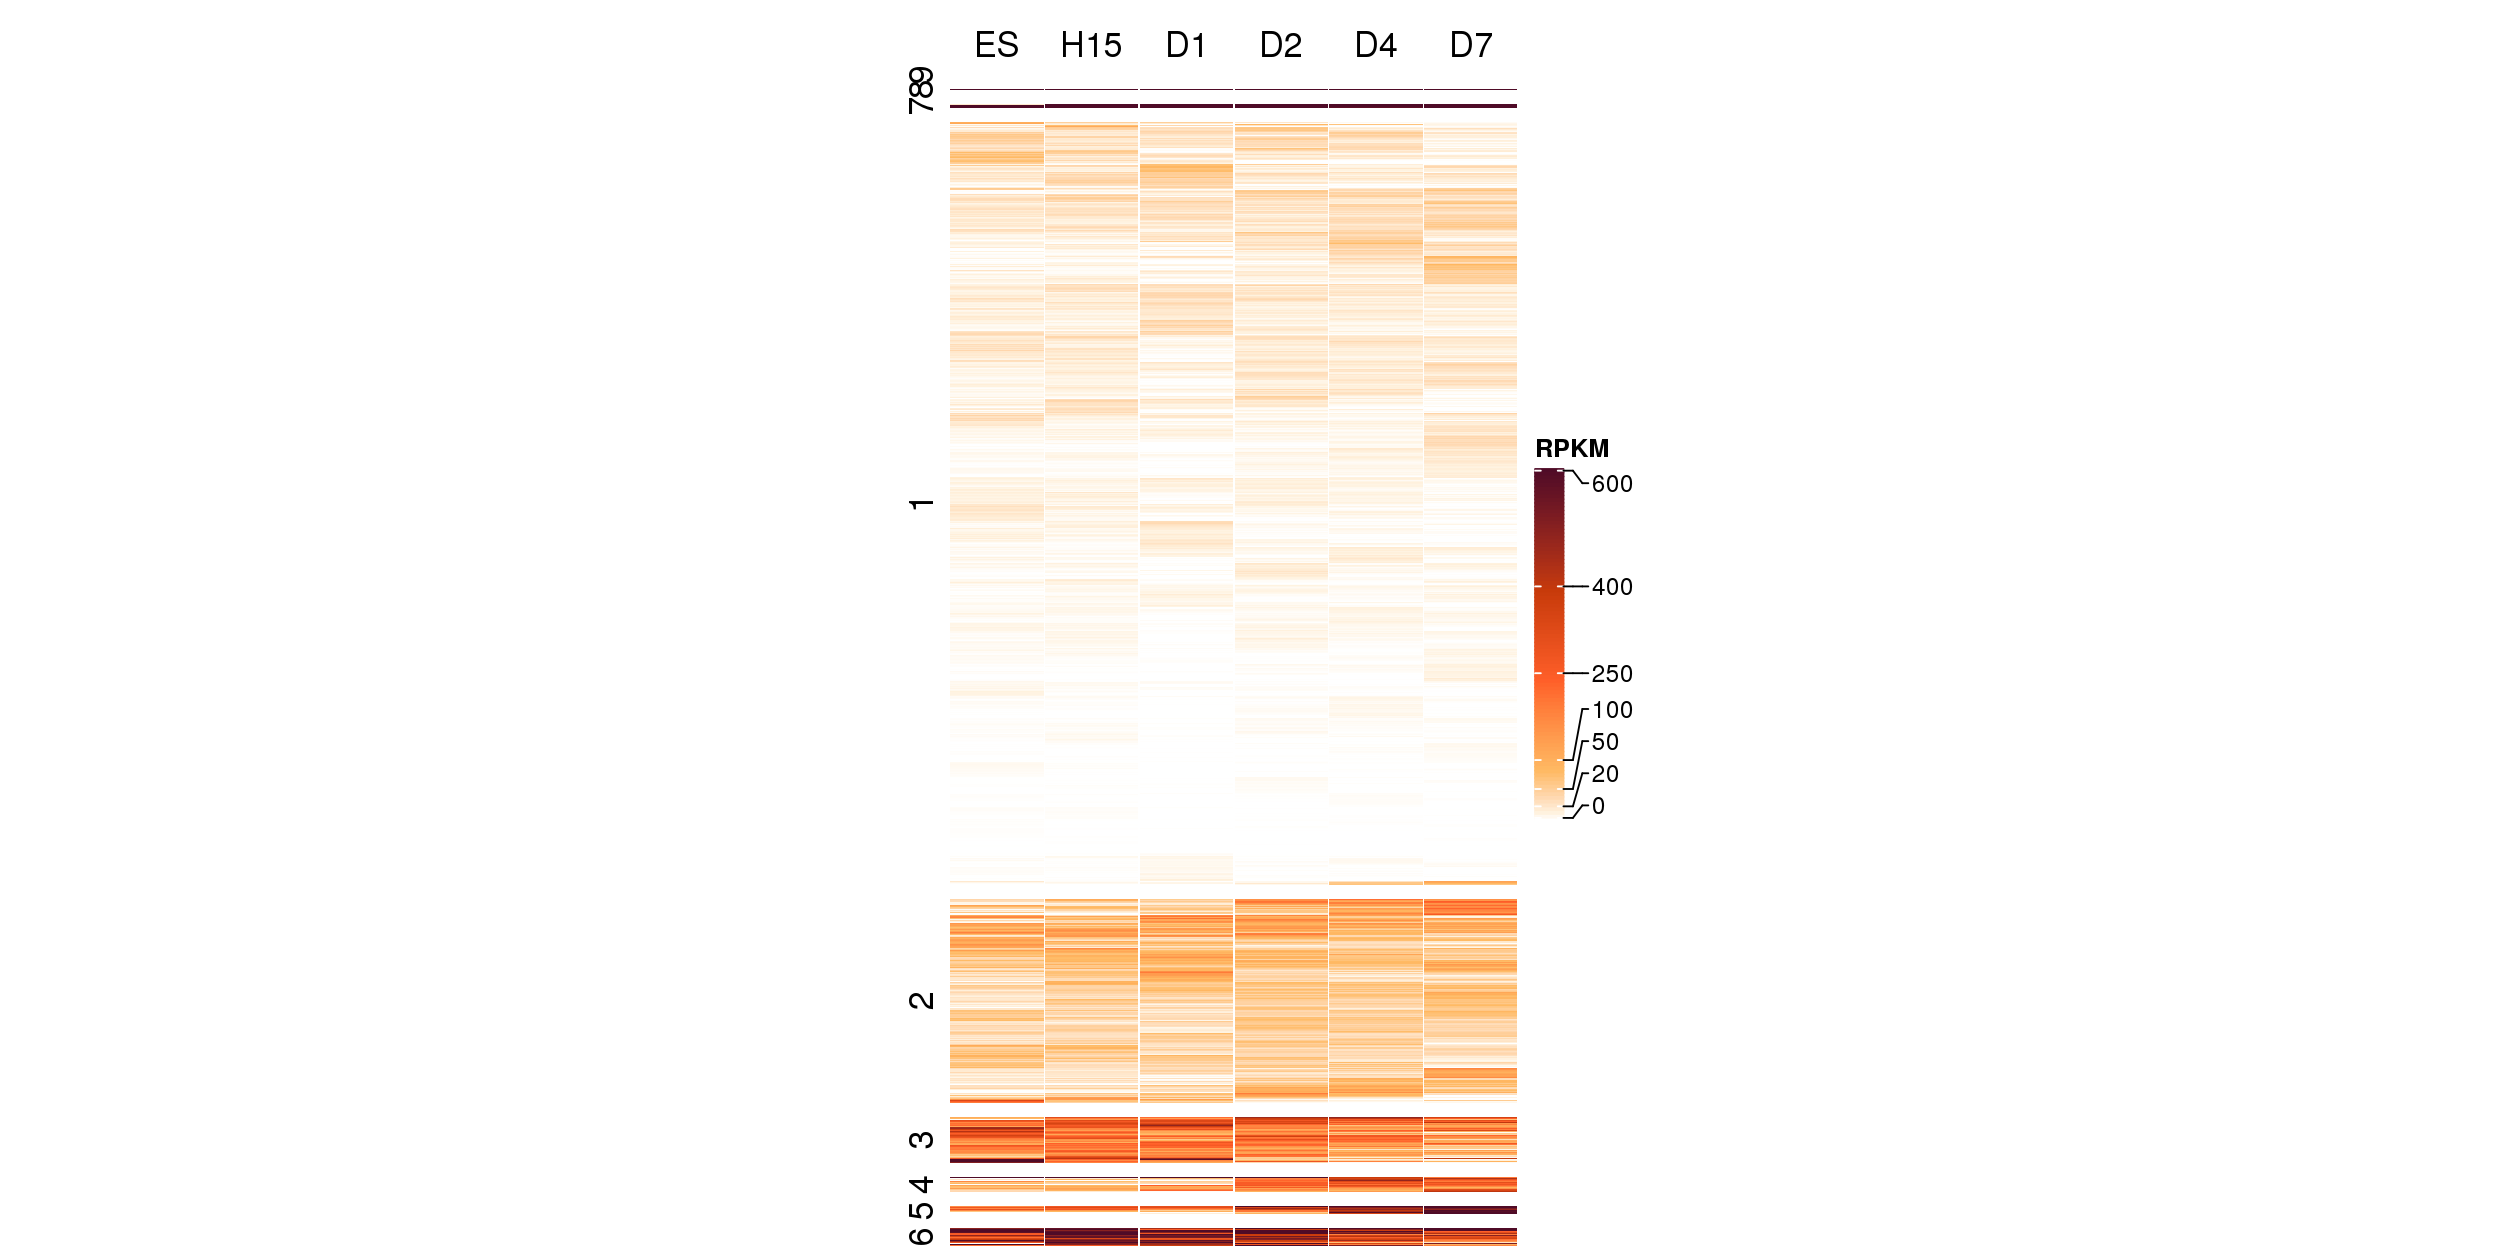

In [558]:
# Plot heatmap using median; Note the sequence of draw and getting order
set.seed(123)
ht1.median = Heatmap(TF.mx.median, column_split = sample.labels, column_gap = unit(.2, 'mm'), 
                    row_km = 9, row_km_repeats = 2000, row_gap = unit(2, 'mm'), 
                    cluster_rows = T, cluster_columns = F, show_row_names = F, show_column_names = F,
                    row_labels = gene.labels, column_labels = sample.labels, show_row_dend = F, show_column_dend = F,
                    col = col_fun, clustering_distance_rows = "euclidean", clustering_method_rows = "average", 
                    heatmap_legend_param = list(title = 'RPKM', at = col_breaks, legend_height = unit(5, 'cm')),
                    width = unit(8, 'cm')
                   )
ht1.median = draw(ht1.median) 
ht1.median.clusters = row_order(ht1.median)

## Heatmap based on existing row/column order and row/column split; AND on RPKM

In [562]:
#-------- retrive from file
cluster.order.sheets = readxl::excel_sheets("TF_RNAseq_Clusters_MedianRPKM_20200708.xlsx")
names(cluster.order.sheets) = cluster.order.sheets
# The last sheet contains Ensembl gene_IDs, not cluster info, thus do not load last sheet.
ht1.median.clusters = map(cluster.order.sheets[str_length(cluster.order.sheets) < 5], 
                          ~ readxl::read_xlsx("TF_RNAseq_Clusters_MedianRPKM_20200708.xlsx", sheet = .x) %>% pull(value))

In [563]:
#-------- directly from heatmap or after retrieval
# get row/column order from heatmap
read.orders = unlist(flatten(ht1.median.clusters), use.names = F)

# first get clusters
read.clusters = imap(ht1.median.clusters, ~rep(.y, length(.x))) %>% unlist(use.names = F)
# then make dataframe of row/column order and corresponding cluster
# reorder dataframe based on row/column order 1:N, this maps cluster name back to the original data matrix
read.clusters = data.frame(clusters = read.clusters, orders = read.orders) %>% 
                arrange(orders) %>% 
                pull(clusters) %>%
                factor(., levels = names(ht1.median.clusters))

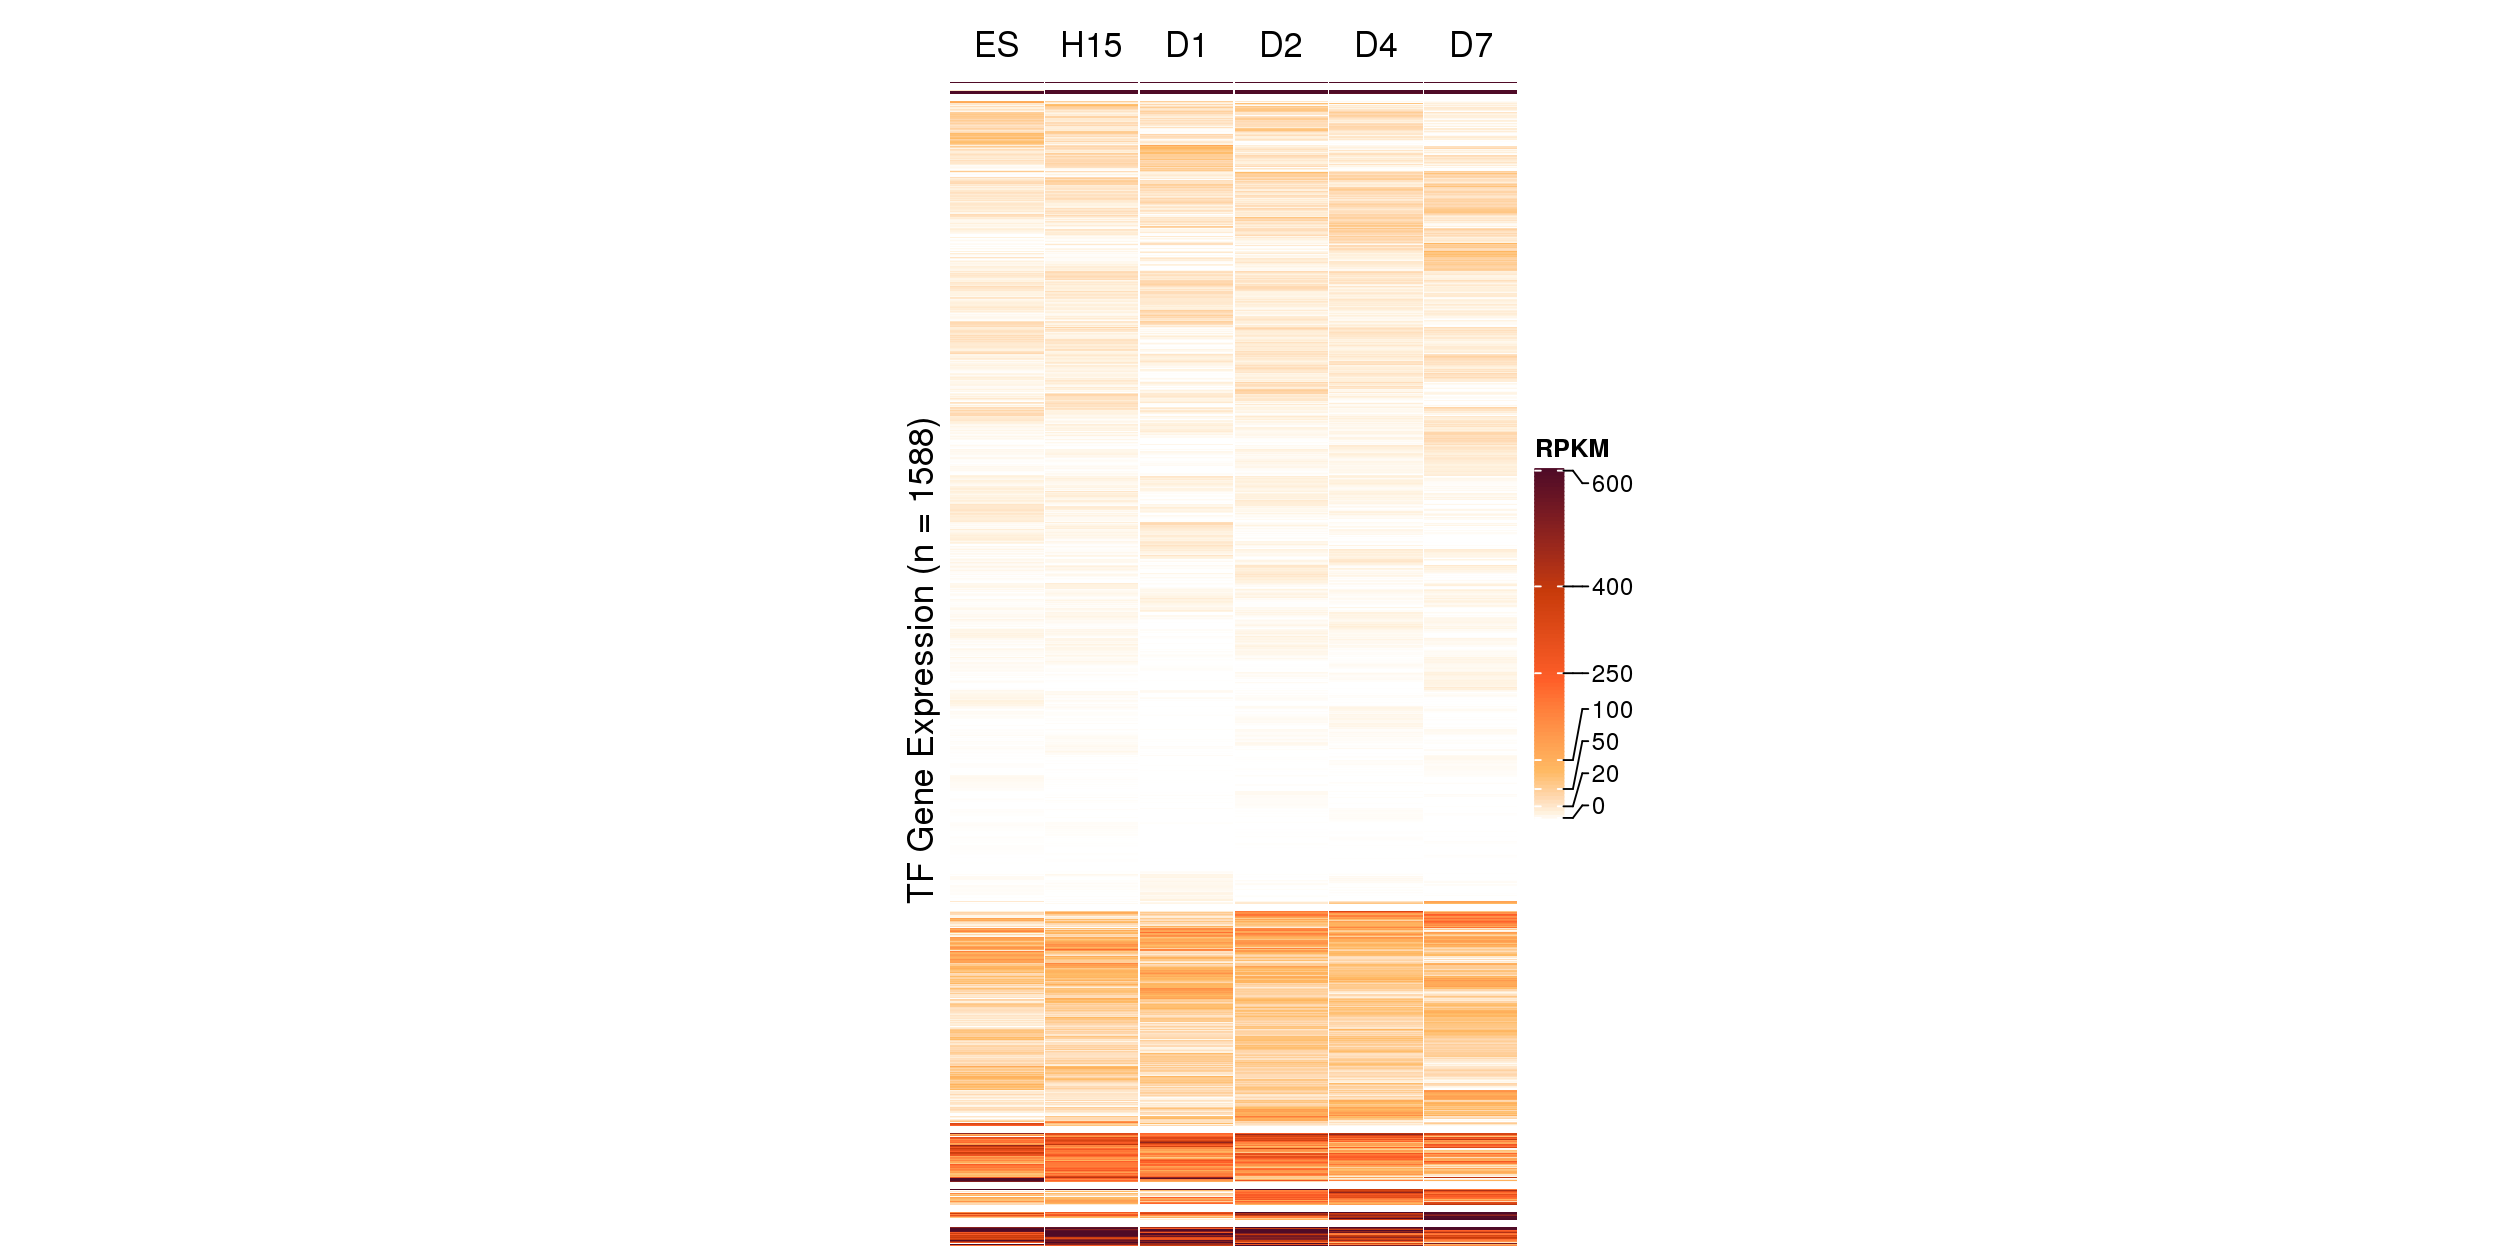

In [596]:
# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(TF.mx.median, column_split = sample.labels, column_gap = unit(.2, 'mm'),
                    row_order = read.orders, row_split = read.clusters, cluster_row_slices = F, row_gap = unit(1, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                    row_labels = gene.labels, column_labels = sample.labels, show_row_dend = F, show_column_dend = F,
                    col = col_fun, width = unit(8, 'cm'),
                    row_title = "TF Gene Expression (n = 1588)", row_title_side = 'left',
                    heatmap_legend_param = list(title = 'RPKM', at = col_breaks, legend_height = unit(5, 'cm')),
                   )

### USE Median log2FC of replicates for each time point to plot Heatmap

In [598]:
# color function/scale
col_breaks2 = c(-20, -5, 0, 5, 20)
col_fun2 <- colorRamp2(breaks = col_breaks2, c("#757BBB", '#9AA2D8', "#FFFFFF","#F4A556", "#F7931E"))

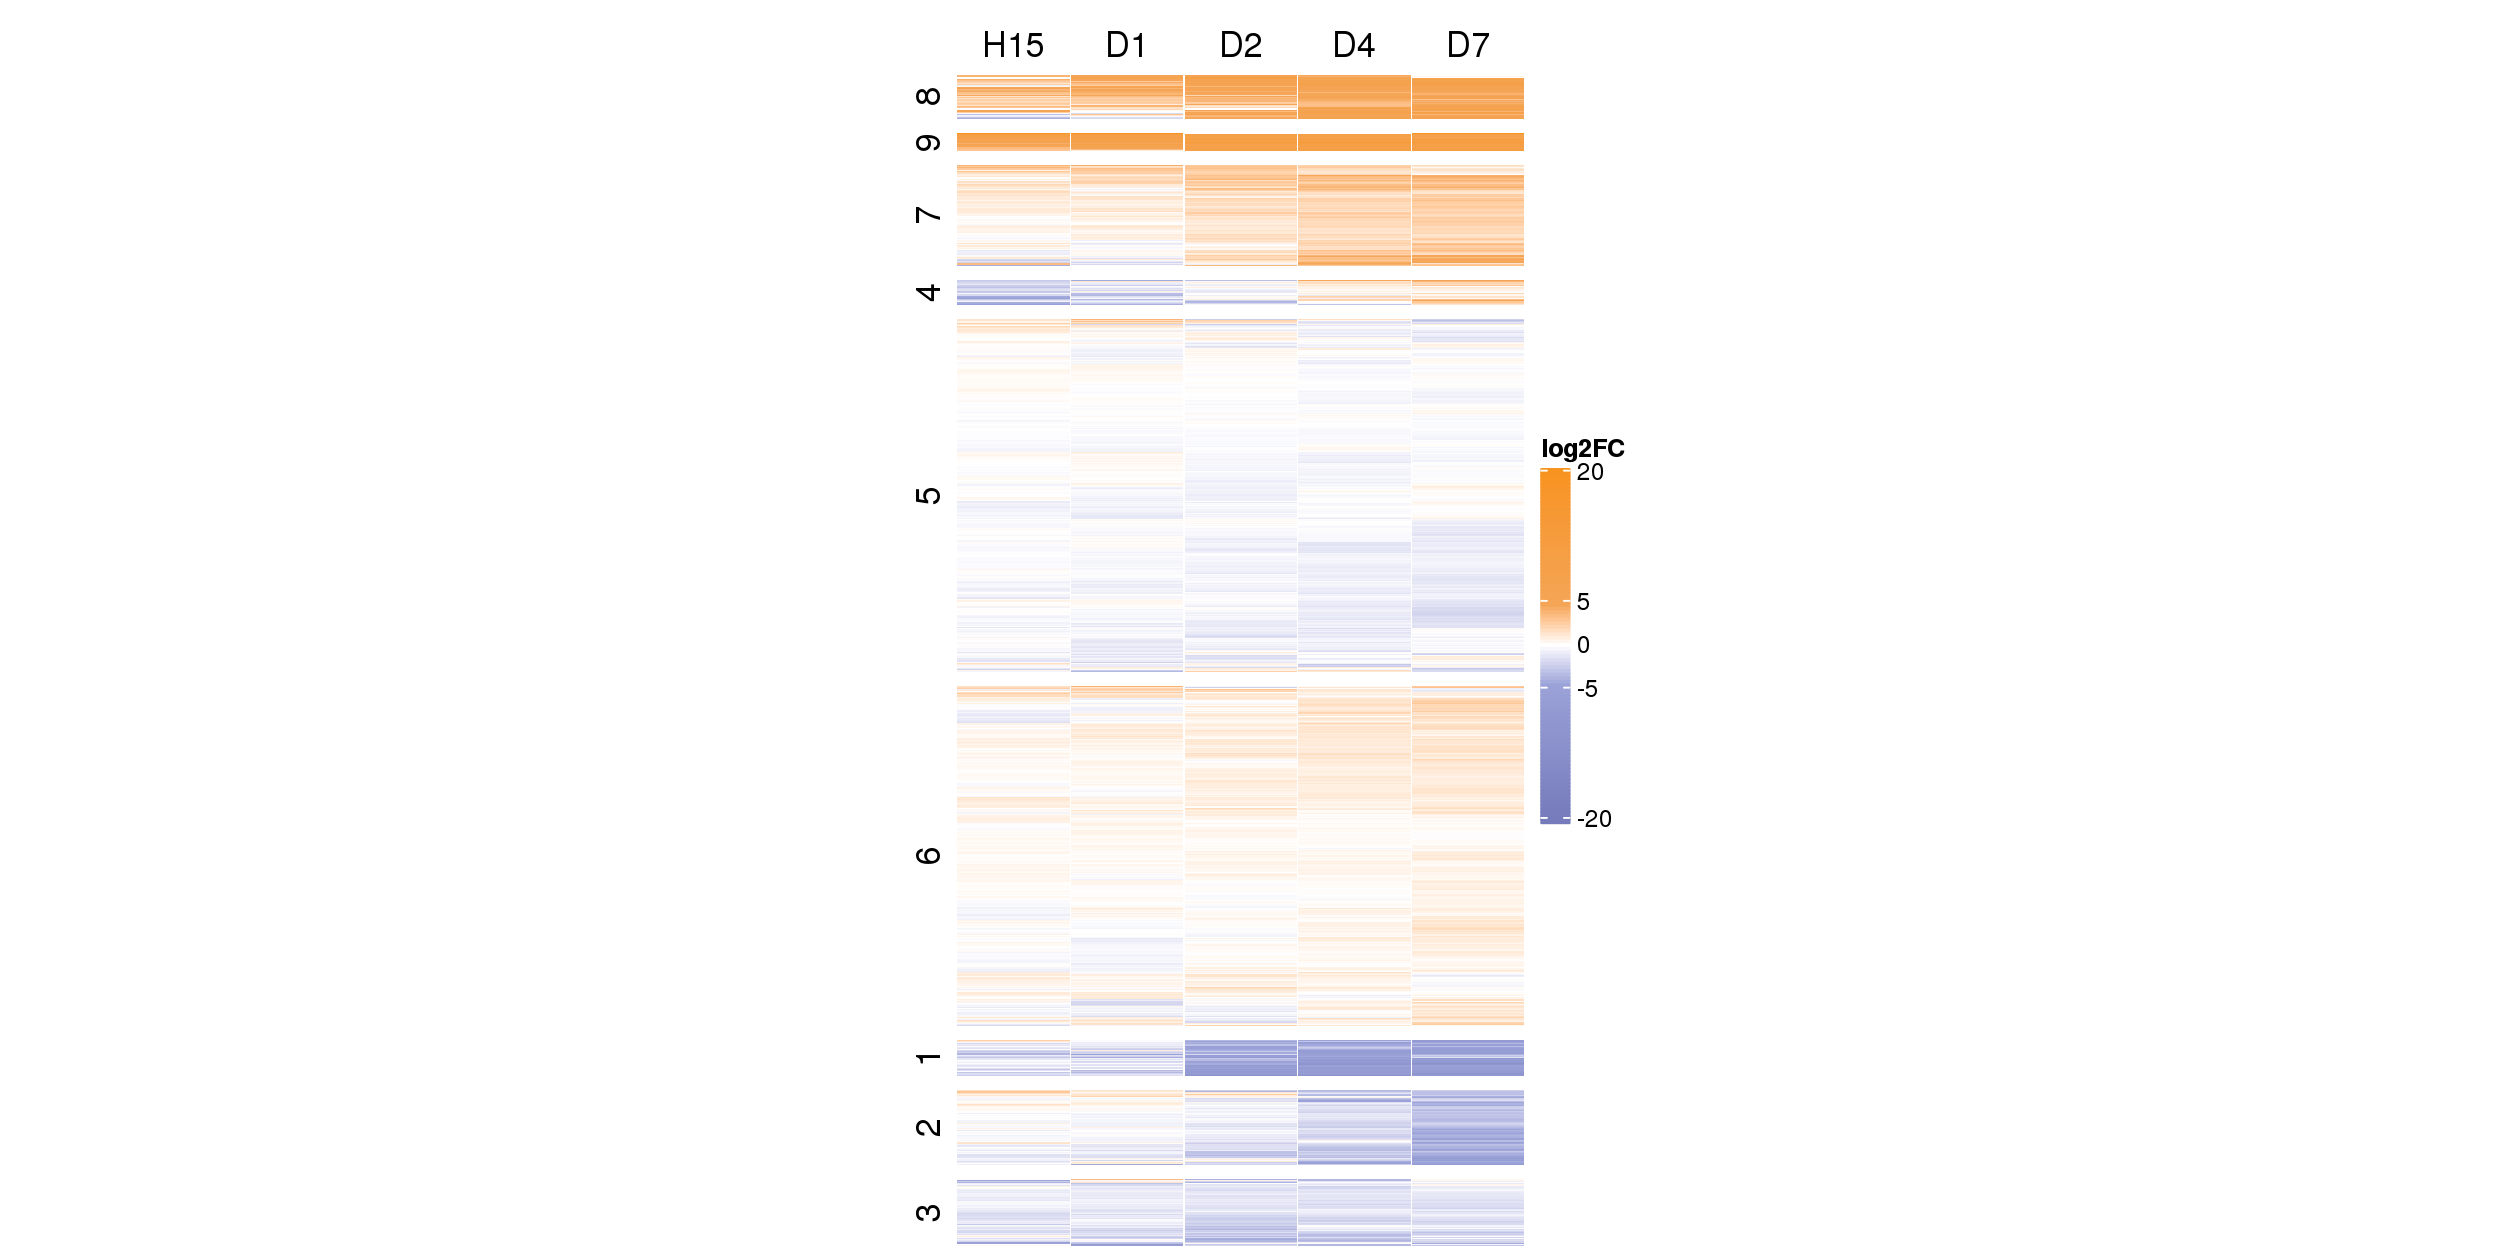

In [608]:
# Plot heatmap using median; Note the sequence of draw and getting order
set.seed(123)
ht1.fc = Heatmap(TF.mx.fc, column_split = sample.labels2, column_gap = unit(.2, 'mm'), 
                    row_km = 9, row_km_repeats = 2000, row_gap = unit(2, 'mm'), 
                    cluster_rows = T, cluster_columns = F, show_row_names = F, show_column_names = F,
                    row_labels = gene.labels, column_labels = sample.labels2, show_row_dend = F, show_column_dend = F,
                    col = col_fun2, clustering_distance_rows = "euclidean", clustering_method_rows = "average", 
                    heatmap_legend_param = list(title = 'log2FC', at = col_breaks2, legend_height = unit(5, 'cm')),
                    width = unit(8, 'cm')
                   )
ht1.fc = draw(ht1.fc) 
ht1.fc.clusters = row_order(ht1.fc)

In [611]:
# SAVE TO FILE
WriteXLS::WriteXLS(map(c(ht1.fc.clusters, list('TF.mx.FC.geneid' = rownames(TF.mx.fc))), ~ as_tibble(.x)), "TF_RNAseq_Clusters_log2FC_20200708.xlsx")

In [612]:
#-------- retrive from file
cluster.order.sheets2 = readxl::excel_sheets("TF_RNAseq_Clusters_log2FC_20200708.xlsx")
names(cluster.order.sheets2) = cluster.order.sheets2
# The last sheet contains Ensembl gene_IDs, not cluster info, thus do not load last sheet.
ht1.fc.clusters = map(cluster.order.sheets2[str_length(cluster.order.sheets2) < 5], 
                          ~ readxl::read_xlsx("TF_RNAseq_Clusters_log2FC_20200708.xlsx", sheet = .x) %>% pull(value))

In [613]:
#-------- directly from heatmap or after retrieval
# get row/column order from heatmap
read.orders2 = unlist(flatten(ht1.fc.clusters), use.names = F)

# first get clusters
read.clusters2 = imap(ht1.fc.clusters, ~rep(.y, length(.x))) %>% unlist(use.names = F)
# then make dataframe of row/column order and corresponding cluster
# reorder dataframe based on row/column order 1:N, this maps cluster name back to the original data matrix
read.clusters2 = data.frame(clusters = read.clusters2, orders = read.orders2) %>% 
                arrange(orders) %>% 
                pull(clusters) %>%
                factor(., levels = names(ht1.fc.clusters))

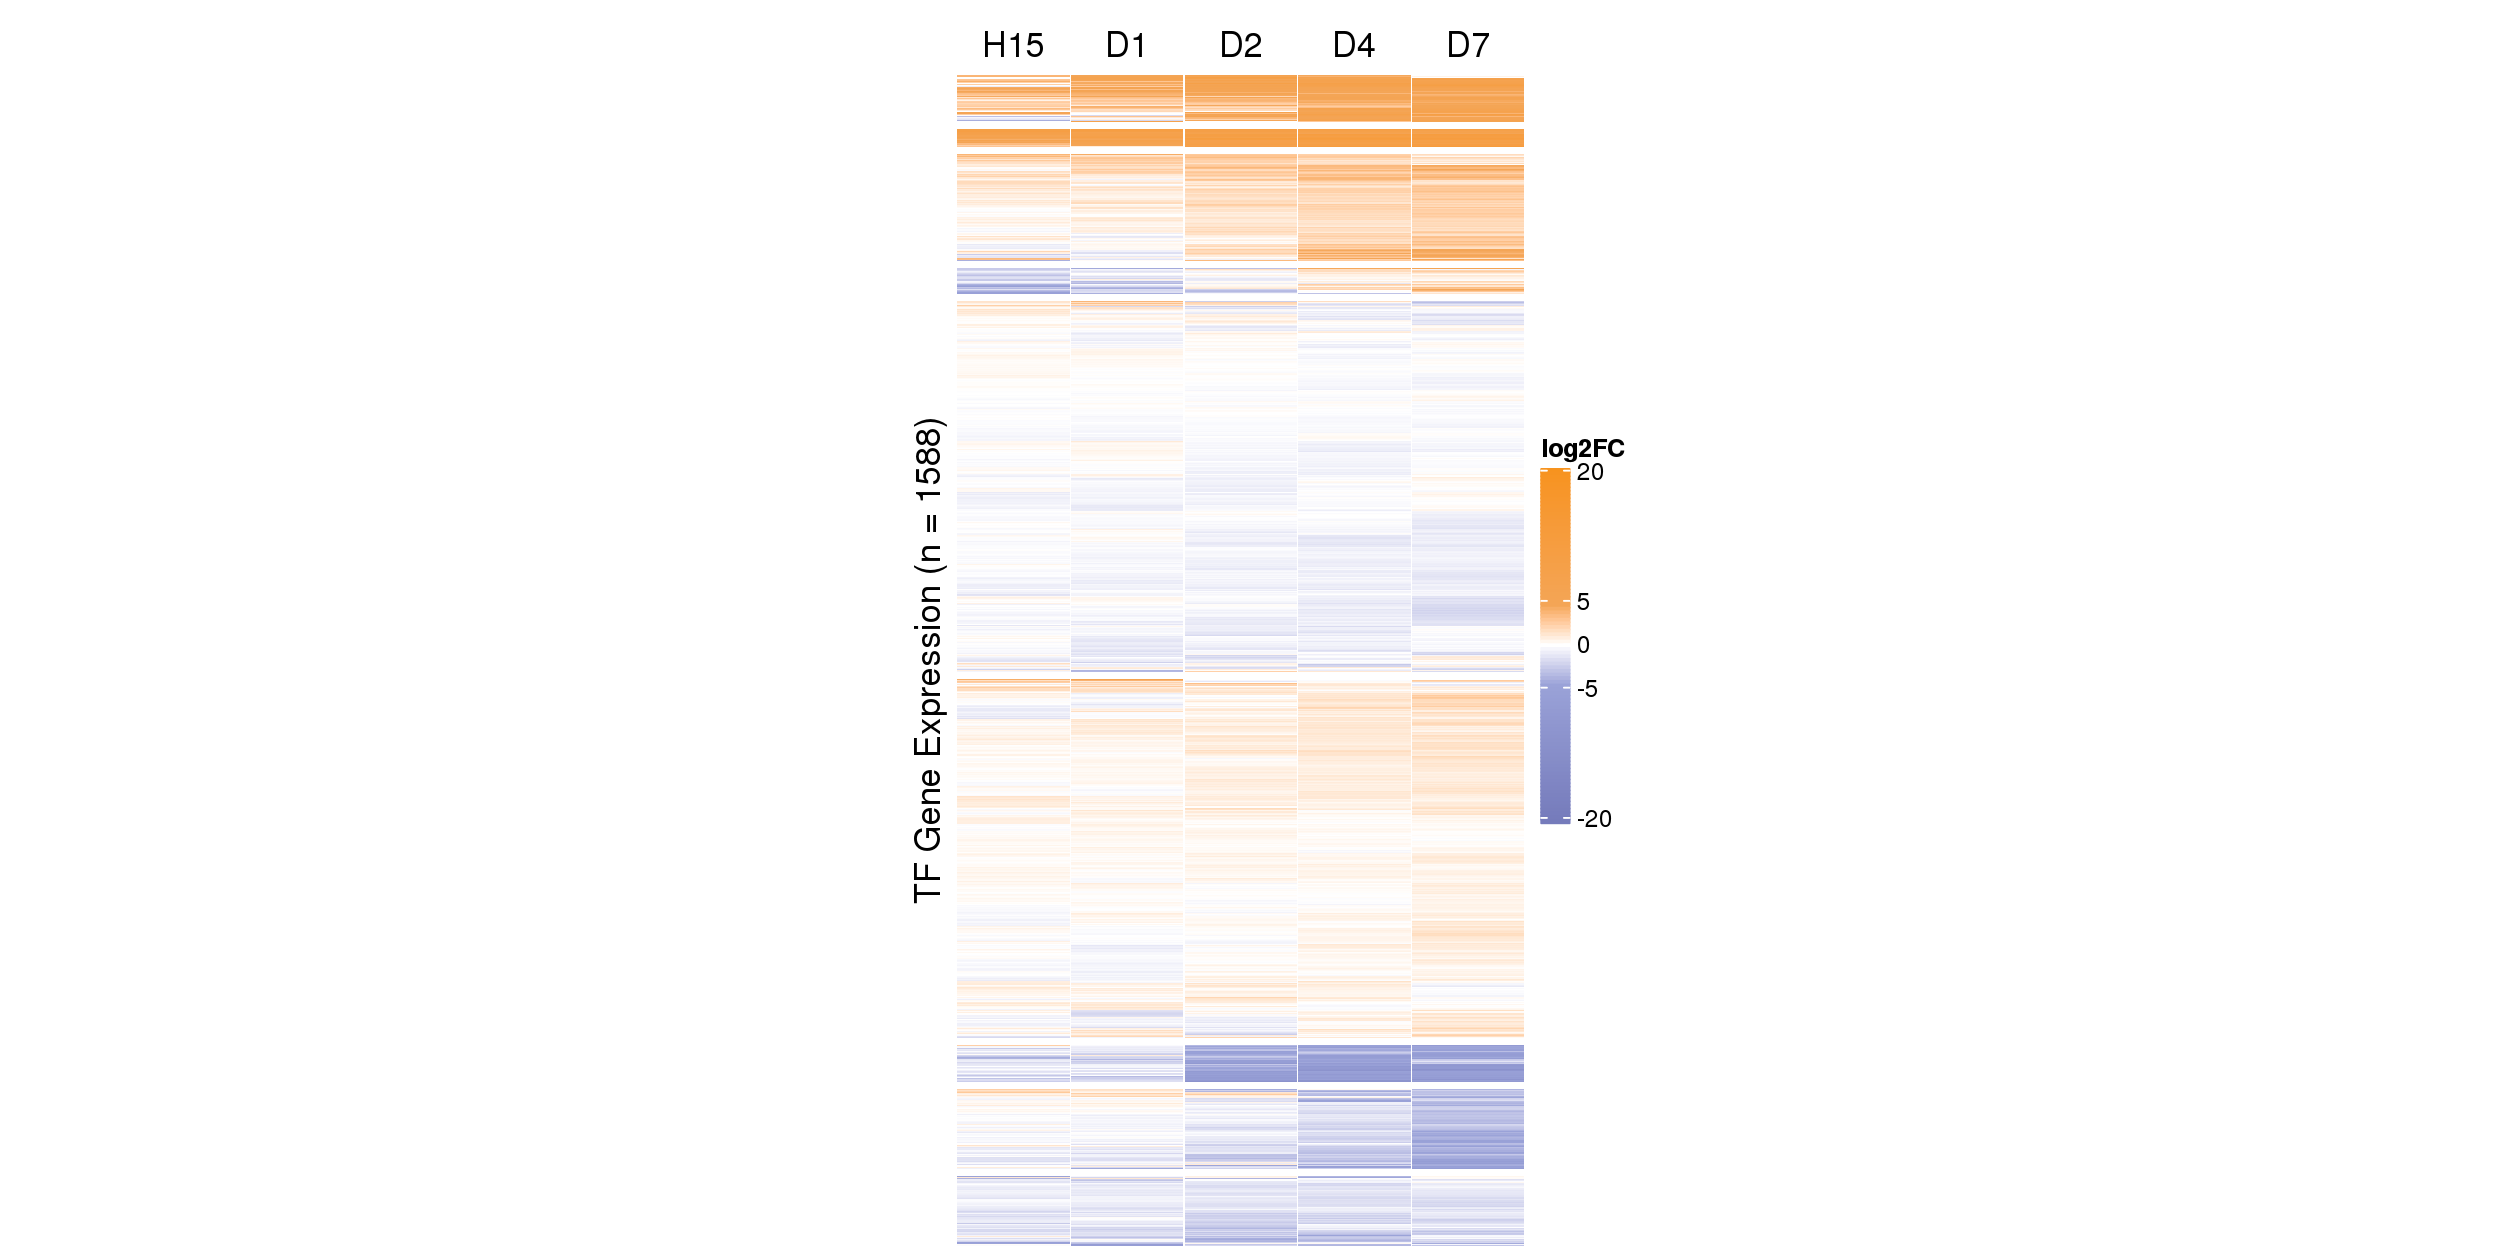

In [ ]:
Heatmap(TF.mx.fc, column_split = sample.labels2, column_gap = unit(.2, 'mm'),
                    row_order = read.orders2, row_split = read.clusters2, cluster_row_slices = F, row_gap = unit(1, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                    row_labels = gene.labels, column_labels = sample.labels2, show_row_dend = F, show_column_dend = F,
                    col = col_fun2, width = unit(8, 'cm'),
                    row_title = "TF Gene Expression (n = 1588)", row_title_side = 'left',
                    heatmap_legend_param = list(title = 'log2FC', at = col_breaks2, legend_height = unit(5, 'cm')),
                   )

---

# ALLEN BRAIN MAP

NOTE Heatmaps for tissue samples from Allen Brain Map is in `human_genetics_R.ipynb`

In [924]:
# remove TFs that are not in Allen Brain Map dataset
rm.tf = c('SCRT1','GTF2I','ZNF234','ZNF285','ZNF224','IKBKG','TAF15','KMT2B','ZNHIT3','LHX1','TAF9','ZNF280B','MLLT6','ZNF2','H2BC9','TADA2A','DACH1','PCGF2','ZNF670','ZNF229','MATR3','POLR2J3')
rm.tf.id = filter(tf_norm_cnts[,1:2], gene_name %in% rm.tf) %>% pull(gene_id)
rm.tf.row = which(rownames(TF.mx.median) %in% rm.tf.id)

TF.mx.median2 = TF.mx.median[-rm.tf.row,]
TF.mx.fc2 = TF.mx.fc[-rm.tf.row,]
gene.labels2 = tf_norm_cnts$gene_name[-rm.tf.row]
# write common gene names for tissue heatmaps in `human_genetics_R.ipynb`
data.frame(genes = gene.labels2) %>% write_csv('Allen-BrainSpan/common_gene_names_with_TFscreen_cell.csv') 

In [886]:
# make mark annotation on selected genes
mark_genes = c('ZBTB18', 'NEUROG2', 'NEUROG1', 'EBF1', 'ZZZ3', 'POU3F2', 'VAX2', 'FOXN2')
mark_genes_idx = map_dbl(mark_genes, ~ which(gene.labels2 == .x)) # index of marked genes in heatmap matrix
gene_marks = rowAnnotation(markGenes = anno_mark(at = mark_genes_idx, labels = mark_genes, 
                                                 labels_gp = gpar(fontsize = 8), link_gp = gpar(lwd = .2), link_width = unit(15, 'mm')))

## Plot Heatmap for median RPKM (for Allen Brain)

In [743]:
# color function/scale
col_breaks = c(0, 20, 50, 100, 250, 400, 600)
col_fun = colorRamp2(breaks = col_breaks, c("#FFFFFF",'#FFF2DF', "#FFD9B2", "#FFBA64", "#ff5f29", "#c73a0a", "#4f0b27"))

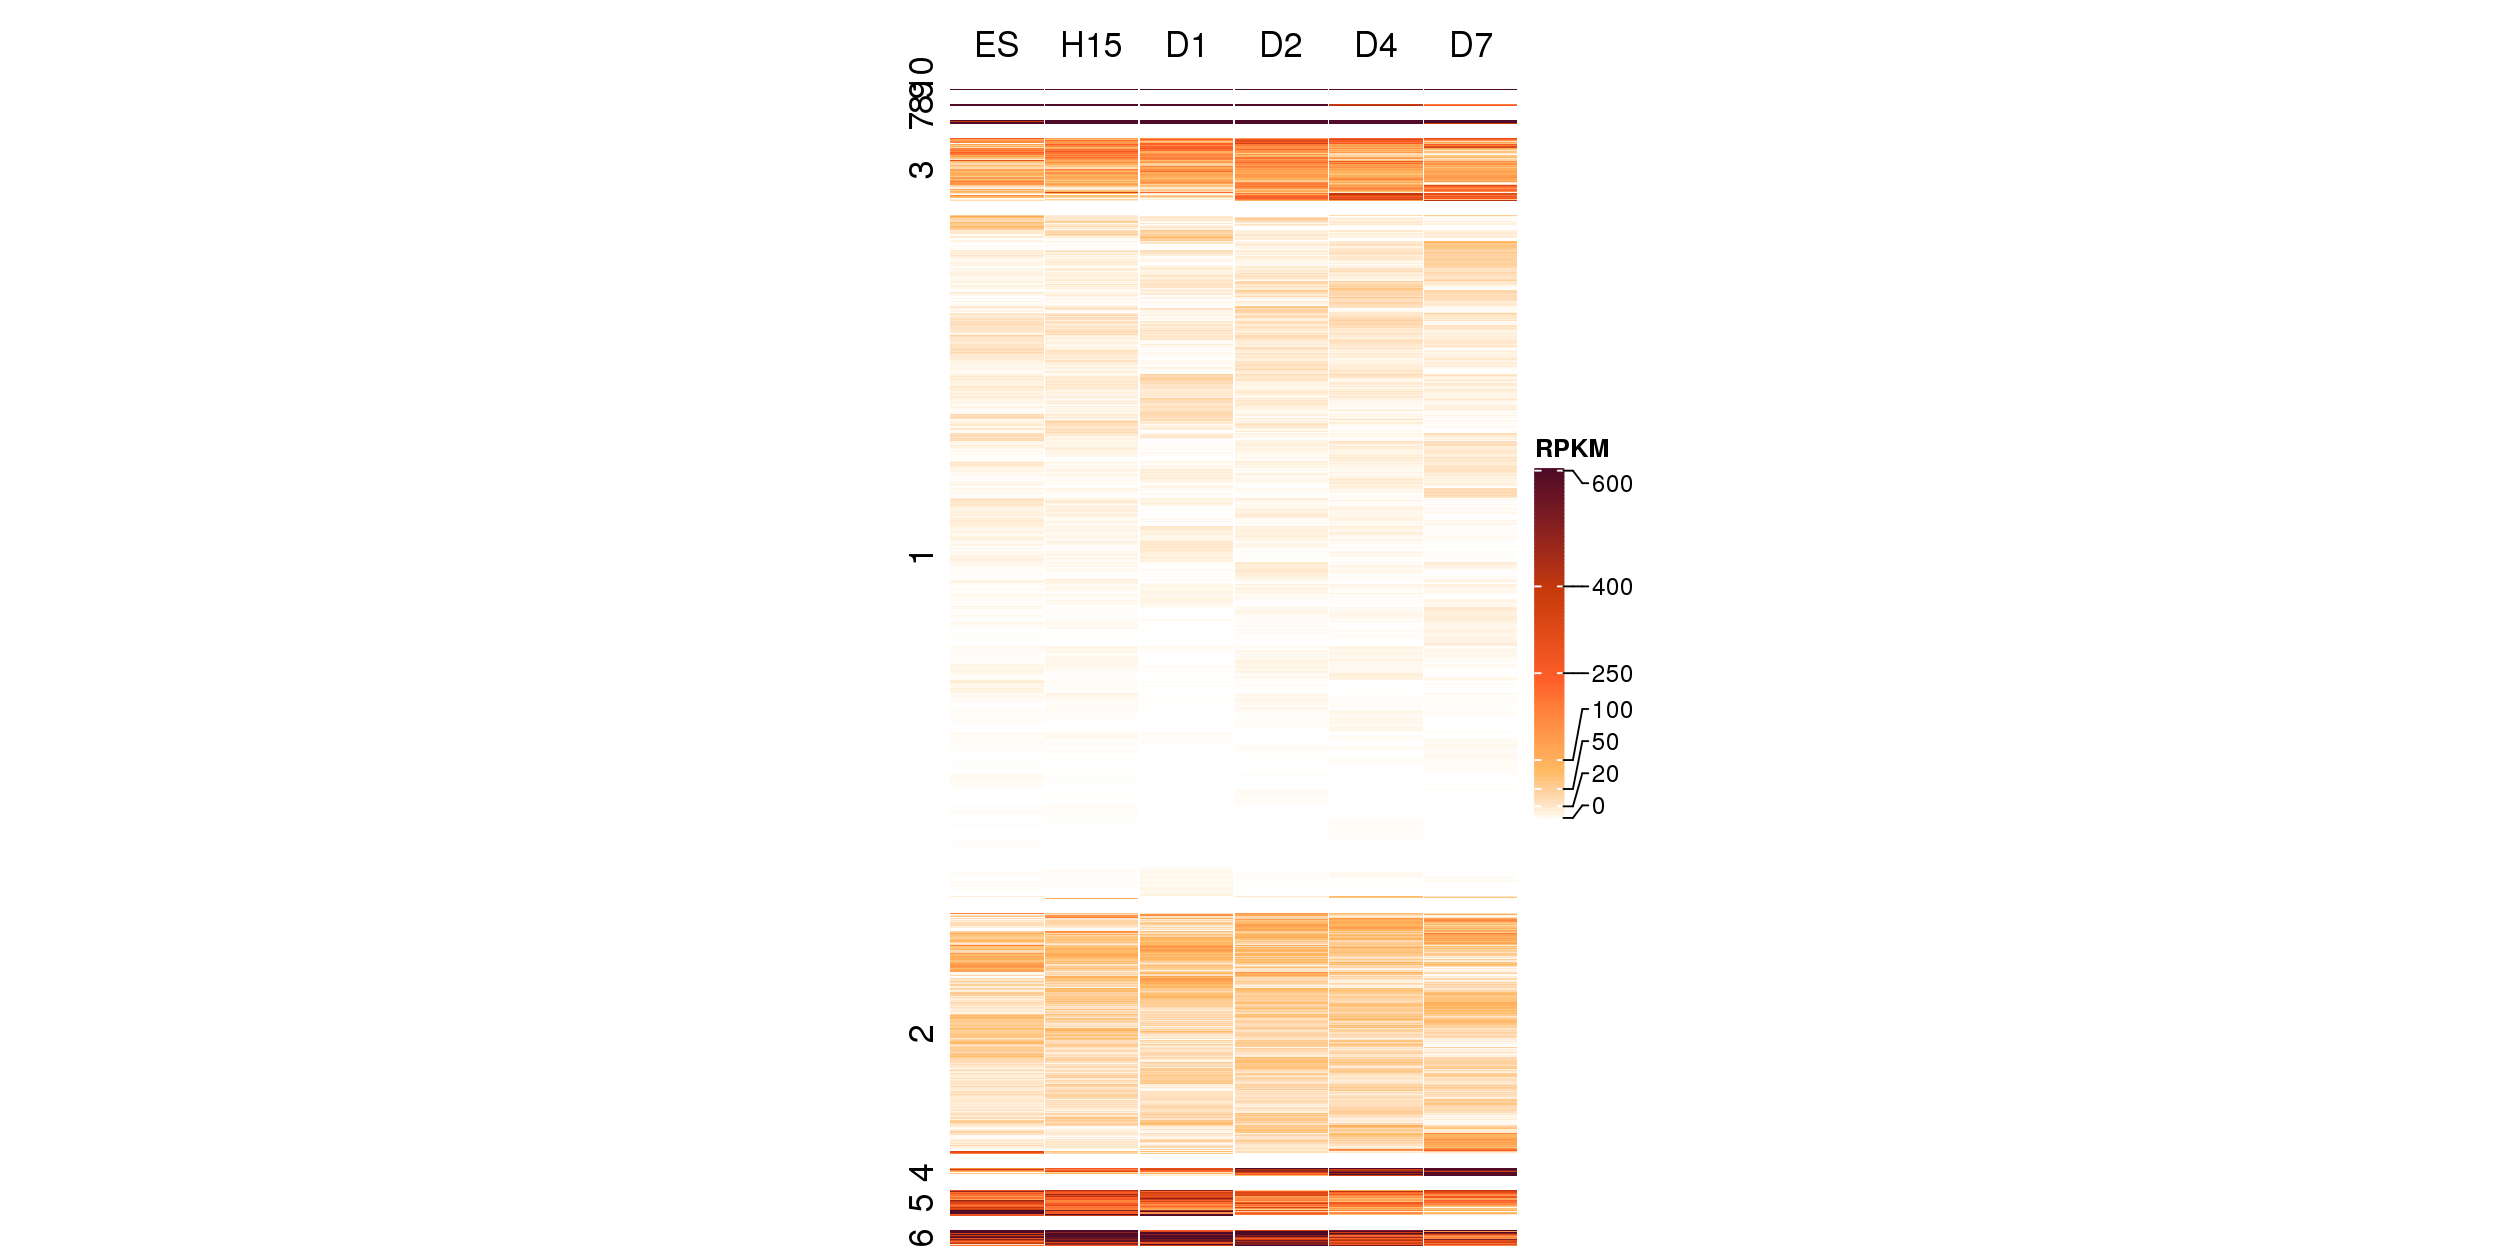

In [818]:
# Plot heatmap using median; Note the sequence of draw and getting order
set.seed(123)
ht2.median = Heatmap(TF.mx.median2, column_split = sample.labels, column_gap = unit(.2, 'mm'), 
                    row_km = 10, row_km_repeats = 2000, row_gap = unit(2, 'mm'), 
                    cluster_rows = T, cluster_columns = F, show_row_names = F, show_column_names = F,
                    row_labels = gene.labels2, column_labels = sample.labels, show_row_dend = F, show_column_dend = F,
                    col = col_fun, clustering_distance_rows = "euclidean", clustering_method_rows = "average", 
                    heatmap_legend_param = list(title = 'RPKM', at = col_breaks, legend_height = unit(5, 'cm')),
                    width = unit(8, 'cm')
                   )
ht2.median = draw(ht2.median) 
ht2.median.clusters = row_order(ht2.median)

In [819]:
# SAVE TO FILE
WriteXLS::WriteXLS(map(ht2.median.clusters, ~ as_tibble(.x)), "TF_RNAseq_Clusters_MedianRPKM_V2_20200709.xlsx")

In [931]:
which(gene.labels == 'NEUROG2')

[1] 1243

In [933]:
TF.mx.median[1243:1244,]

,ES,H15,D1,D2,D4,D7
ENSG00000178403.4,0.000000,3.582476,0.00000,4.902742,21.45596,11.40918
ENSG00000178573.7,9.101058,65.298758,68.25157,36.070172,25.78479,11.68083


#### Median RPKM Heatmap for Allen Brain, Using predermined gene order

In [820]:
#-------- retrive from file
ht2.cluster.order.sheets = readxl::excel_sheets("TF_RNAseq_Clusters_MedianRPKM_V2_20200709.xlsx")
names(ht2.cluster.order.sheets) = ht2.cluster.order.sheets

# The last sheet contains Ensembl gene_IDs, not cluster info, thus do not load last sheet.
ht2.median.clusters = map(ht2.cluster.order.sheets[str_length(ht2.cluster.order.sheets) < 5], 
                          ~ readxl::read_xlsx("TF_RNAseq_Clusters_MedianRPKM_V2_20200709.xlsx", sheet = .x) %>% 
                              pull(value)
                         )

In [821]:
#-------- directly from heatmap or after retrieval
# get row/column order from heatmap
ht2.median.orders = unlist(flatten(ht2.median.clusters), use.names = F)

# first get clusters
ht2.median.cluster.labels = imap(ht2.median.clusters, ~rep(.y, length(.x))) %>% unlist(use.names = F)

# then make dataframe of row/column order and corresponding cluster
# reorder dataframe based on row/column order 1:N, this maps cluster name back to the original data matrix
ht2.median.cluster.labels = data.frame(clusters = ht2.median.cluster.labels, orders = ht2.median.orders, stringsAsFactors = F) %>% 
                arrange(orders) %>% 
                pull(clusters) %>%
                factor(., levels = names(ht2.median.clusters))

In [907]:
# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
pdf('figures/Heatmap_AllenBrainMap_Cell_MedianRPKM.pdf', width = 8.5, height = 11)
Heatmap(TF.mx.median2, column_split = sample.labels, column_gap = unit(.2, 'mm'),
                    row_order = ht2.median.orders, row_split = ht2.median.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = gene.labels2, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("TF Gene Expression (n = ", dim(TF.mx.median2)[1], ")"), row_title_side = 'left',
                    column_title = "Cell data (RPKM)", 
                    heatmap_legend_param = list(title = 'RPKM', at = col_breaks, legend_height = unit(5, 'cm')),
                   )
dev.off()

png 
  2

## Plot Heatmap for Log2FC (for Allen Brain)

In [777]:
# color function/scale
col_breaks2 = c(-20, -5, 0, 5, 20)
col_fun2 <- colorRamp2(breaks = col_breaks2, c("#757BBB", '#9AA2D8', "#FFFFFF","#F4A556", "#F7931E"))

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


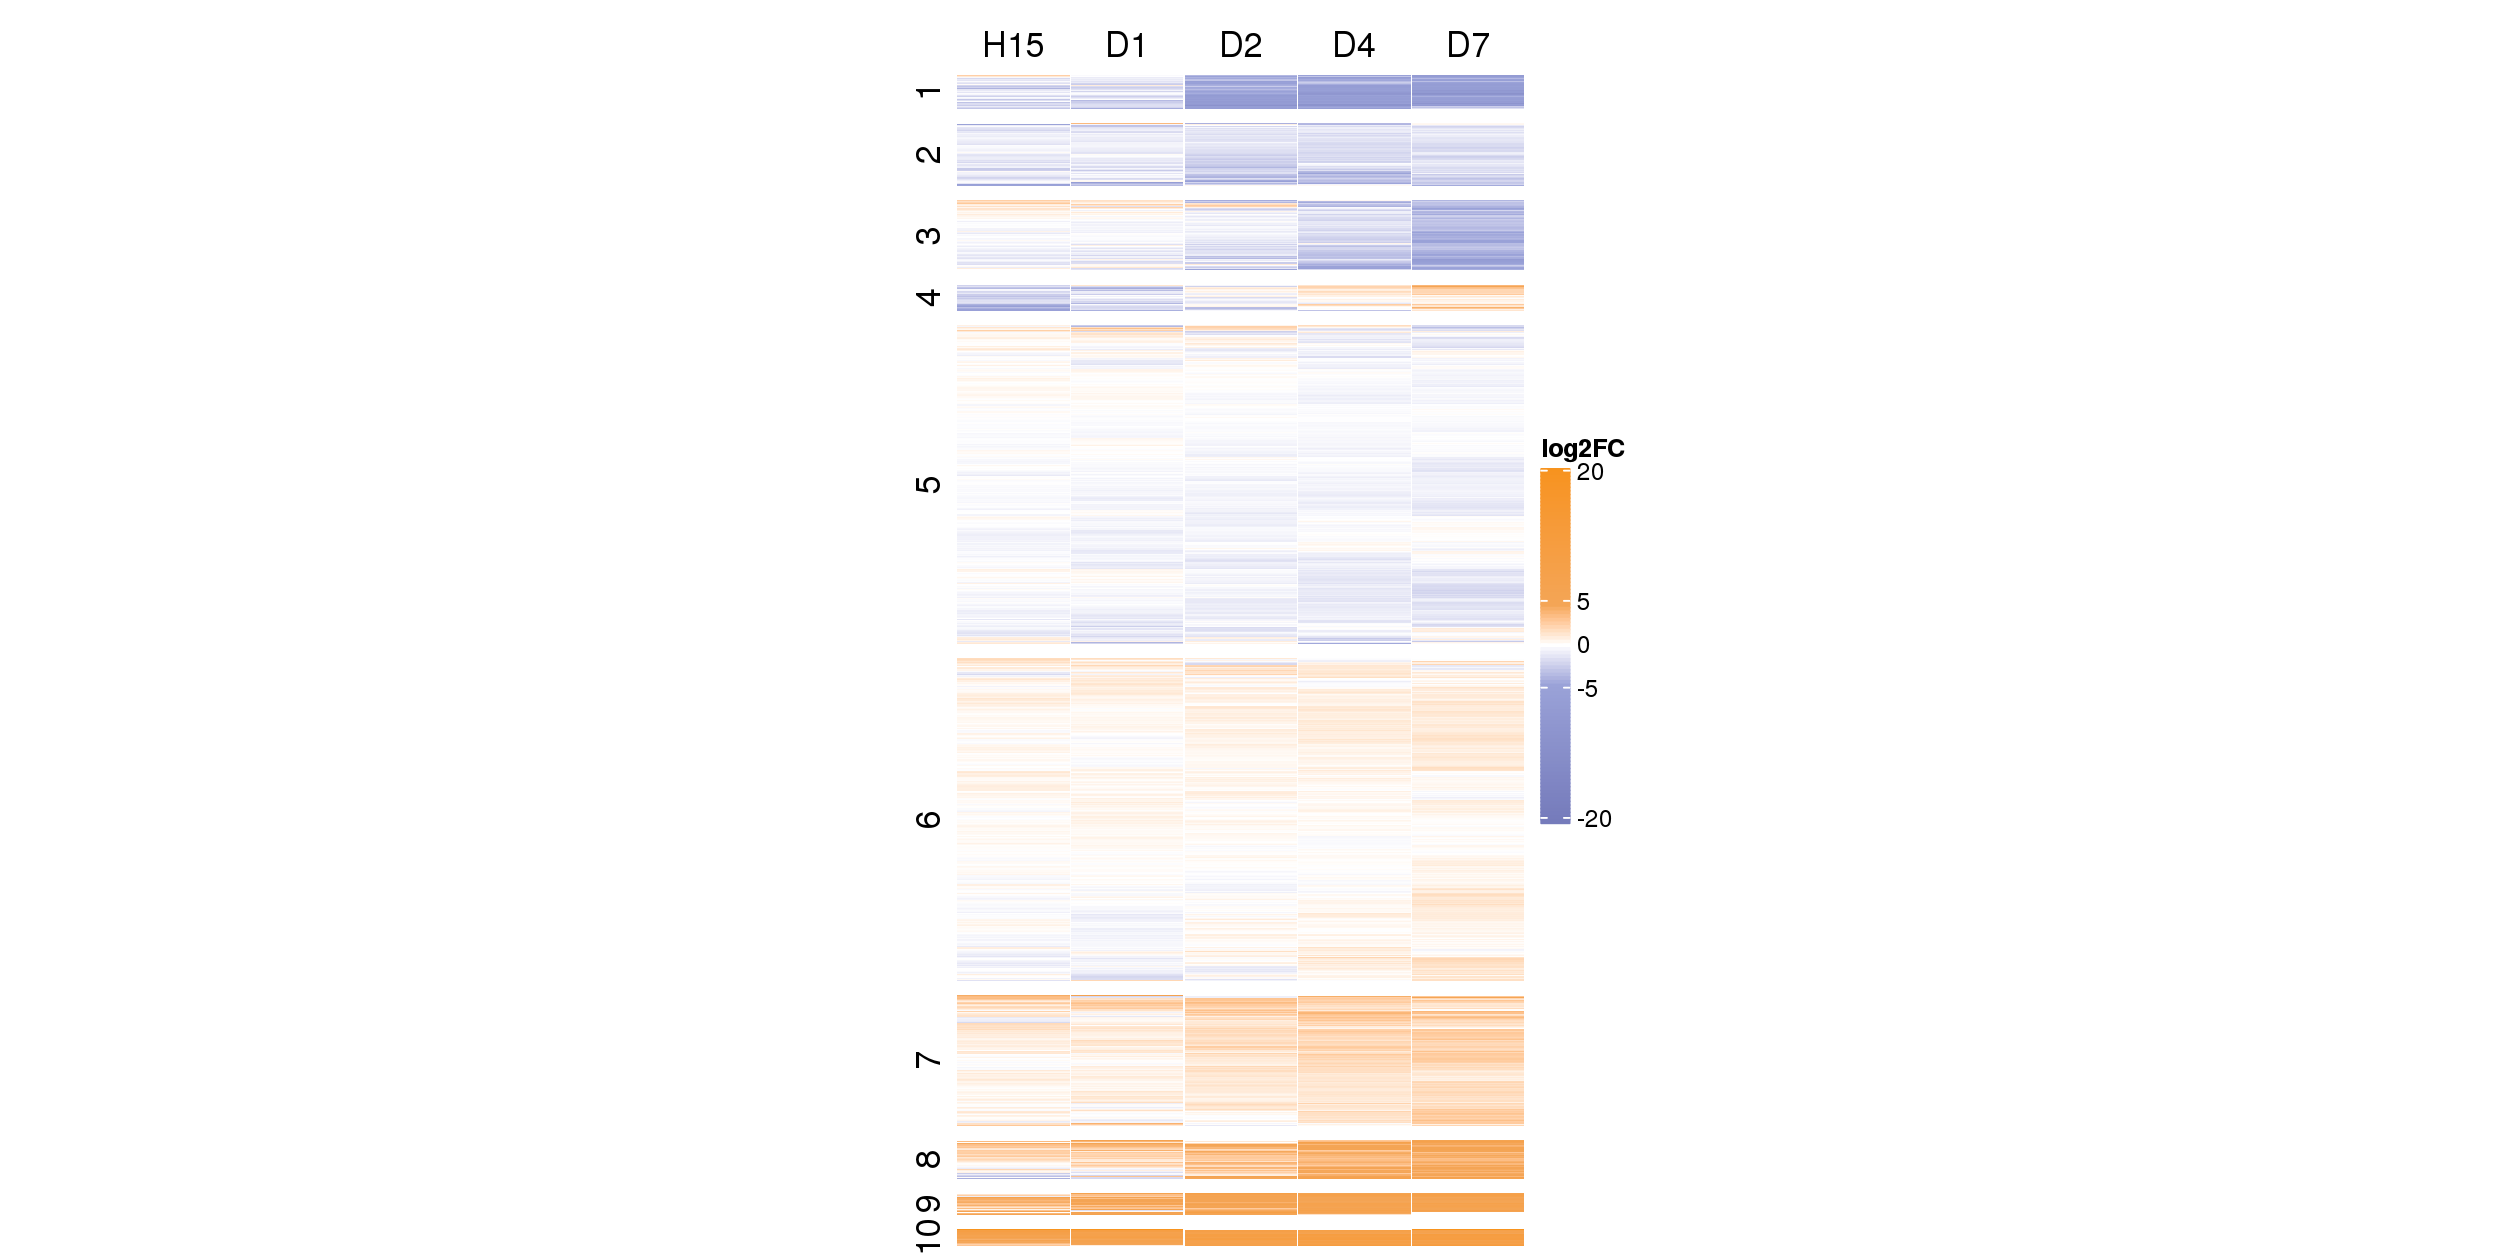

In [840]:
# Plot heatmap using median; Note the sequence of draw and getting order
set.seed(123)
ht2.fc = Heatmap(TF.mx.fc2, column_split = sample.labels2, column_gap = unit(.2, 'mm'), 
                    row_km = 10, row_km_repeats = 2000, row_gap = unit(2, 'mm'), 
                    cluster_rows = T, cluster_columns = F, show_row_names = F, show_column_names = F,
                    row_labels = gene.labels2, column_labels = sample.labels2, show_row_dend = F, show_column_dend = F,
                    col = col_fun2, clustering_distance_rows = "euclidean", clustering_method_rows = "average", 
                    heatmap_legend_param = list(title = 'log2FC', at = col_breaks2, legend_height = unit(5, 'cm')),
                    width = unit(8, 'cm')
                   )
ht2.fc = draw(ht2.fc) 
ht2.fc.clusters = row_order(ht2.fc)

In [842]:
# SAVE TO FILE
WriteXLS::WriteXLS(map(ht2.fc.clusters, ~ as_tibble(.x)), "TF_RNAseq_Clusters_Log2FC_V2_20200709.xlsx")

#### Median Log2FC Heatmap for Allen Brain, Using predermined gene order

In [843]:
#-------- retrive from file
ht2.cluster.order.sheets2 = readxl::excel_sheets("TF_RNAseq_Clusters_Log2FC_V2_20200709.xlsx")
names(ht2.cluster.order.sheets2) = ht2.cluster.order.sheets2

# The last sheet contains Ensembl gene_IDs, not cluster info, thus do not load last sheet.
ht2.fc.clusters = map(ht2.cluster.order.sheets2[str_length(ht2.cluster.order.sheets2) < 5], 
                          ~ readxl::read_xlsx("TF_RNAseq_Clusters_Log2FC_V2_20200709.xlsx", sheet = .x) %>% 
                              pull(value)
                         )

In [844]:
#-------- directly from heatmap or after retrieval
# get row/column order from heatmap
ht2.fc.orders = unlist(flatten(ht2.fc.clusters), use.names = F)

# first get clusters
ht2.fc.cluster.labels = imap(ht2.fc.clusters, ~rep(.y, length(.x))) %>% unlist(use.names = F)

# then make dataframe of row/column order and corresponding cluster
# reorder dataframe based on row/column order 1:N, this maps cluster name back to the original data matrix
ht2.fc.cluster.labels = data.frame(clusters = ht2.fc.cluster.labels, orders = ht2.fc.orders, stringsAsFactors = F) %>% 
                arrange(orders) %>% 
                pull(clusters) %>%
                factor(., levels = names(ht2.fc.clusters))

In [906]:
pdf('figures/Heatmap_AllenBrainMap_Cell_Log2FC.pdf', width = 8.5, height = 11)
# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(TF.mx.fc2, column_split = sample.labels2, column_gap = unit(.2, 'mm'), 
                    row_order = ht2.fc.orders, row_split = ht2.fc.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = gene.labels2, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun2, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("TF Gene Expression (n = ", dim(TF.mx.fc2)[1], ")"), row_title_side = 'left',
                    column_title = "Cell data (Log2FC)", 
                    heatmap_legend_param = list(title = 'Log2FC', at = col_breaks2, legend_height = unit(5, 'cm')),
                   )
dev.off()

png 
  2

<br><br><br><br>

---


# Hit expresion per sample: 

Dot Product (hits / nonhits with RNA-seq): 
1. create a binary vector with same length and index as each gene_id in RNA-seq
2. set 1 for hit genes, and 0 for non-hit genes
3. dot product each condition with the binary vector, to produce a hit expression score for each condition

Which basically sums up just hit gene's expression (so just group by hit vs non hit where non-hit = 0) and get hit sum.

In [954]:
hitlist

[1] "PHOX2A"   "TAF1L"    "TFEB"     "VAX2"     "SNAI2"    "ELK3"    
  [7] "ISL2"     "ZBTB43"   "ZNF200"   "MLLT6"    "NFAT5"    "ZNF563"  
 [13] "ZNF3"     "ZFY"      "ZNF502"   "RCOR2"    "TSC22D3"  "NR1I2"   
 [19] "RBPJ"     "HSFY1"    "TAF5"     "RAI14"    "PHF12"    "BRWD1"   
 [25] "FOXQ1"    "CREBZF"   "EMX1"     "ZNF324"   "ZIM3"     "ZNF311"  
 [31] "ZNF136"   "EGR3"     "ASB1"     "CBX4"     "GTF2A2"   "ZKSCAN3" 
 [37] "HOXC13"   "ZNF671"   "ZNF639"   "KLF10"    "JADE3"    "ARID1B"  
 [43] "ZNF547"   "CNOT6"    "EBF1"     "AHR"      "PAX7"     "POLR2B"  
 [49] "SIX5"     "CDX4"     "GATA1"    "ZNF573"   "NKX3-2"   "ZNF250"  
 [55] "POU2F3"   "PRDM5"    "NBPF24"   "ZNF34"    "SKI"      "E2F1"    
 [61] "ARNTL"    "MEOX2"    "AIP"      "ZNF510"   "ZNF440"   "DLX5"    
 [67] "HIF3A"    "SOX15"    "APBB2"    "TOX4"     "ZNF239"   "FOXN2"   
 [73] "SCRT2"    "RORB"     "CRY1"     "ZNF92"    "JUND"     "CEBPA"   
 [79] "INSM1"    "ZNF441"   "THRA"     "NKRF"     "MPHOSPH8" "NR1D2"   
 [85] "ZFPM1"    "JUNB"     "TBPL1"    "ZNF141"   "BHLHA15"  "EHF"     
 [91] "ZZZ3"     "ZIC1"     "POU3F2"   "HOXB3"    "KLF14"    "CTDP1"   
 [97] "VGLL2"    "AFF4"     "ZNF282"   "MECP2"    "TCEA2"    "SLA2"    
[103] "TSHZ3"    "NFKBIB"   "PAX2"     "POLR2J"   "ZFP2"     "ZNF107"  
[109] "ZBTB18"   "CHD5"     "CTNNB1"   "ZNF554"   "UBE2K"    "HTATIP2" 
[115] "NEUROG3"  "SMAD3"    "LHX4"     "PRDM6"    "NEUROG1"  "NEUROG2" 
[121] "H2BC4"    "H1-4"

<br><br><br>

---

<br><br><br><br><br><br><br>

---
# HEATMAP for all TFs with 9-centroid k-mean clustering

In [678]:
# get row order for each cluster, consistent to ComplexHeatmap's output
ht1.ordered.rows <- unlist(flatten(ht1.clusters))

In [679]:
# annotate a few genes
ht1.an <- rowAnnotation(gene.mark = anno_mark(at = which(flatten(ht1.clusters.genes) %in% sort(c("NEUROG2", "NEUROG1"))),
                                                  labels = sort(c("NEUROG2", "NEUROG1"))))

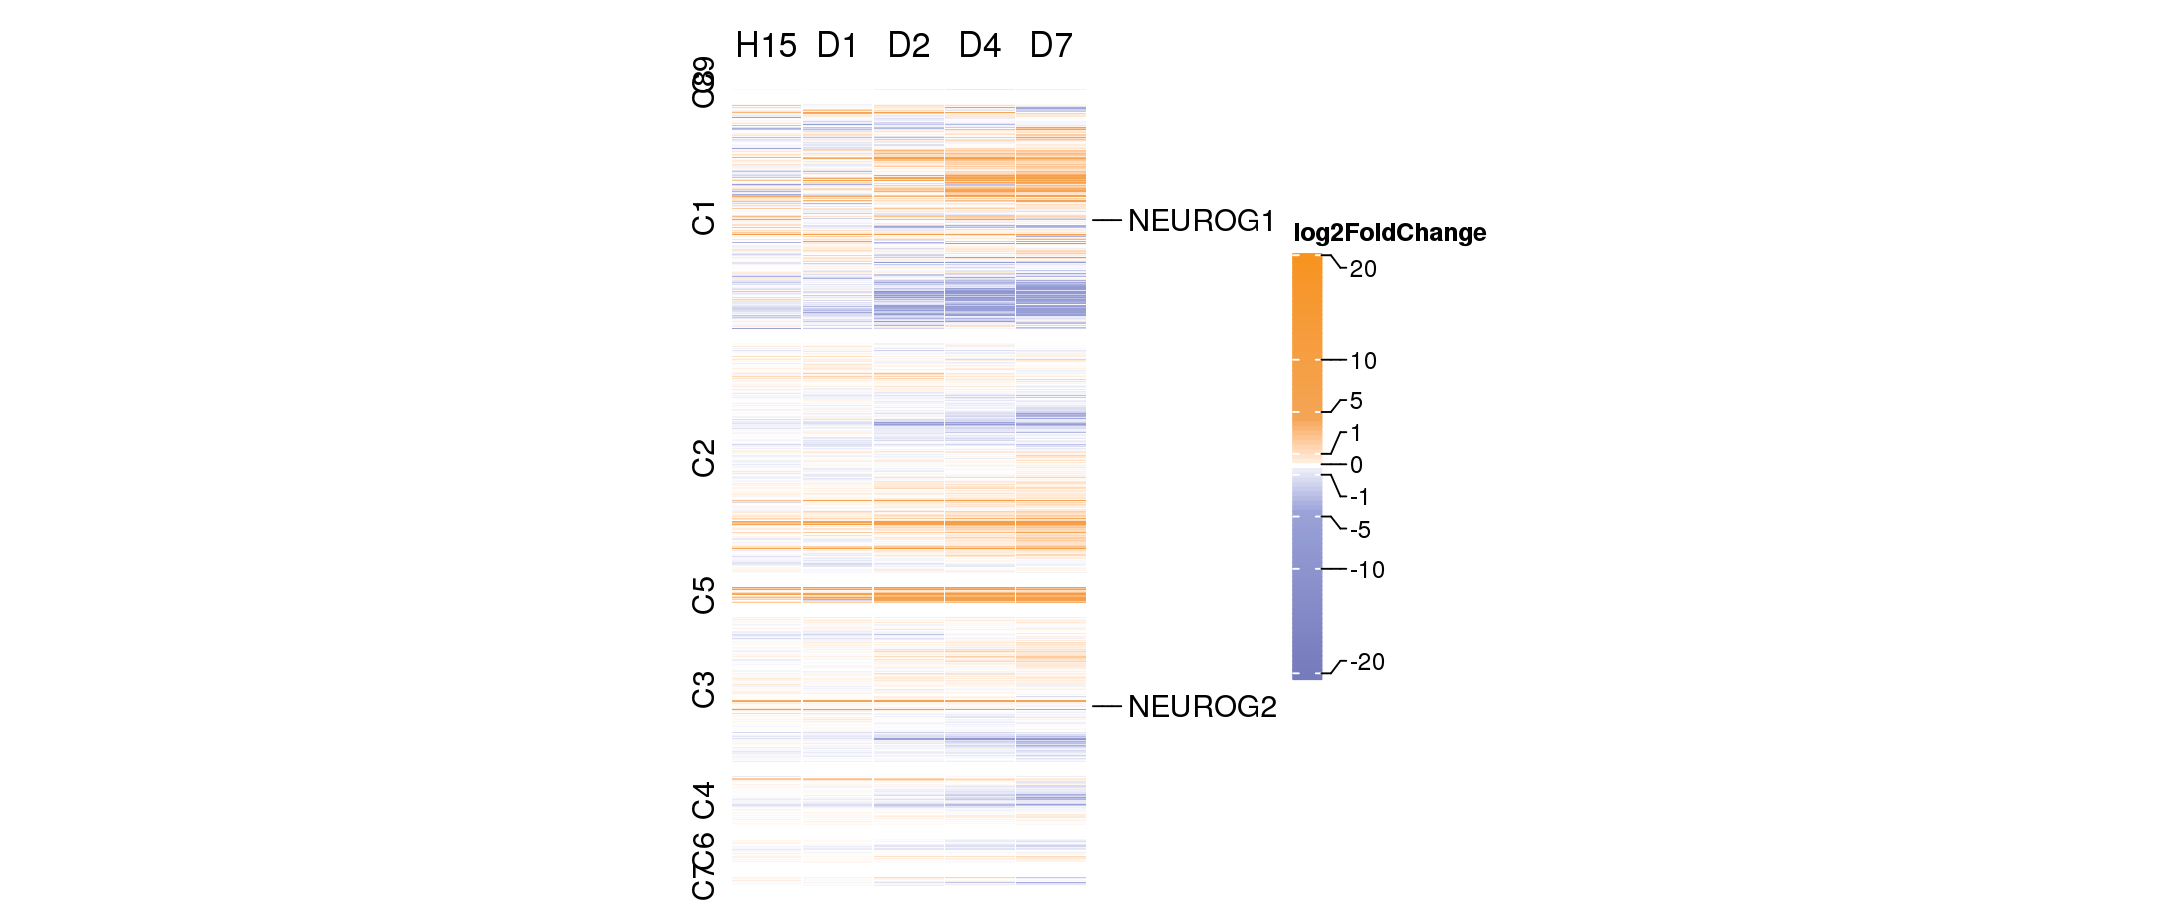

In [683]:
#pdf("TF_RNAseq_Clusters_heatmap_9x_fc.pdf", width = 8, height = 8)
Heatmap(TF.mx.fc[ht1.ordered.rows, ], 
                show_column_names = F, show_row_names = F,
                cluster_rows = F, cluster_columns = F,         # do not cluster. Use ordered Heatmap results
                row_labels = gene.labels[ht1.ordered.rows], row_split = gene.clusters, row_gap = unit(2, "mm"), row_title_gp = gpar(fontsize = 12),
                column_labels = sample.labels, column_split = sample.labels2, column_gap = unit(0.2, "mm"), # split column
                col = col_fun2, width = unit(5, "cm"),
                right_annotation = ht1.an,
                heatmap_legend_param = list(title = "log2FoldChange", 
                                           at = c(-20, -10, -5, -1, 0, 1, 5, 10, 20),
                                           legend_height = unit(6, "cm"))
        )
#dev.off()

## Plot heatmap for neuronal marker genes

In [39]:
gs1 <- add_column(rna_fc, gene_name = rna_data$D1_vs_ES$gene_name, .before = "H15") %>%
            filter(gene_name %in% c('MAP2','TUBB3', 'NANOG', 'SOX2',  'POU5F1')) %>%
            column_to_rownames("gene_name") %>%
            as.matrix

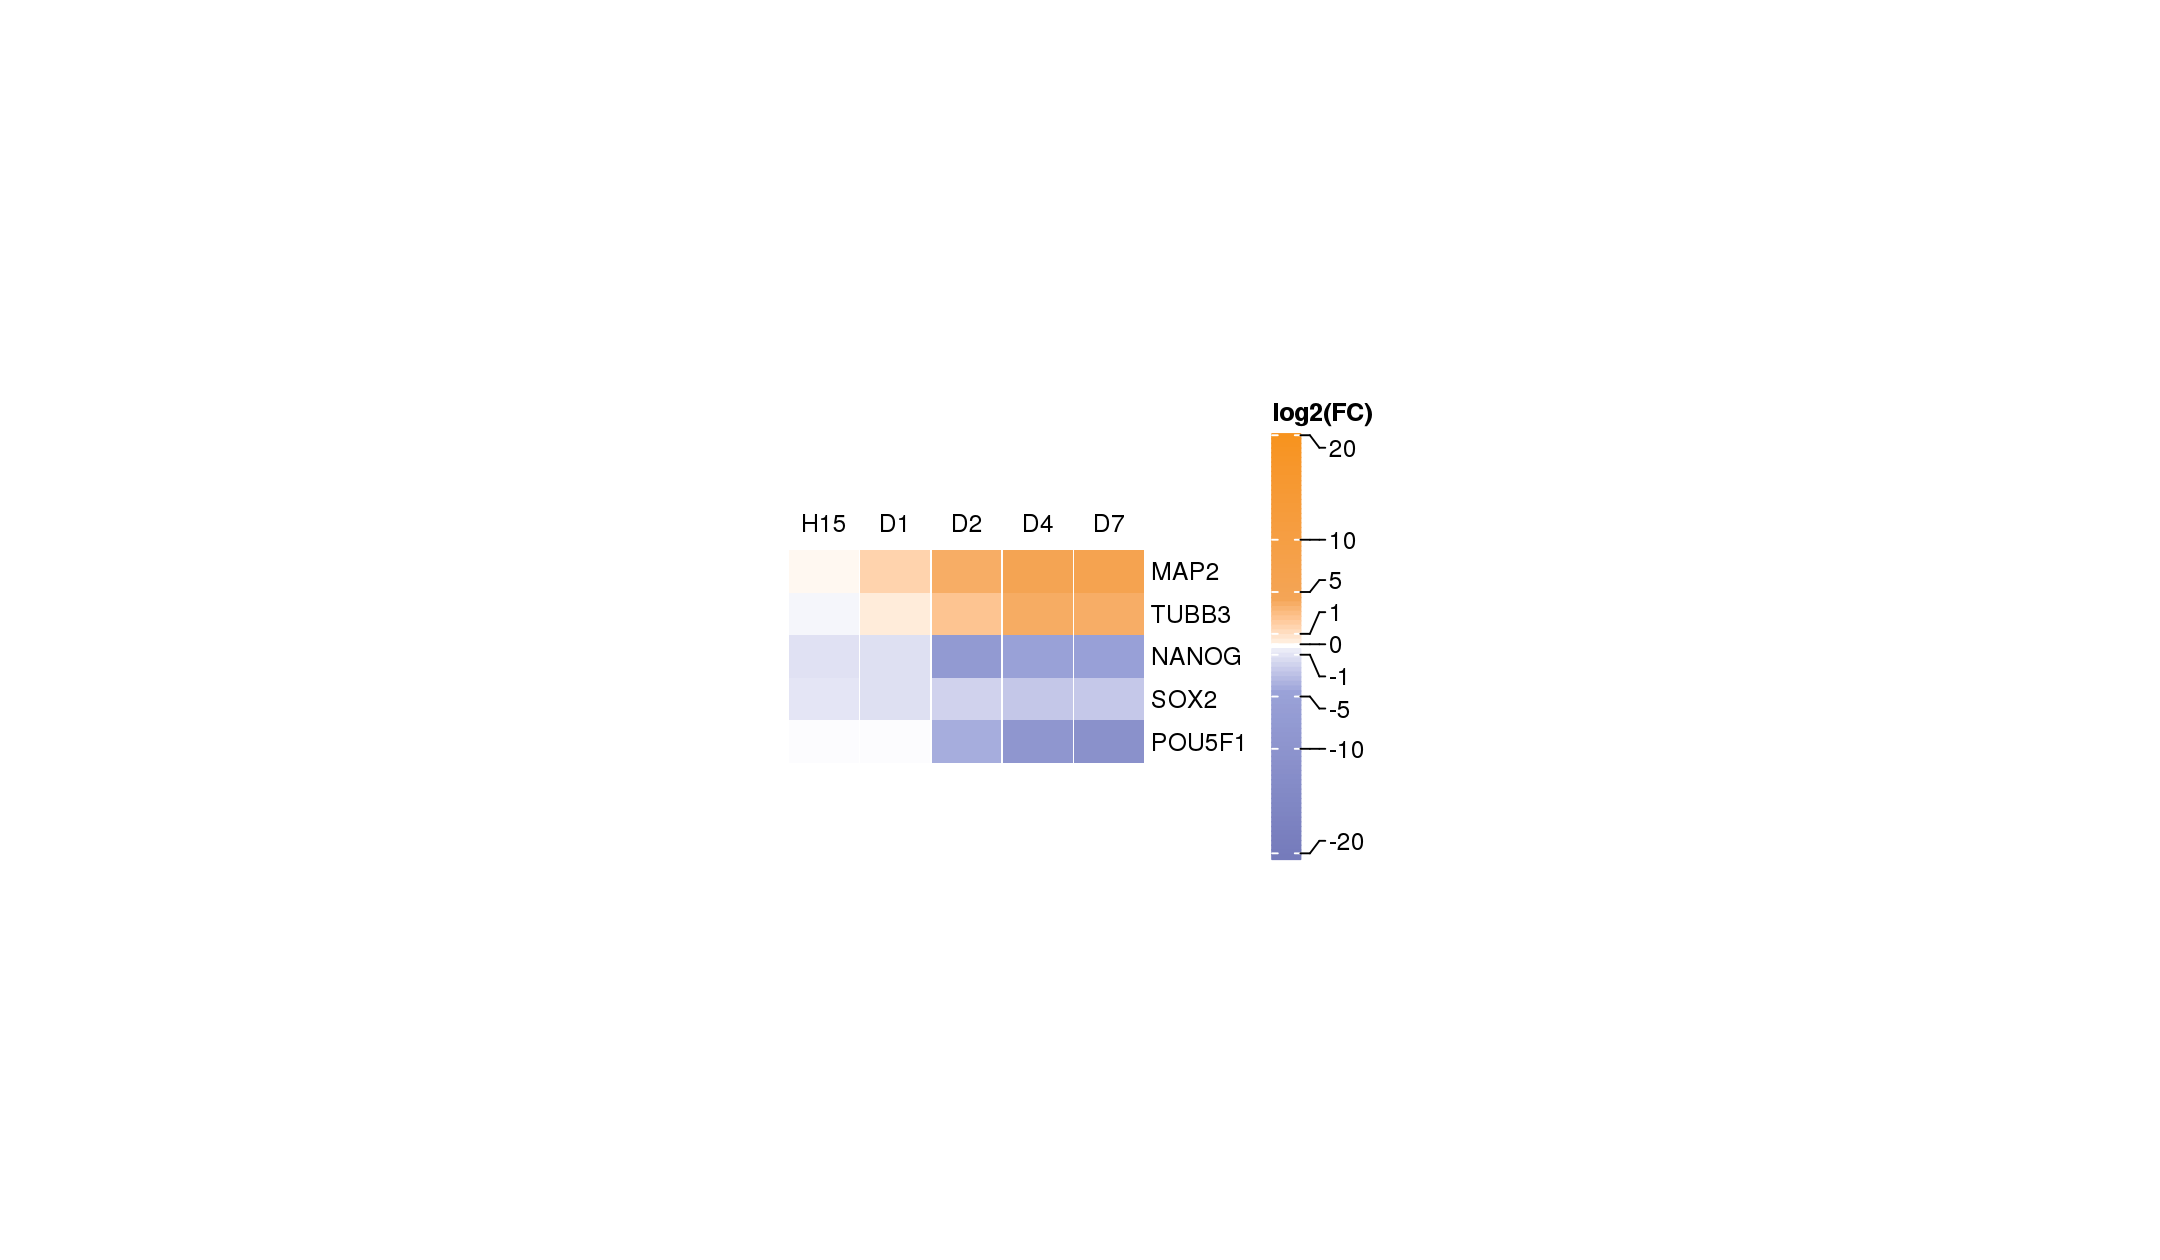

In [40]:
#pdf("TF_RNAseq_NeuralMarkers_heatmap.pdf", width = 7, height = 7)
Heatmap(gs1[c('MAP2','TUBB3', 'NANOG', 'SOX2',  'POU5F1'),], # enforce specific row order
               column_title_gp = gpar(fontsize = 10), row_names_gp = gpar(fontsize = 10),
               show_column_names = F, show_row_names = T, 
               cluster_rows = F, cluster_columns = F, 
               column_split = sample.labels2, column_gap = unit(0.2, "mm"), # split column
               width = unit(5, "cm"), height = unit(3, "cm"),
               col = col_fun2, 
               heatmap_legend_param = list(title = "log2(FC)", at = c(-20, -10, -5, -1, 0, 1, 5, 10, 20),
                                           legend_height = unit(6, "cm"))
              )
#dev.off()

# Find Each cluster's targets

In [109]:
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [200]:
# bringing in computed regulatr-target for all protein coding genes
TF.targets <- fread("neuron_tf/regulator_to_target_allJaspar_allProteinCodingGenes.csv")

In [202]:
# Keep only TF as regulators
TF.targets <- TF.targets[regulator_motif %in% tflist]
setindex(TF.targets, regulator_motif, target_gene)

In [204]:
tic()

In [205]:
# compute rowsum: total readcounts across 12 samples
TF.targets[, rowsum := rowSums(.SD), by = .(regulator_motif, target_gene)]

In [206]:
toc()

278.267 sec elapsed


In [215]:
TF.targets.percentiles <- quantile(TF.targets[, rowsum], probs = seq(0, 1, 0.01)) # diagnostic

In [224]:
TF.targets.percentiles[TF.targets.percentiles < 530] %>% print # diagnostic

 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 
 58 167 196 219 238 257 275 291 309 326 344 361 379 397 416 435 454 477 499 521 


In [242]:
# remove low read count interactions
TF.targets <- TF.targets[rowsum > 500]

In [243]:
head(TF.targets, 2)

regulator_motif,target_gene,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,rowsum
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
THRB,A3GALT2,115,83,93,119,159,190,129,129,307,207,138,142,1811
THRB,AADAT,219,143,181,155,174,267,161,249,432,262,445,373,3061


In [248]:
TF.targets[ht1.clusters.genes$C4, on = "regulator_motif"][, target_gene] %>% length %>% `/`(length(ht1.clusters.genes$C4))
TF.targets[ht1.clusters.genes$C1, on = "regulator_motif"][, target_gene] %>% length %>% `/`(length(ht1.clusters.genes$C1))

[1] 1467.75

[1] 660.1136

In [251]:
all.matched.motifs <- unique(TF.targets[, regulator_motif])

In [277]:
# for each cluster, get their protein coding gene targets (do not include TF)
ht1.clusters.PC.targets <- map(ht1.clusters.genes, ~ TF.targets[.x, on = "regulator_motif"][, target_gene] %>%  # first get each cluster's gene sets
                                unique %>% .[!is.na(.)] %>% # remove duplicates and NA values
                                setdiff(., tflist))

In [451]:
# for each cluster, number of target protein coding genes per matched motif
df <- map2(ht1.clusters.PC.targets, ht1.clusters.genes,  ~ length(.x) / length(intersect(.y, all.matched.motifs))) %>% t
df <- t(df)

In [454]:
df <- data.frame(cluster = rownames(df), value = unlist(df))

In [ ]:
c("#757BBB", '#9AA2D8', "#FFFFFF","#F4A556", "#F7931E"))

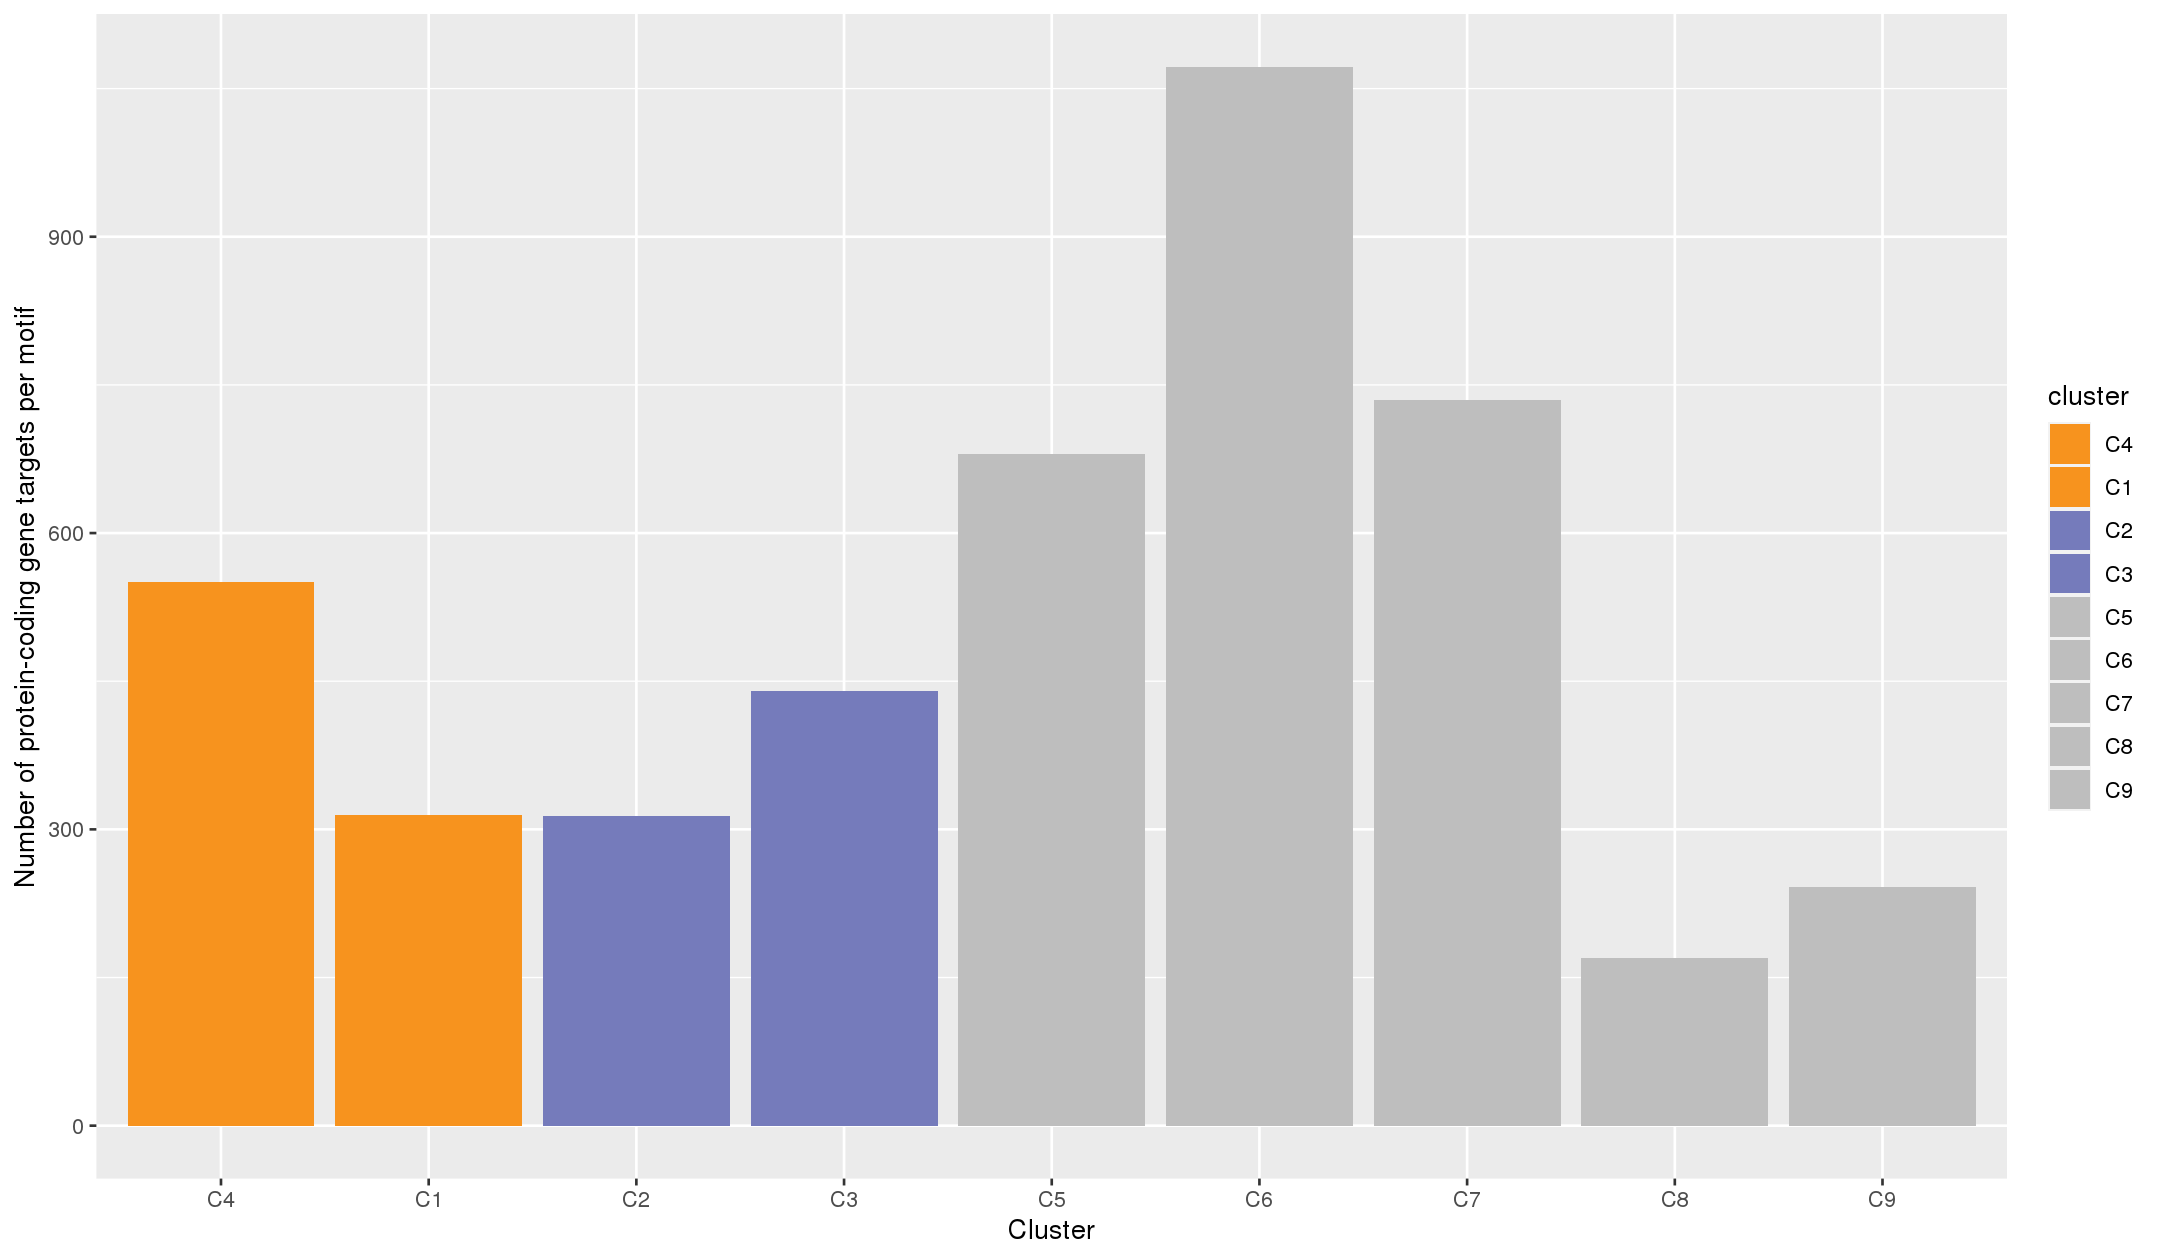

In [465]:
mutate_at(df, "cluster", ~ factor(.x, levels = c('C4','C1','C2','C3','C5','C6','C7','C8','C9'))) %>%
    ggplot() + geom_col(aes(cluster, value,fill = cluster)) + 
        scale_fill_manual(values = c(C4 = '#F7931E', C1 = '#F7931E', C2 = '#757BBB', C3 = '#757BBB',
                                     C5 = 'grey', C6 = 'grey', C7 = 'grey', C8 = 'grey', 
                                     C9 = 'grey')) +
        labs(x = "Cluster", y = "Number of protein-coding gene targets per motif")

In [388]:
str(ht1.clusters.PC.targets)

List of 9
 $ C4: chr [1:14303] "AAK1" "ABCB4" "ABHD11" "ABHD6" ...
 $ C5: chr [1:14290] "ABI2" "AC002310.4" "AC005702.1" "AC007040.2" ...
 $ C6: chr [1:13939] "AAK1" "AAMDC" "AAR2" "AARSD1" ...
 $ C7: chr [1:13965] "AANAT" "AATK" "ABAT" "ABCA1" ...
 $ C8: chr [1:14759] "A3GALT2" "A4GALT" "AAAS" "AACS" ...
 $ C9: chr [1:14742] "AACS" "AAK1" "AANAT" "AARS2" ...
 $ C1: chr [1:14468] "A2ML1" "A3GALT2" "AARSD1" "AATF" ...
 $ C2: chr [1:14728] "ABCA3" "ABCA4" "ABCB9" "ABCG1" ...
 $ C3: chr [1:14539] "AACS" "AAMDC" "ABCA1" "ABCA3" ...


In [425]:
upset.ht1.dist <- make_comb_mat(ht1.clusters.PC.targets, mode = "distinct")

In [426]:
upset.ht1.int <- make_comb_mat(ht1.clusters.PC.targets, mode = "intersect")

In [417]:
set_name(upset.ht1)
comb_name(upset.ht1) %>% str

[1] "C4" "C5" "C6" "C7" "C8" "C9" "C1" "C2" "C3"

 chr [1:511] "100000000" "010000000" "001000000" "000100000" "000010000" ...


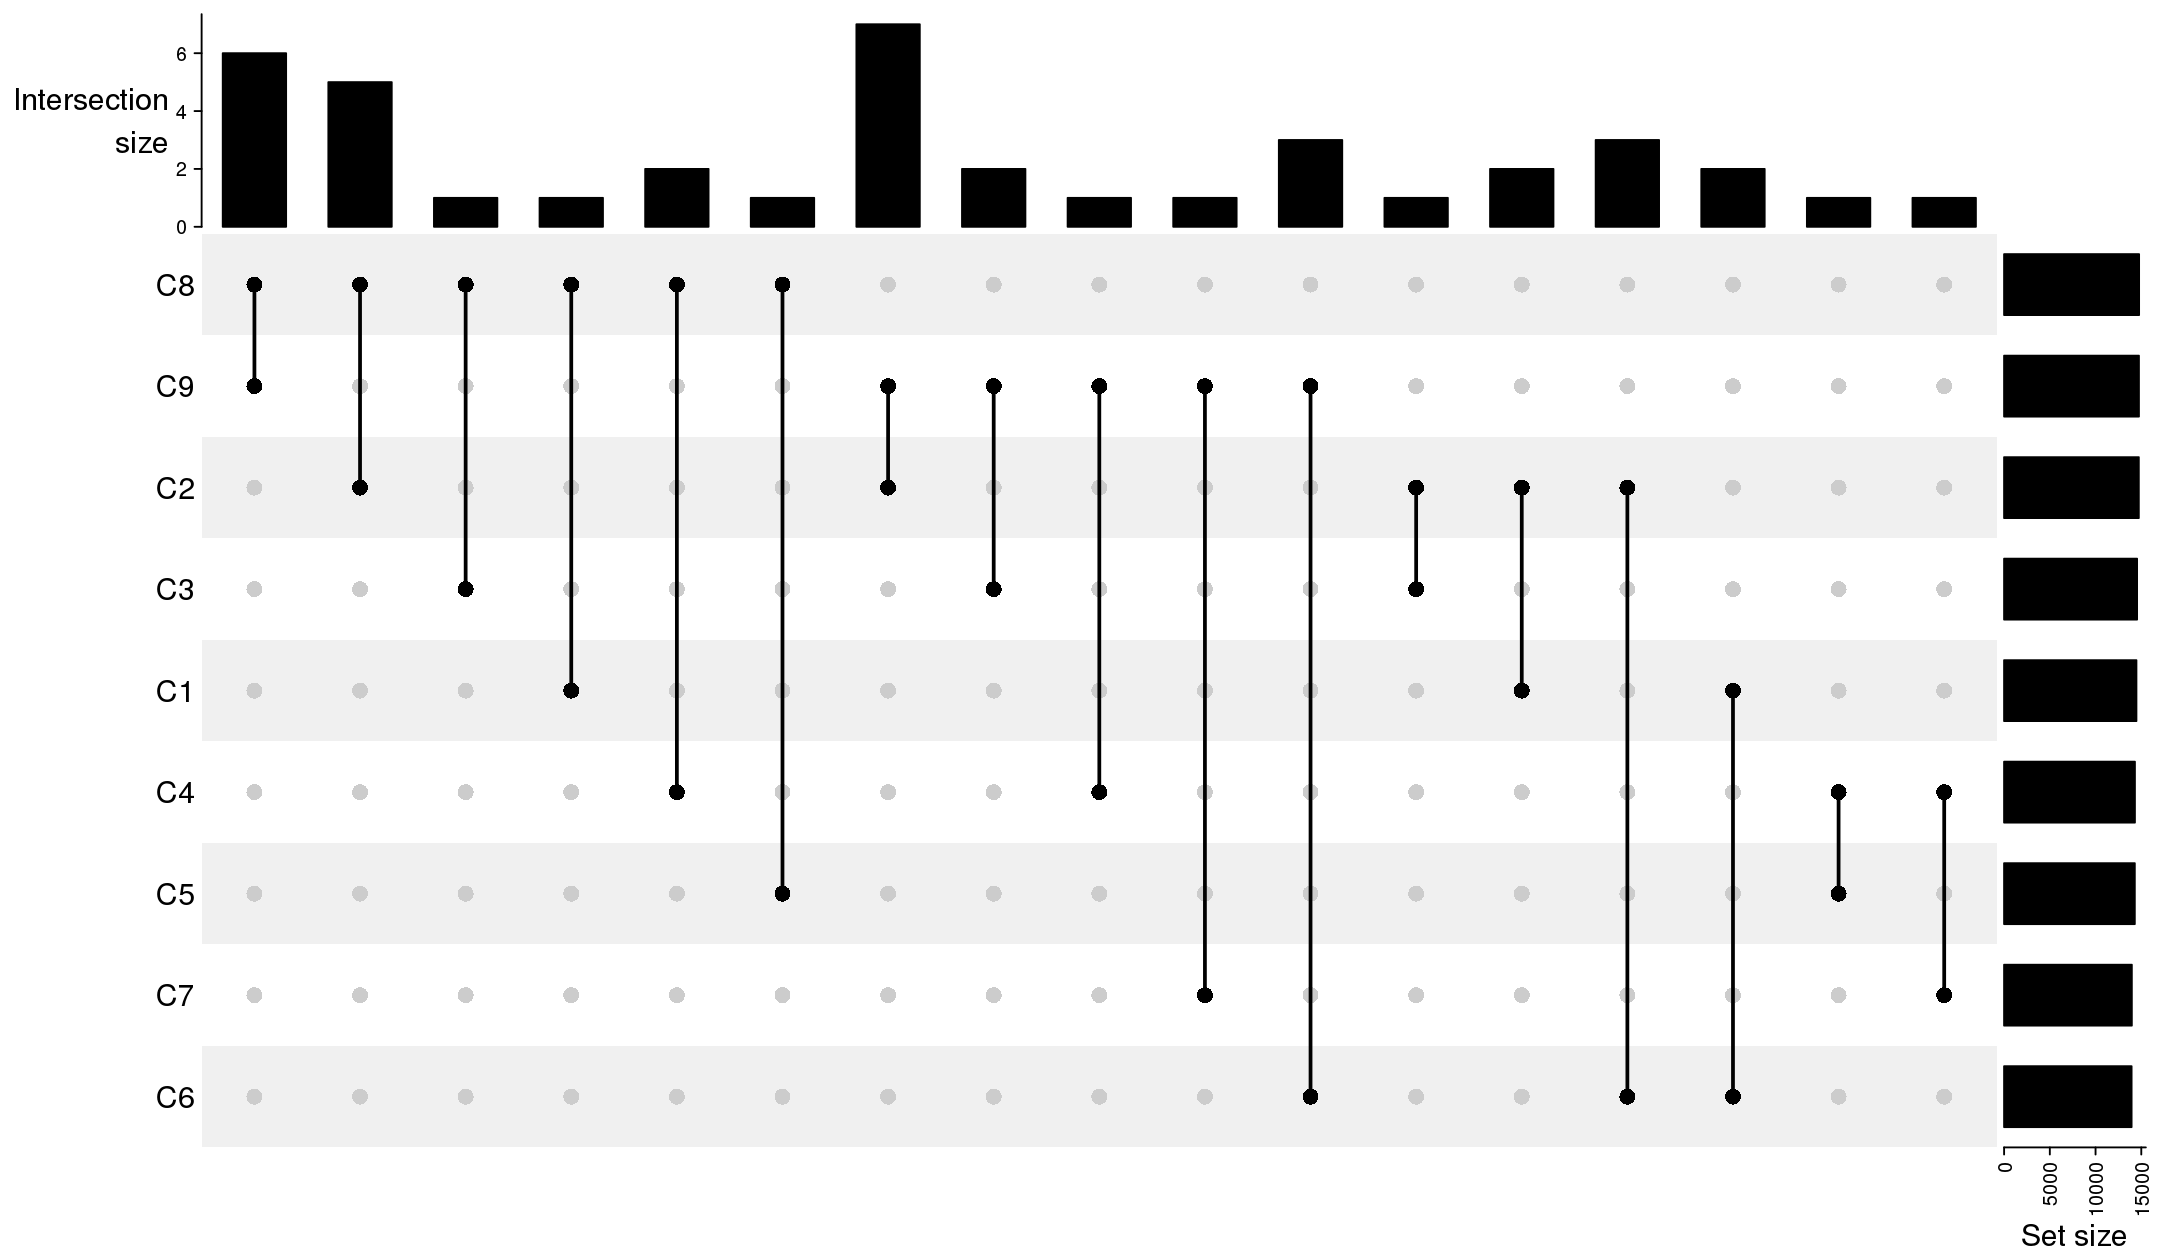

In [484]:
UpSet(upset.ht1.dist[comb_degree(upset.ht1.dist)  == 2])

In [488]:
upset.ht1.int[comb_degree(upset.ht1.int)  == 9] %>% comb_size

111111111 
    12626

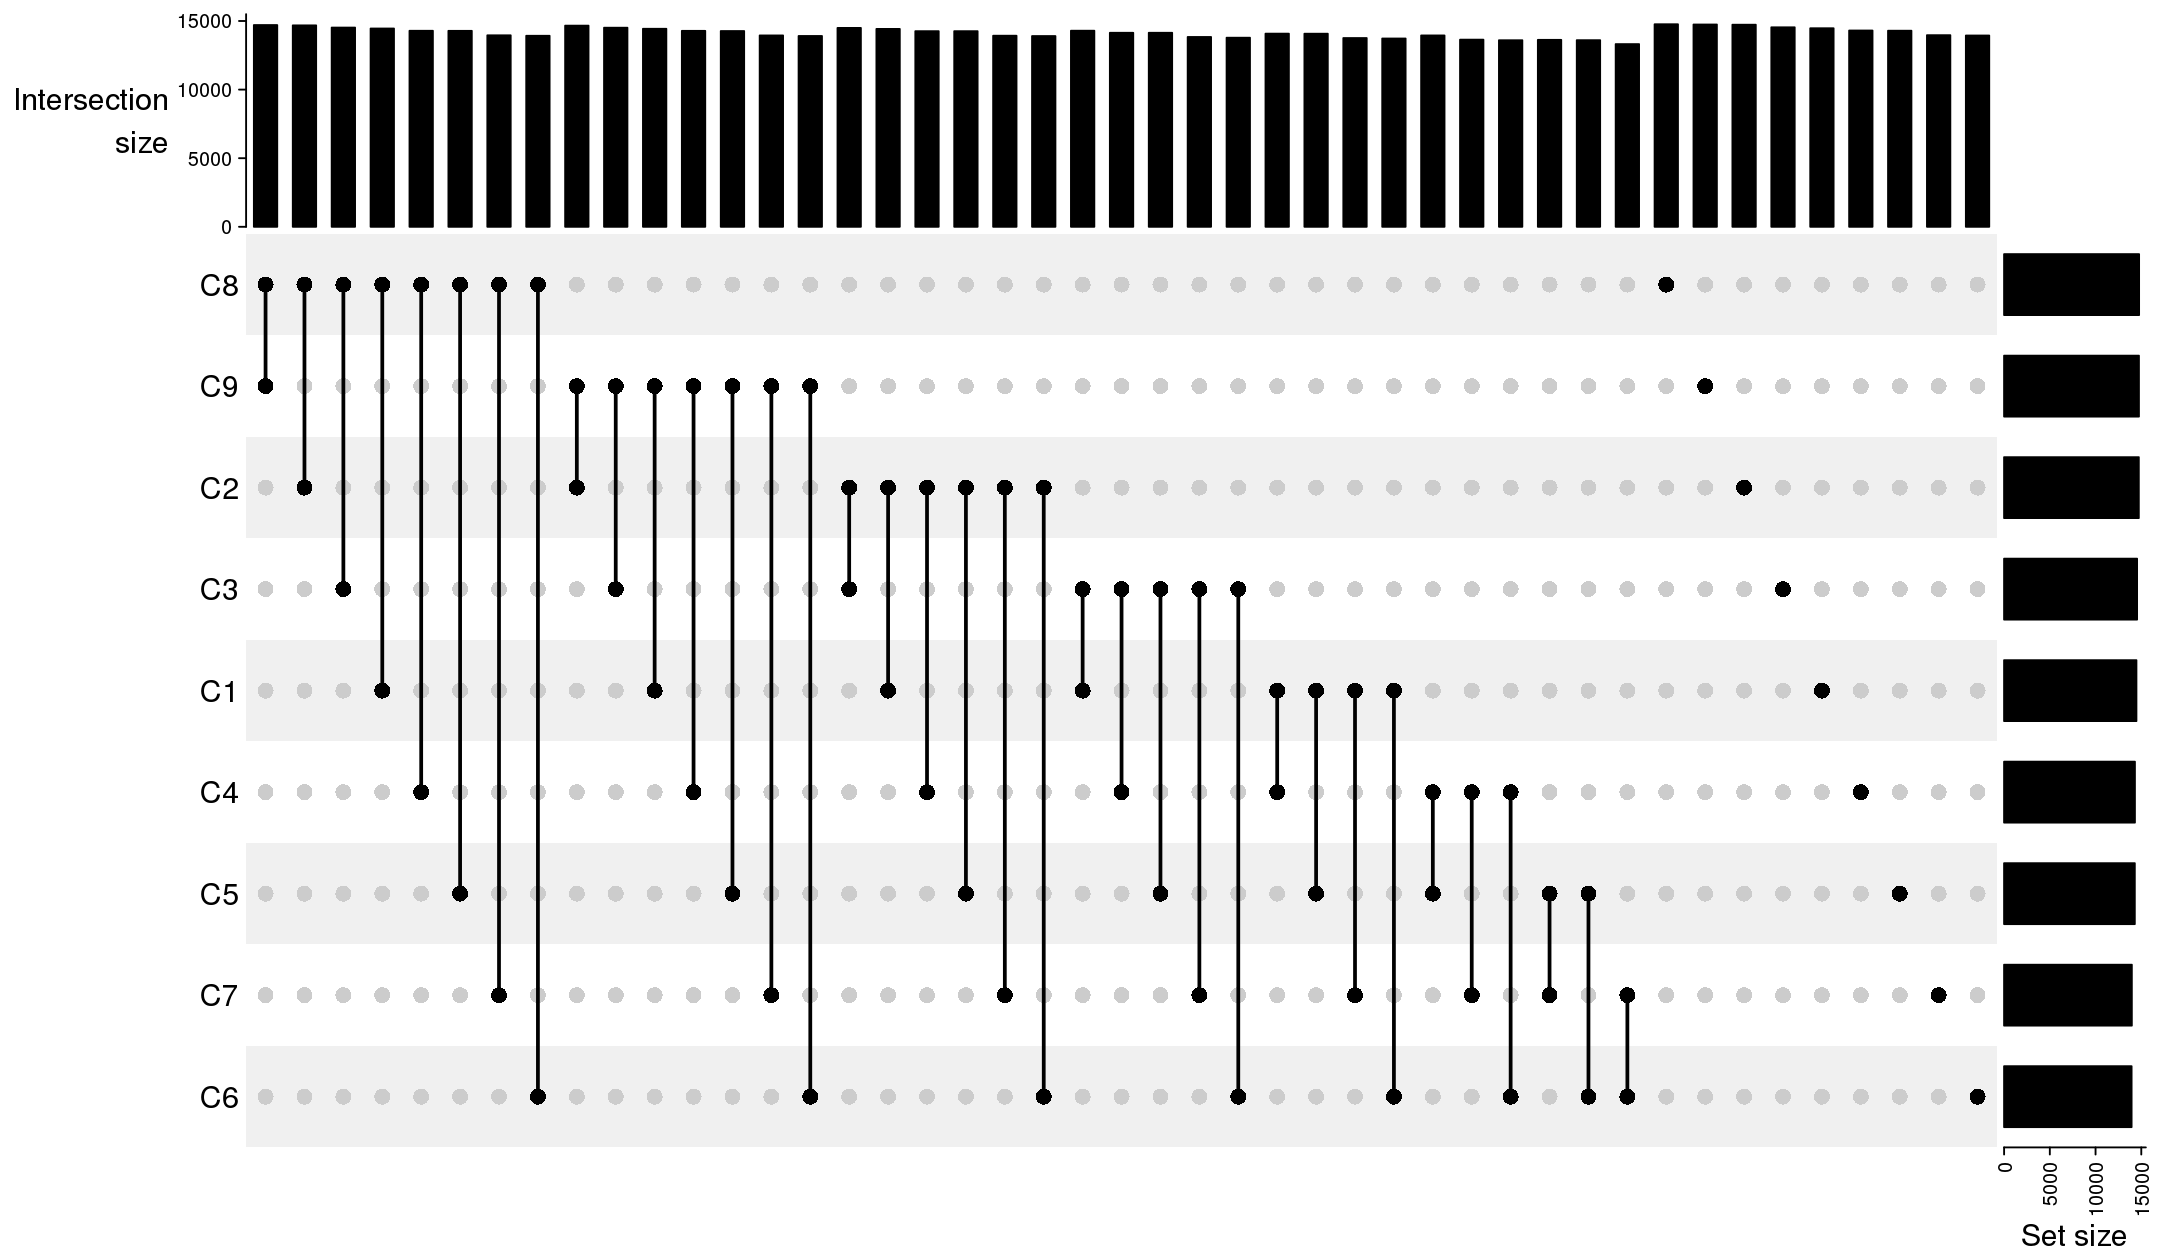

In [490]:
UpSet(upset.ht1.int[comb_degree(upset.ht1.int)  <=2])

# replot with just 5 conditions, and cluster based on average

## Plot heatmap without replicates


In [1022]:
map2(ht1.clusters, names(ht1.clusters), ~ rep(.y, length(.x))) %>% flatten %>% unlist %>% length

[1] 1588

---

# Plot heatmap with motif clusters

Group TFs into groups based on their motif clusters: 
https://www.vierstra.org/resources/motif_clustering#v10-2020-4-14

In [31]:
motif_cluster_anno <- readxl::excel_sheets("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/motif_annotations.xlsx")
names(motif_cluster_anno) <- motif_cluster_anno
motif_cluster_anno <- map(motif_cluster_anno, ~ readxl::read_xlsx("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/motif_annotations.xlsx", 
                                                                  sheet = .x))

In [32]:
# extract gene symbol from motif names, dimers (e.g. SMAD2+SMAD3) are removed
motif_cluster_anno2 <- motif_cluster_anno$Motifs %>% select(Cluster_ID, Motif) %>%
                         mutate_at("Motif", toupper) %>% 
                         mutate(gene = str_extract(string = Motif, pattern = "(^[0-9A-Z\\-]+)")) %>%
                         select(-Motif) %>% unique

In [33]:
# some TFs belong to multiple clusters, only choose 1 cluster
motif_cluster_anno2 <-  group_by(motif_cluster_anno2, gene) %>%
                            mutate(myrank = rank(Cluster_ID)) %>%
                            filter(myrank == 1) %>% 
                            select(Cluster_ID, gene) %>%
                            unique

In [34]:
motif_cluster_anno2 <- left_join(motif_cluster_anno2, motif_cluster_anno[[1]][,1:3], by = "Cluster_ID") %>% select(-Name)

In [35]:
head(motif_cluster_anno2)

Cluster_ID,gene,DBD
<dbl>,<chr>,<chr>
1,LHX6,homeodomain
1,LHX8,homeodomain
2,LHX2,homeodomain
2,LHX3,homeodomain
2,NOBOX,homeodomain
2,DLX3,homeodomain


In [36]:
as.data.frame(TF.mx.fc) %>% 
                        rownames_to_column("gene_id") %>% 
                        add_column(gene = gene.labels, .before = "H15") %>% head

,gene_id,gene,H15,D1,D2,D4,D7
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000001167.14,NFYA,0.2890018,0.73432596,0.06603903,0.03756645,0.3375069
2,ENSG00000004848.8,ARX,2.8463614,3.94553761,4.77977107,5.11679947,4.3334913
3,ENSG00000005007.12,UPF1,0.1094467,-0.01661123,-0.14105763,-0.39776214,-0.8239348
4,ENSG00000005075.15,POLR2J,-0.2314939,-0.16227637,-0.08359487,0.03192261,-0.3318751
5,ENSG00000005302.18,MSL3,1.2698475,0.59125381,0.91604210,1.22717342,0.8511904
6,ENSG00000005339.14,CREBBP,0.7450358,0.58345564,0.42241680,0.08270241,0.6405656


In [37]:
motif.cluster.ht <- as.data.frame(TF.mx.fc) %>% 
                        rownames_to_column("gene_id") %>% 
                        add_column(gene = gene.labels, .before = "H15") %>%
                        inner_join(motif_cluster_anno2, by = "gene") %>% arrange(Cluster_ID)

In [38]:
motif.cluster.ht %>% select(-c(gene_id, Cluster_ID, DBD)) %>% column_to_rownames("gene") %>% as.matrix %>% t %>% .[,1:50]

,LHX6,ARX,ISL1,HOXA5,MEOX2,POU6F2,LHX2,VAX2,HOXB3,MSX2,⋯,NFYB,CUX2,ONECUT2,PAX3,CUX1,MEIS1,HOXD9,ARID3A,OTX2,CRX
H15,0.06391306,2.846361,3.212797,20.35110,3.7316469,4.226290,0.7297003,2.487386,0.3601652,0.9548148,⋯,-0.2932666,-0.14553320,0.6356711,3.375887,0.2040127,3.135641,3.755773,-0.8059161,0.7962568,0.48647906
D1,0.95259614,3.945538,3.893396,23.56692,-2.0604252,3.974894,-1.6969234,4.692860,2.8818834,-0.9674754,⋯,-0.9466207,0.72940934,3.3663210,5.050267,1.0950702,6.854428,4.028804,0.5383547,0.8426957,0.03741602
D2,-1.83339348,4.779771,9.182448,0.00000,-0.8432066,4.129171,2.6493038,5.290169,1.9426485,0.6727137,⋯,-0.6652894,-2.60491399,5.7360280,7.477993,0.6049614,5.154272,1.231701,1.3192111,0.6917831,1.03070350
D4,-5.75368283,5.116799,10.211195,0.00000,4.4582104,2.919401,5.0304244,6.828472,2.7974542,-2.8330009,⋯,-0.6290754,-0.06551911,5.8135490,7.396766,0.9469553,7.906467,3.567443,0.5093111,-0.7561289,1.12076368
D7,-5.65390909,4.333491,10.046671,20.68986,3.0423547,5.893515,4.0087132,7.718415,5.0854280,-0.7426919,⋯,-0.9726016,2.17701373,6.4674343,6.991854,1.0085287,8.501059,8.195494,-0.1726748,-1.9190468,1.71239240


In [39]:
# GE l2fc matrix by gene in row, time point in column 
motif.cluster.ht.mx <- select(motif.cluster.ht, -c(gene_id, Cluster_ID, DBD)) %>% column_to_rownames("gene") %>% as.matrix

In [41]:
# split genes into groups so it's easier to view heatmap
split.groups <- split(motif.cluster.ht$Cluster_ID, cut_number(motif.cluster.ht$Cluster_ID, 4))
split.groups.rownum <- map(split.groups, ~ which(motif.cluster.ht$Cluster_ID %in% .x))

In [42]:
motif.cluster.ht.mx[c(50, 59),]

,H15,D1,D2,D4,D7
CRX,0.48647906,0.03741602,1.030704,1.120764,1.712392
HNF4G,-0.05358661,-1.43375504,-4.832464,-1.946279,-4.353245


In [45]:
which(motif.cluster.ht$gene %in% sort(c("NEUROG2", "NEUROG1", "ZBTB18")))

[1] 148 149 158

In [48]:
col_fun2 <- colorRamp2(breaks = c(-20, -5, 0, 5, 20), c("#757BBB", '#9AA2D8', "#FFFFFF","#F4A556", "#F7931E"))

In [49]:
motifCluster.heatmap <- list()
for (i in 1:4) {
    cluster.ha <- HeatmapAnnotation(DBD = motif.cluster.ht$DBD[split.groups.rownum[[i]]])
    ht.i <- Heatmap(t(motif.cluster.ht.mx)[,split.groups.rownum[[i]]], cluster_rows = F, cluster_columns = T, name = as.character(i),
                show_row_names = T, show_column_names = T, 
                show_column_dend = F, bottom_annotation = cluster.ha,
                column_split = motif.cluster.ht$Cluster_ID[split.groups.rownum[[i]]], column_labels = motif.cluster.ht$gene[split.groups.rownum[[i]]],
                column_gap = unit(1, "mm"), column_title_gp = gpar(fontsize = 10), column_names_gp = gpar(fontsize = 7), 
                column_title_rot = 90,
                col = col_fun2, 
                heatmap_legend_param = list(title = "log2(FC)", at = c(-20, -10, -5, -1, 0, 1, 5, 10, 20),
                                               legend_height = unit(6, "cm"))
                )
    motifCluster.heatmap <- c(motifCluster.heatmap, ht.i)
}

In [493]:
pdf(paste0("figures/RNAseq_heatmap_byMotifCluster", ".pdf"), width = 14, height = 8)
for (i in 1:4) {
    #pdf(paste0("figures/RNAseq_heatmap_byMotifCluster_p",i, ".pdf"), width = 14, height = 7)
    draw(motifCluster.heatmap[[i]])
    #dev.off()
}
dev.off()

png 
  2

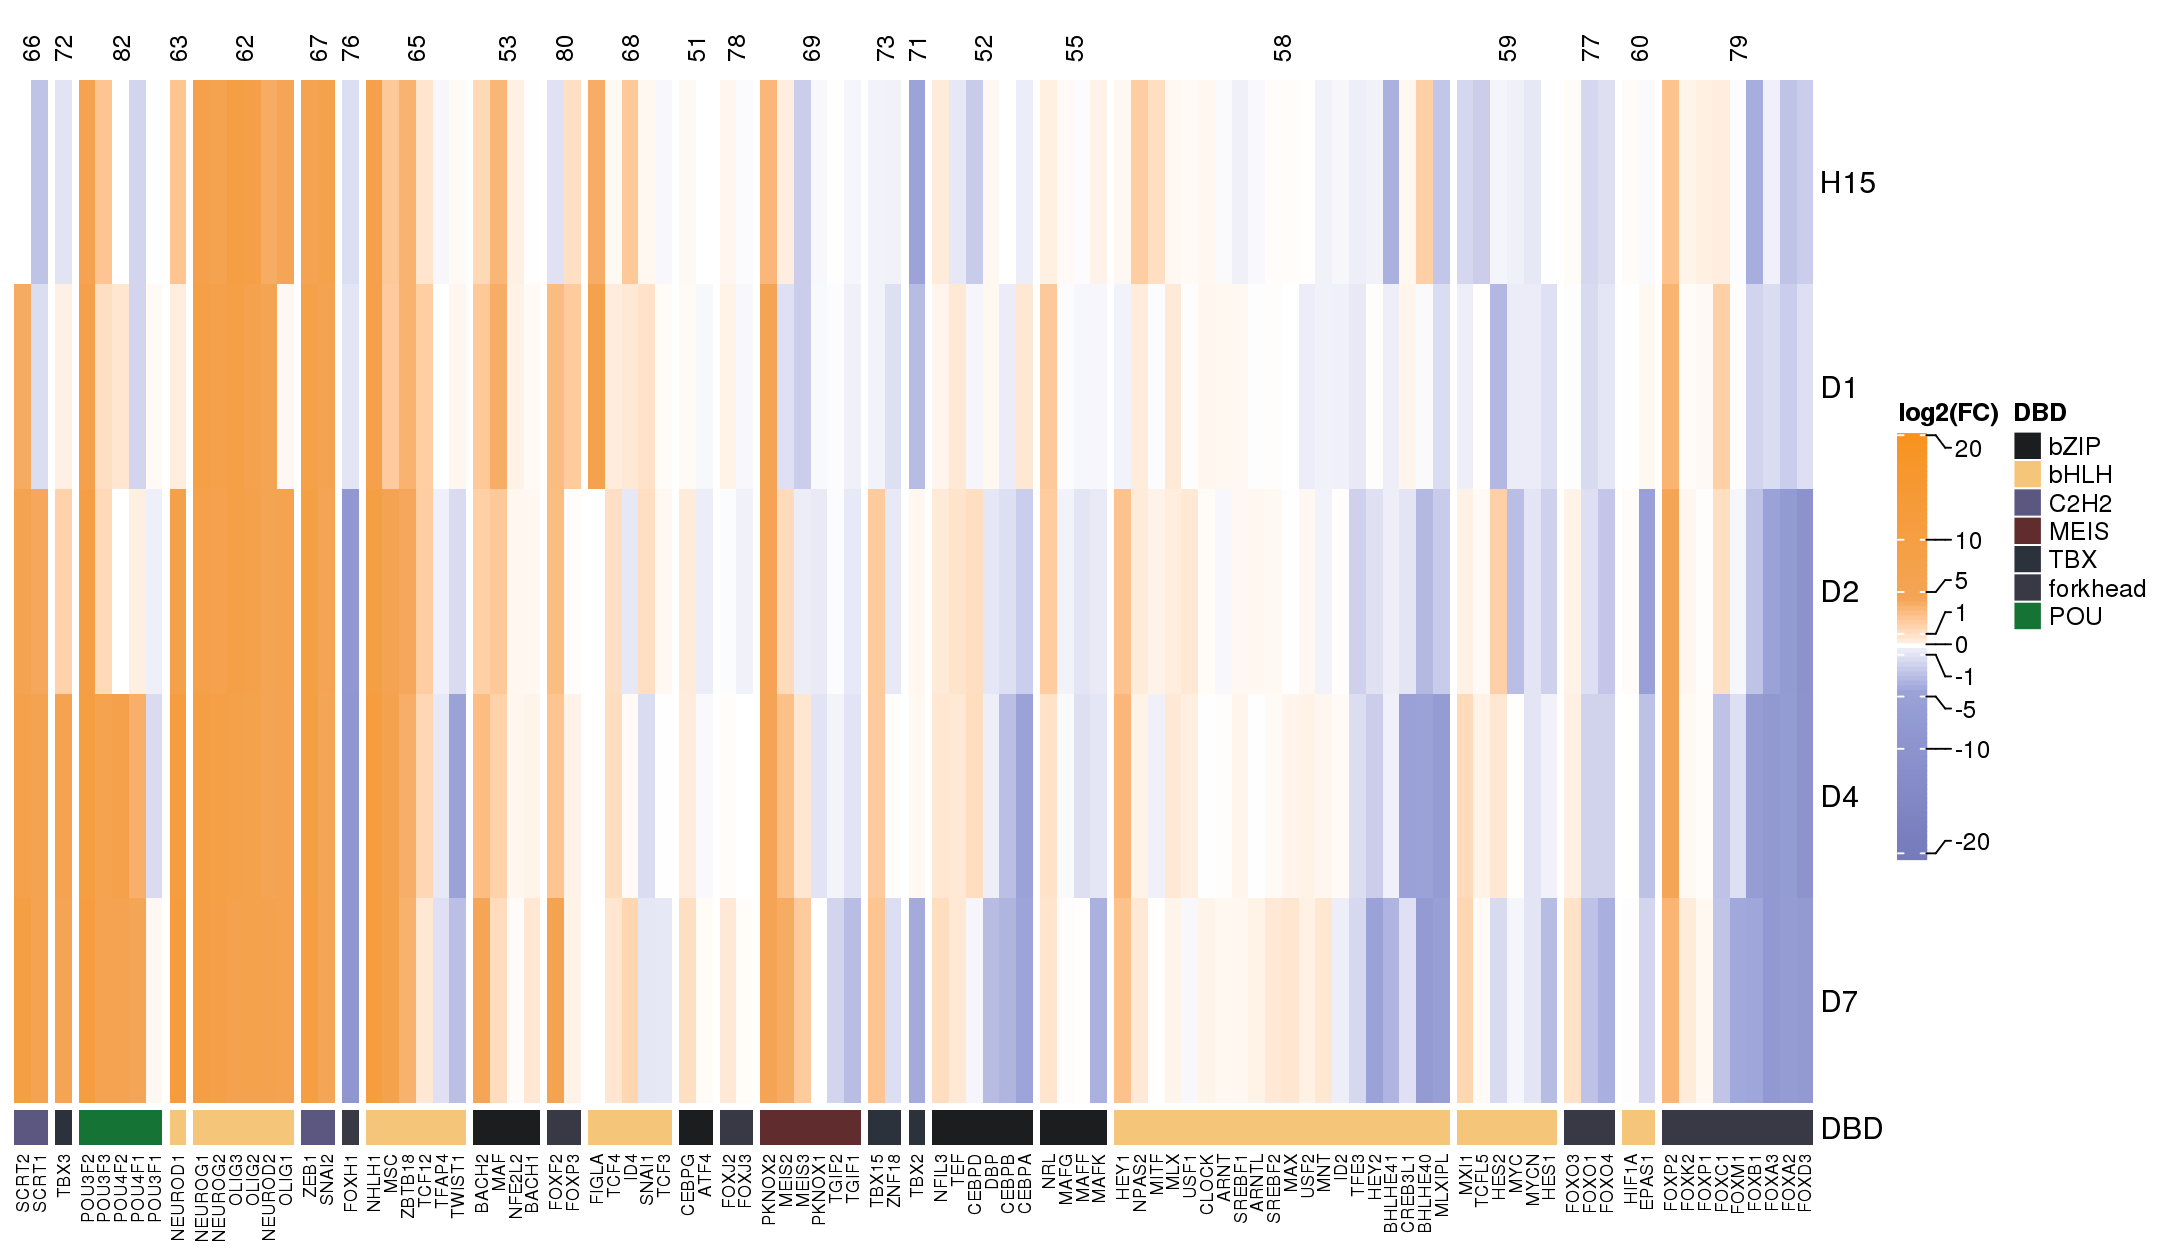

In [130]:
draw(motifCluster.heatmap[[2]])

In [372]:
cluster.ha <- HeatmapAnnotation(MotifCluster = as.character(motif.cluster.ht$Cluster_ID[split.groups.rownum[[1]]]),DBD = motif.cluster.ht$DBD[split.groups.rownum[[1]]])
Heatmap(t(motif.cluster.ht.mx)[,split.groups.rownum[[1]]], cluster_rows = F, cluster_columns = T, name = "Log2(Fold Change) vs. ES, clustered by motif DNA binding domain",
            show_row_names = T, show_column_names = T, 
            show_column_dend = F, bottom_annotation = cluster.ha,
            column_split = motif.cluster.ht$Cluster_ID[split.groups.rownum[[1]]], column_labels = motif.cluster.ht$gene[split.groups.rownum[[1]]],
            column_gap = unit(1, "mm"), column_title_gp = gpar(fontsize = 10), column_names_gp = gpar(fontsize = 7), 
            column_title_rot = 90,
            col = col_fun2, 
            heatmap_legend_param = list(title = "log2(FC)", at = c(-20, -10, -5, -1, 0, 1, 5, 10, 20),
                                           legend_height = unit(6, "cm"))
           )

## plot a subset of clusters with more than 4 TFs

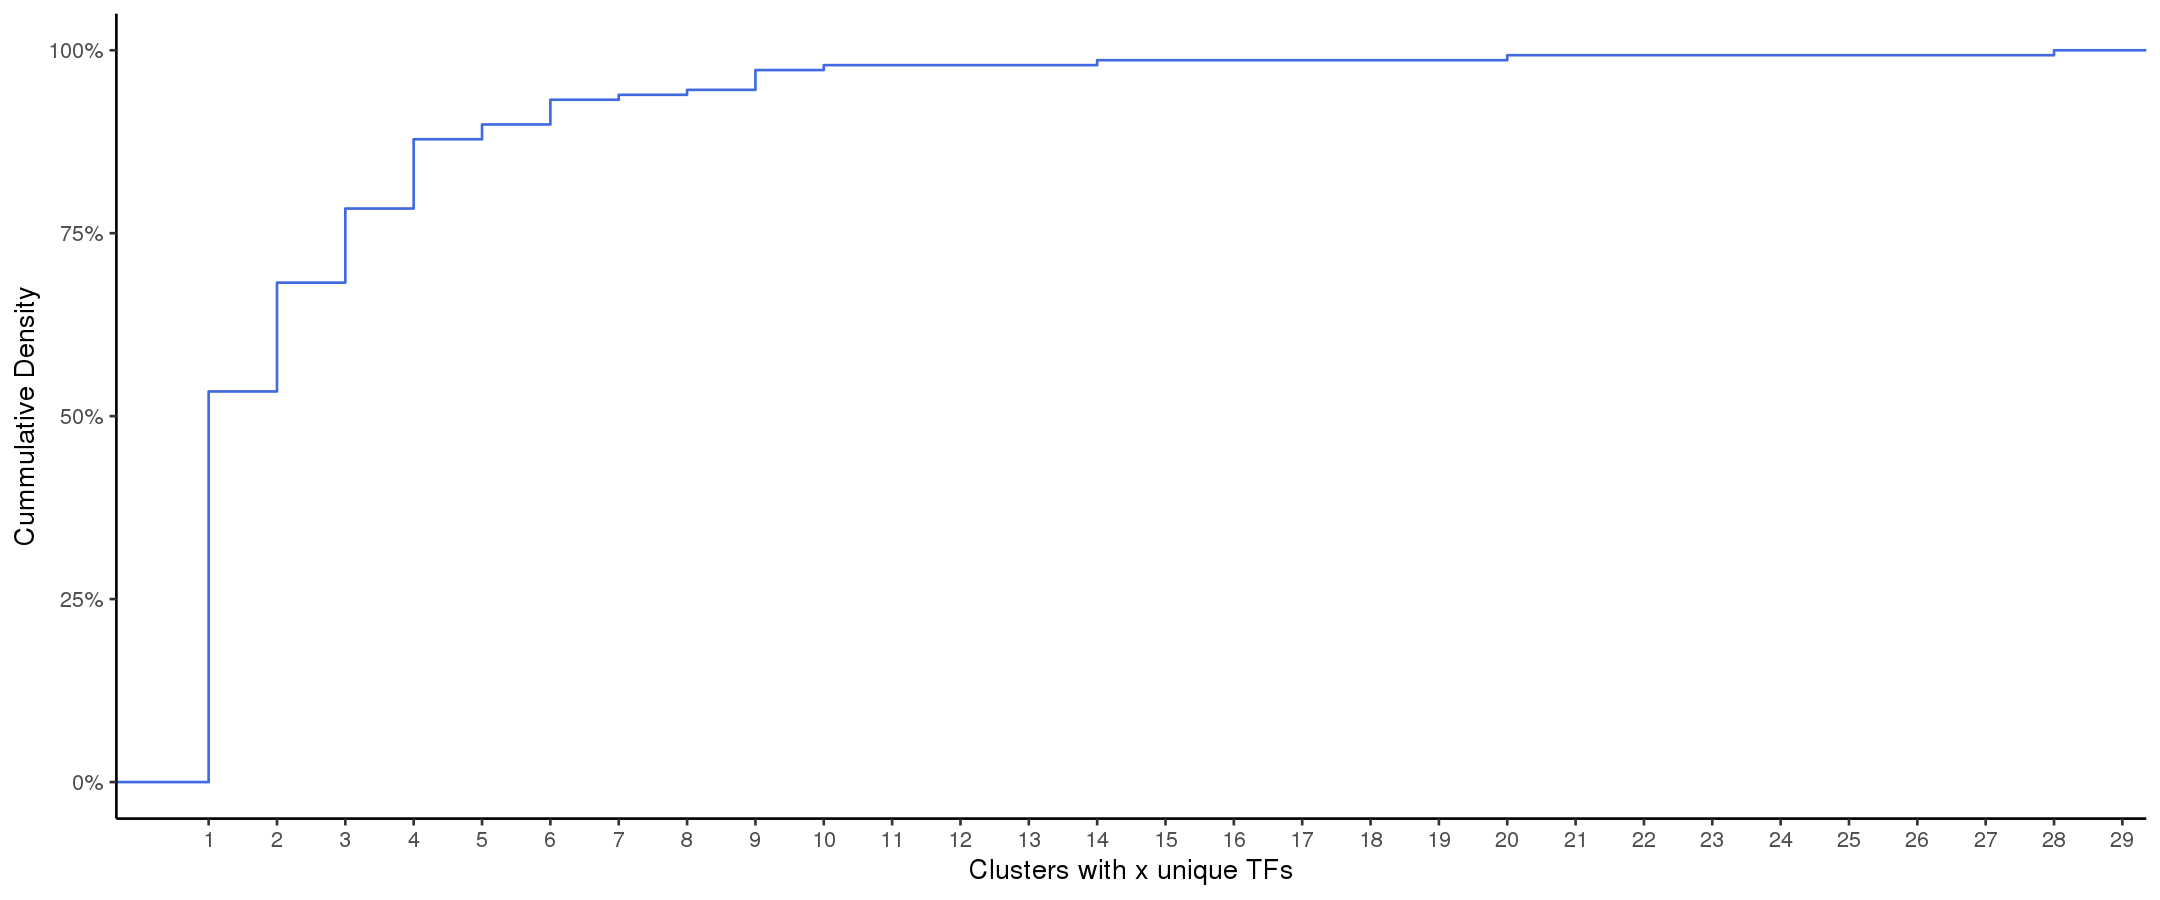

In [640]:
motif.cluster.ht %>% group_by(DBD, Cluster_ID) %>% add_count %>% select(Cluster_ID, DBD, n) %>% unique %>%
    ggplot() + stat_ecdf(aes(n), color = 'royalblue') + 
        scale_x_continuous(name = 'Clusters with x unique TFs', breaks = 1:30) +
        theme_classic() + 
        scale_y_continuous(name = 'Cummulative Density', labels = scales::percent)

In [563]:
kept.cluster.ids = motif.cluster.ht %>% group_by(DBD, Cluster_ID) %>% add_count %>% filter(n > 4) %>% pull(Cluster_ID) %>% unique

In [564]:
motif.cluster.kept = filter(motif.cluster.ht, Cluster_ID %in% kept.cluster.ids)

In [565]:
motif.cluster.kept %>% column_to_rownames('gene') %>% 
    group_by(Cluster_ID, DBD) %>% head
dim(motif.cluster.kept)

gene_id,H15,D1,D2,D4,D7,Cluster_ID,DBD
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000004848.8,2.8463614,3.945538,4.7797711,5.116799,4.333491,2,homeodomain
ENSG00000016082.15,3.2127969,3.893396,9.1824476,10.211195,10.046671,2,homeodomain
ENSG00000106004.5,20.3511004,23.566919,0.0000000,0.000000,20.689860,2,homeodomain
ENSG00000106511.6,3.7316469,-2.060425,-0.8432066,4.458210,3.042355,2,homeodomain
ENSG00000106536.19,4.2262896,3.974894,4.1291710,2.919401,5.893515,2,homeodomain
ENSG00000106689.11,0.7297003,-1.696923,2.6493038,5.030424,4.008713,2,homeodomain


[1] 168   9

In [568]:
motif.cluster.kept %>% select(-gene_id) %>% group_by(Cluster_ID, DBD) %>% pull(Cluster_ID) %>% unique 

[1]   2  30  49  50  52  58  59  62  65  68  69  79  82  89  96  98 109 156

In [569]:
motif.cluster.kept %>% select(-gene_id) %>% group_by(Cluster_ID, DBD) %>% nest %>% 
                            .$data %>% map(., ~ column_to_rownames(.x, 'gene') %>% 
                                           as.matrix %>% 
                                           t %>% 
                                           scale
                                           
                                           ) %>% .[[2]]

,NR1H3,NR1H2,RXRG,NR2F6,HNF4G,NR2F1,NR2C2,RXRA,RXRB
H15,0.8806209,0.5829446,-1.69369575,-1.3646441,1.2237024,-0.4530758,-0.9372310,-0.2093532,0.08387718
D1,0.4957931,-0.1497134,0.30748529,0.6994684,0.5400083,-0.7632742,-0.7480912,0.4961582,-1.68458403
D2,0.6233595,0.3542601,0.93763930,0.8773049,-1.1436105,-0.8944411,-0.2401051,1.4170508,0.20213928
D4,-0.4564846,0.8715981,0.05535958,0.5482775,0.2861195,1.3590324,0.3923314,-0.4980898,0.43824224
D7,-1.5432890,-1.6590895,0.39321159,-0.7604067,-0.9062197,0.7517587,1.5330960,-1.2057660,0.96032532


In [598]:
# use pearson correlation
motif.cluster.kept.dist = motif.cluster.kept %>% select(-gene_id) %>% group_by(Cluster_ID, DBD) %>% nest %>% 
                                .$data %>% map(., ~ column_to_rownames(.x, 'gene') %>% 
                                           as.matrix %>% 
                                           t %>% 
                                           scale %>% 
                                           lin.cor(method = 'pearson') %>% .[upper.tri(., diag = F)] %>% abs %>% median
                                           ) %>% unlist

In [599]:
names(motif.cluster.kept.dist) = select(motif.cluster.kept, -gene_id) %>% group_by(Cluster_ID, DBD) %>% pull(Cluster_ID) %>% unique 

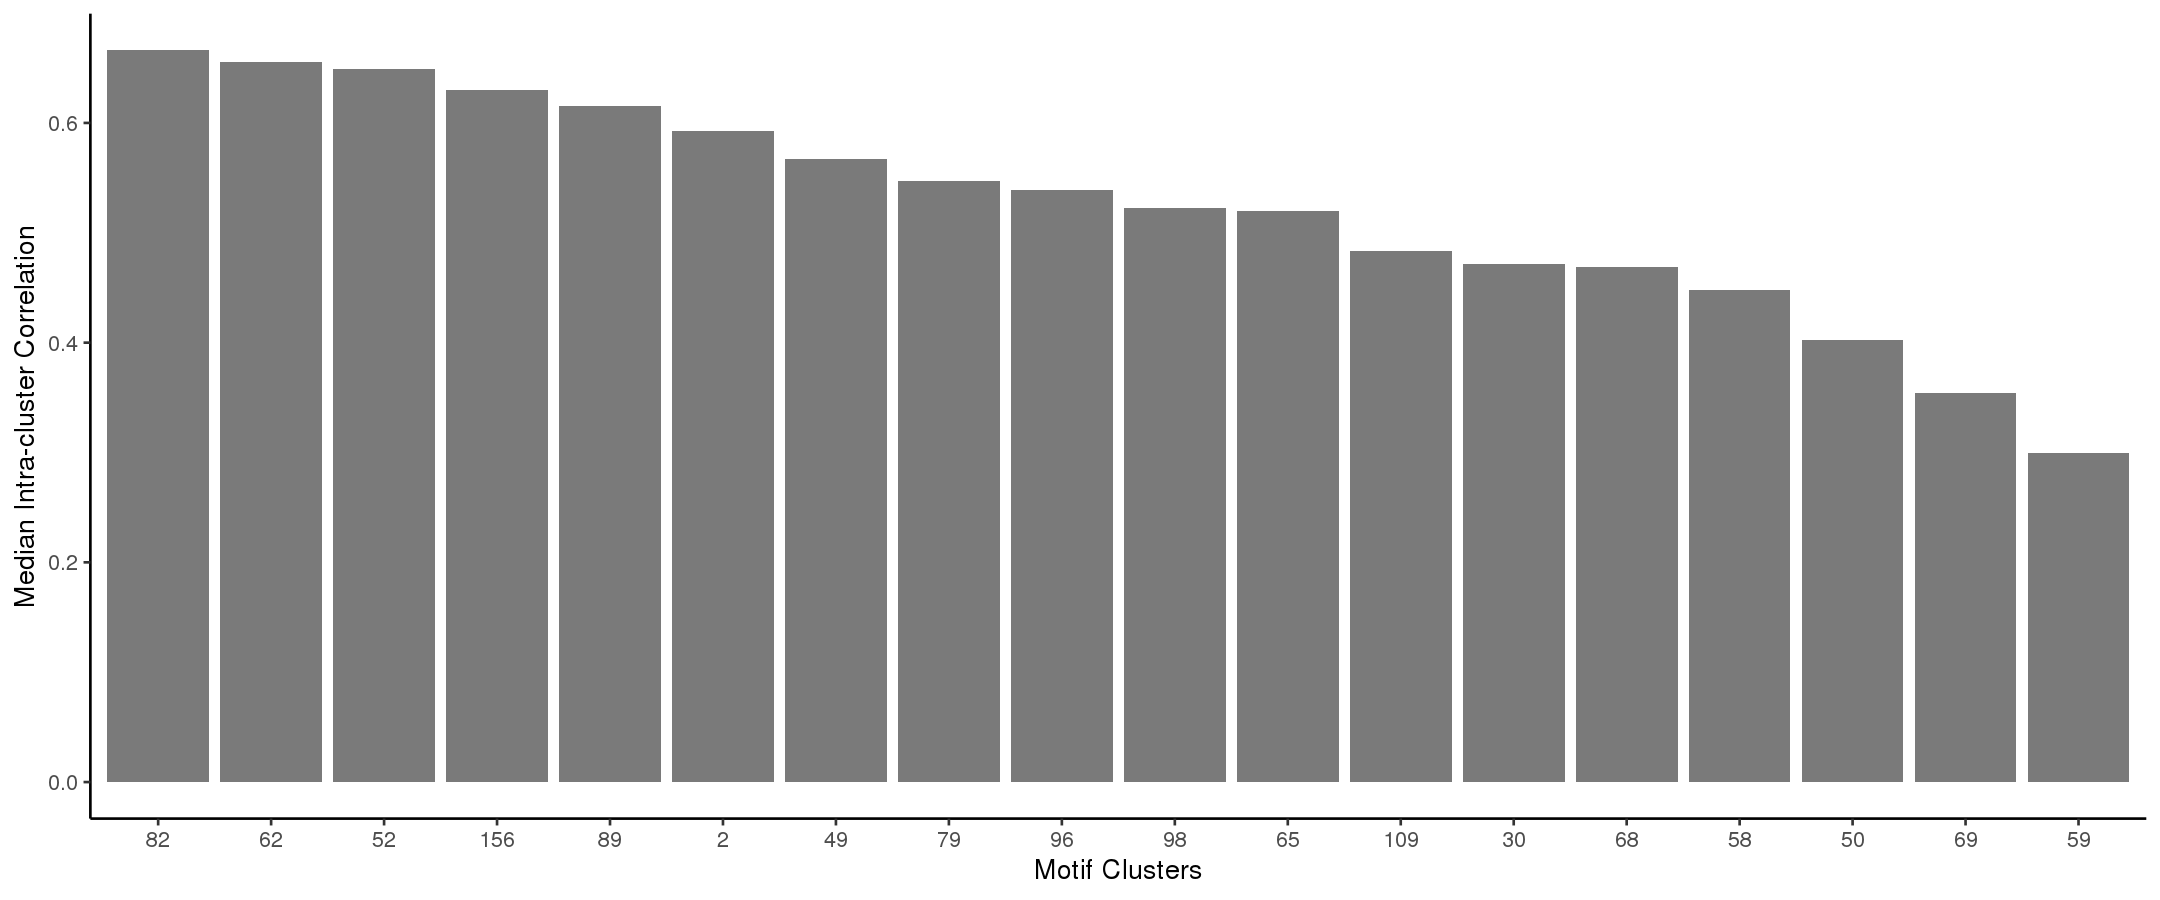

In [600]:
motif.cluster.kept.dist %>% enframe %>% ggplot() + geom_col(aes(x = fct_reorder(name, -value), value), alpha = .8) + 
    labs(x = 'Motif Clusters', y = 'Median Intra-cluster Correlation') + theme_classic()

In [585]:
motif.cluster.kept.data =  select(motif.cluster.kept, -gene_id) %>% group_by(Cluster_ID, DBD) %>% nest %>% .$data
names(motif.cluster.kept.data) = select(motif.cluster.kept, -gene_id) %>% group_by(Cluster_ID, DBD) %>% pull(Cluster_ID) %>% unique 

In [586]:
col_fun3 <- colorRamp2(breaks = c(-10, -5, 0, 5, 10), c("#757BBB", '#9AA2D8', "#FFFFFF","#F4A556", "#F7931E"))

In [602]:
# plot heatmap
motif.cluster.kept.ht = motif.cluster.kept.data %>% 
                        imap(., ~ column_to_rownames(.x, 'gene') %>% 
                             as.matrix %>% t %>% 
                             Heatmap(cluster_columns = T, column_km = 3, 
                                     show_column_dend = F, cluster_rows = F, col = col_fun3,
                                     column_title = paste0('Motif Cluster: ', .y)))

In [609]:
names(motif.cluster.kept.ht) = names(motif.cluster.kept.dist)

In [618]:
motif.cluster.kept.ht.order <- fct_reorder(names(motif.cluster.kept.ht), motif.cluster.kept.dist) %>% sort(decreasing = T)

In [634]:
motif.cluster.kept.ht.order %>% as.character 

[1] "82"  "62"  "52"  "156" "89"  "2"   "49"  "79"  "96"  "98"  "65"  "109"
[13] "30"  "68"  "58"  "50"  "69"  "59"

In [637]:
pdf(paste0("figures/RNAseq_heatmap_byMotifCluster_subset", ".pdf"), width = 10, height = 4)
walk(motif.cluster.kept.ht[as.character(motif.cluster.kept.ht.order)], draw)
dev.off()

png 
  2

In [643]:
motif.cluster.kept.dist[c('82', '62', '2', '58')]

82        62         2        58 
0.6661546 0.6558624 0.5928272 0.4475808

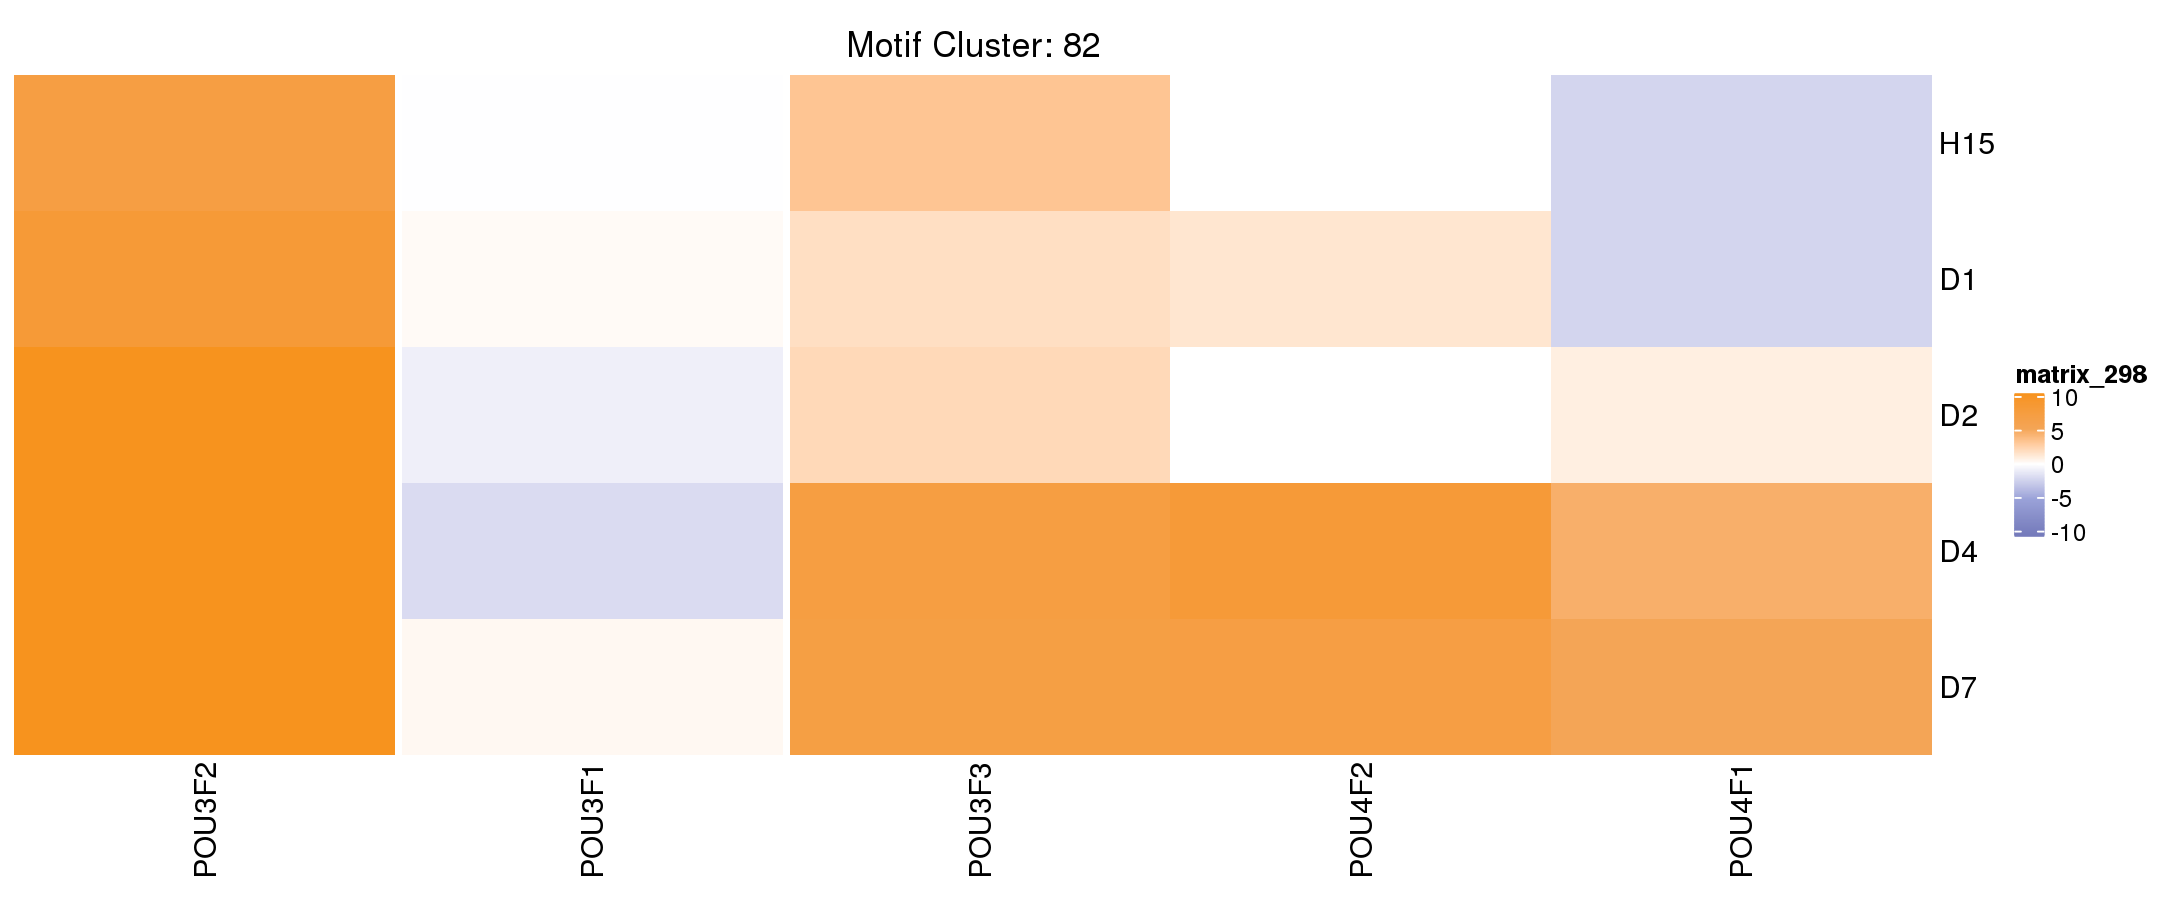

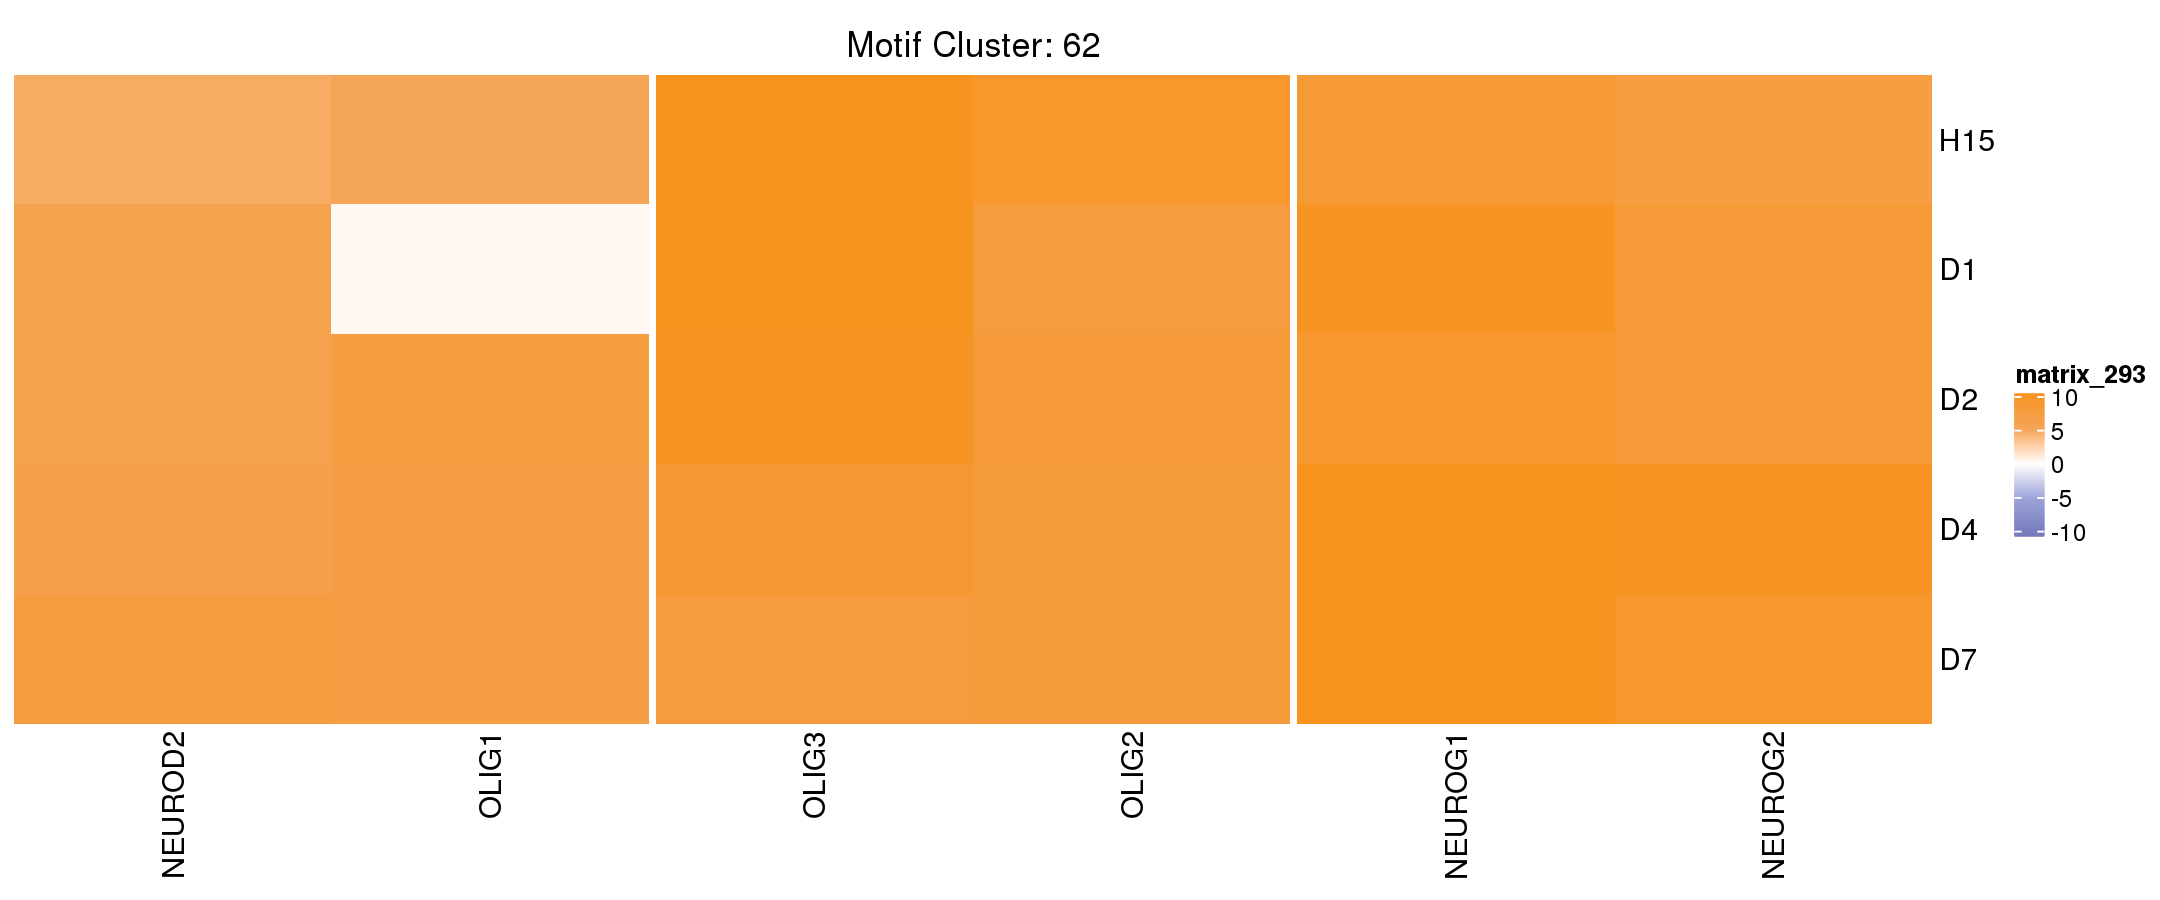

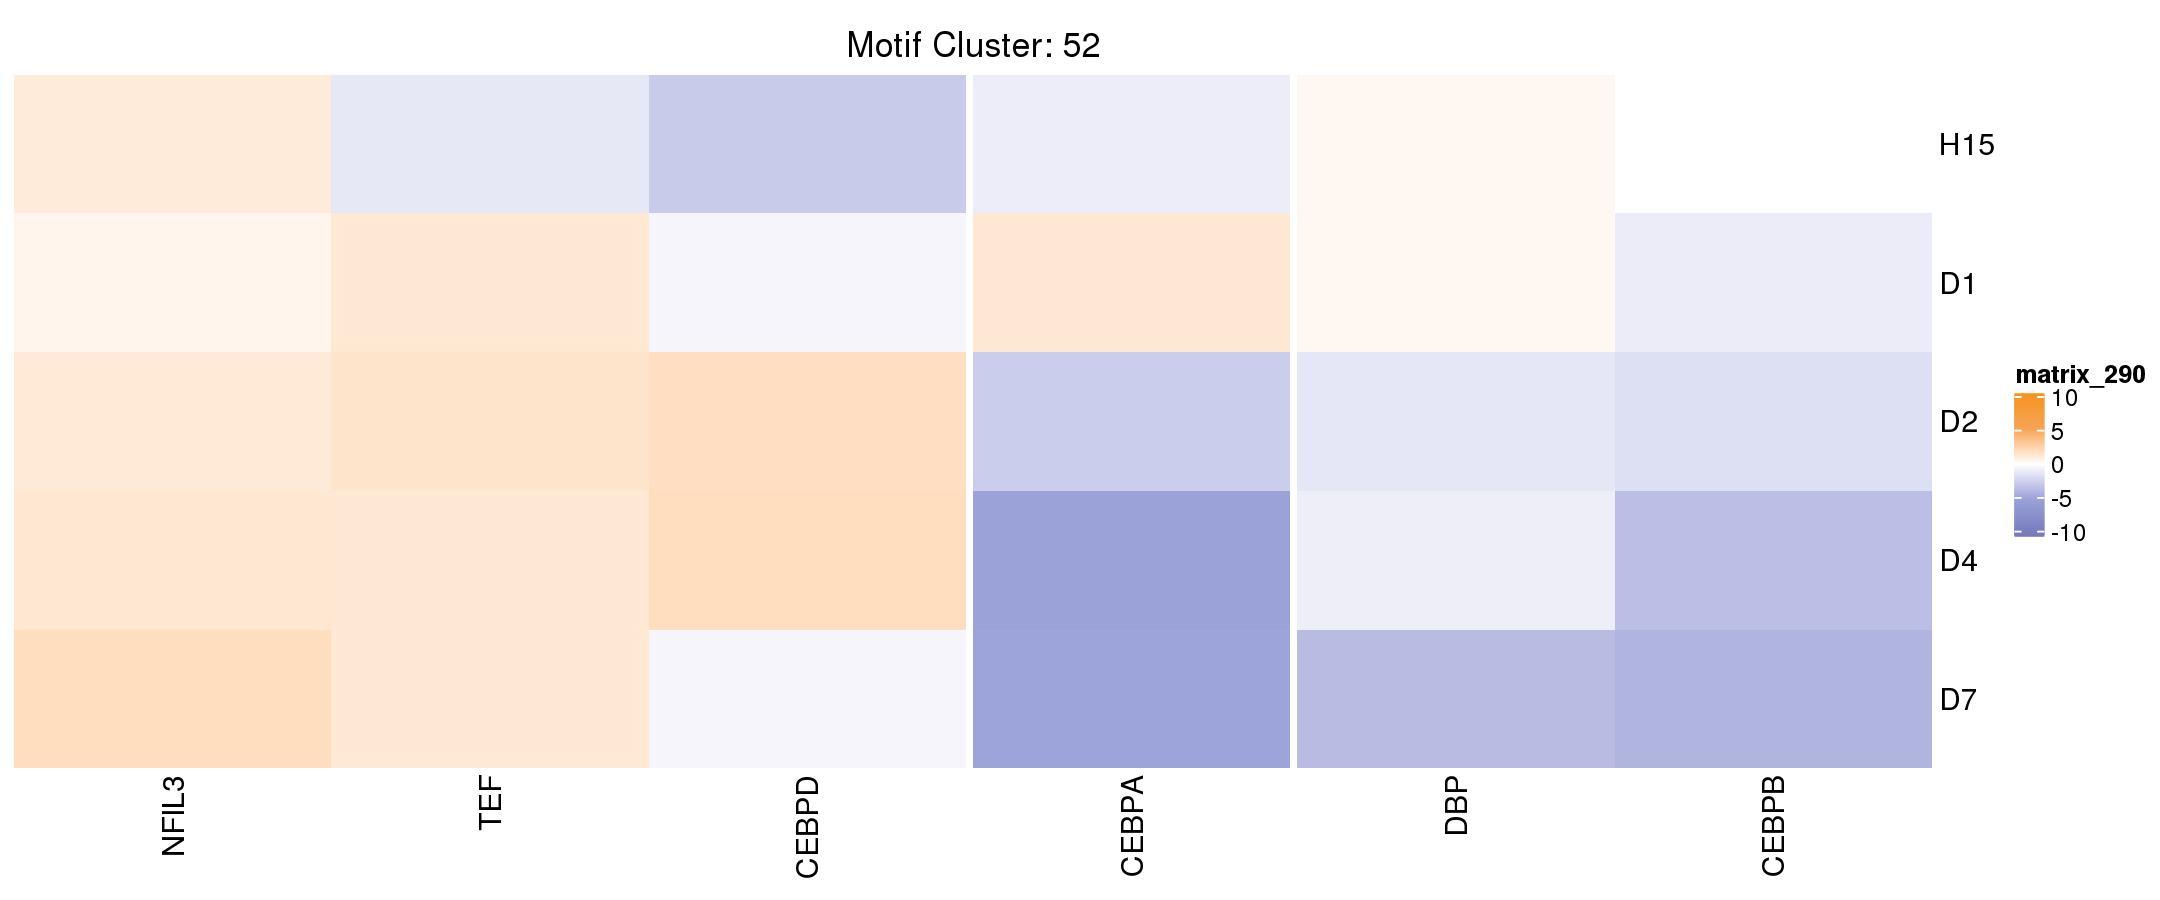

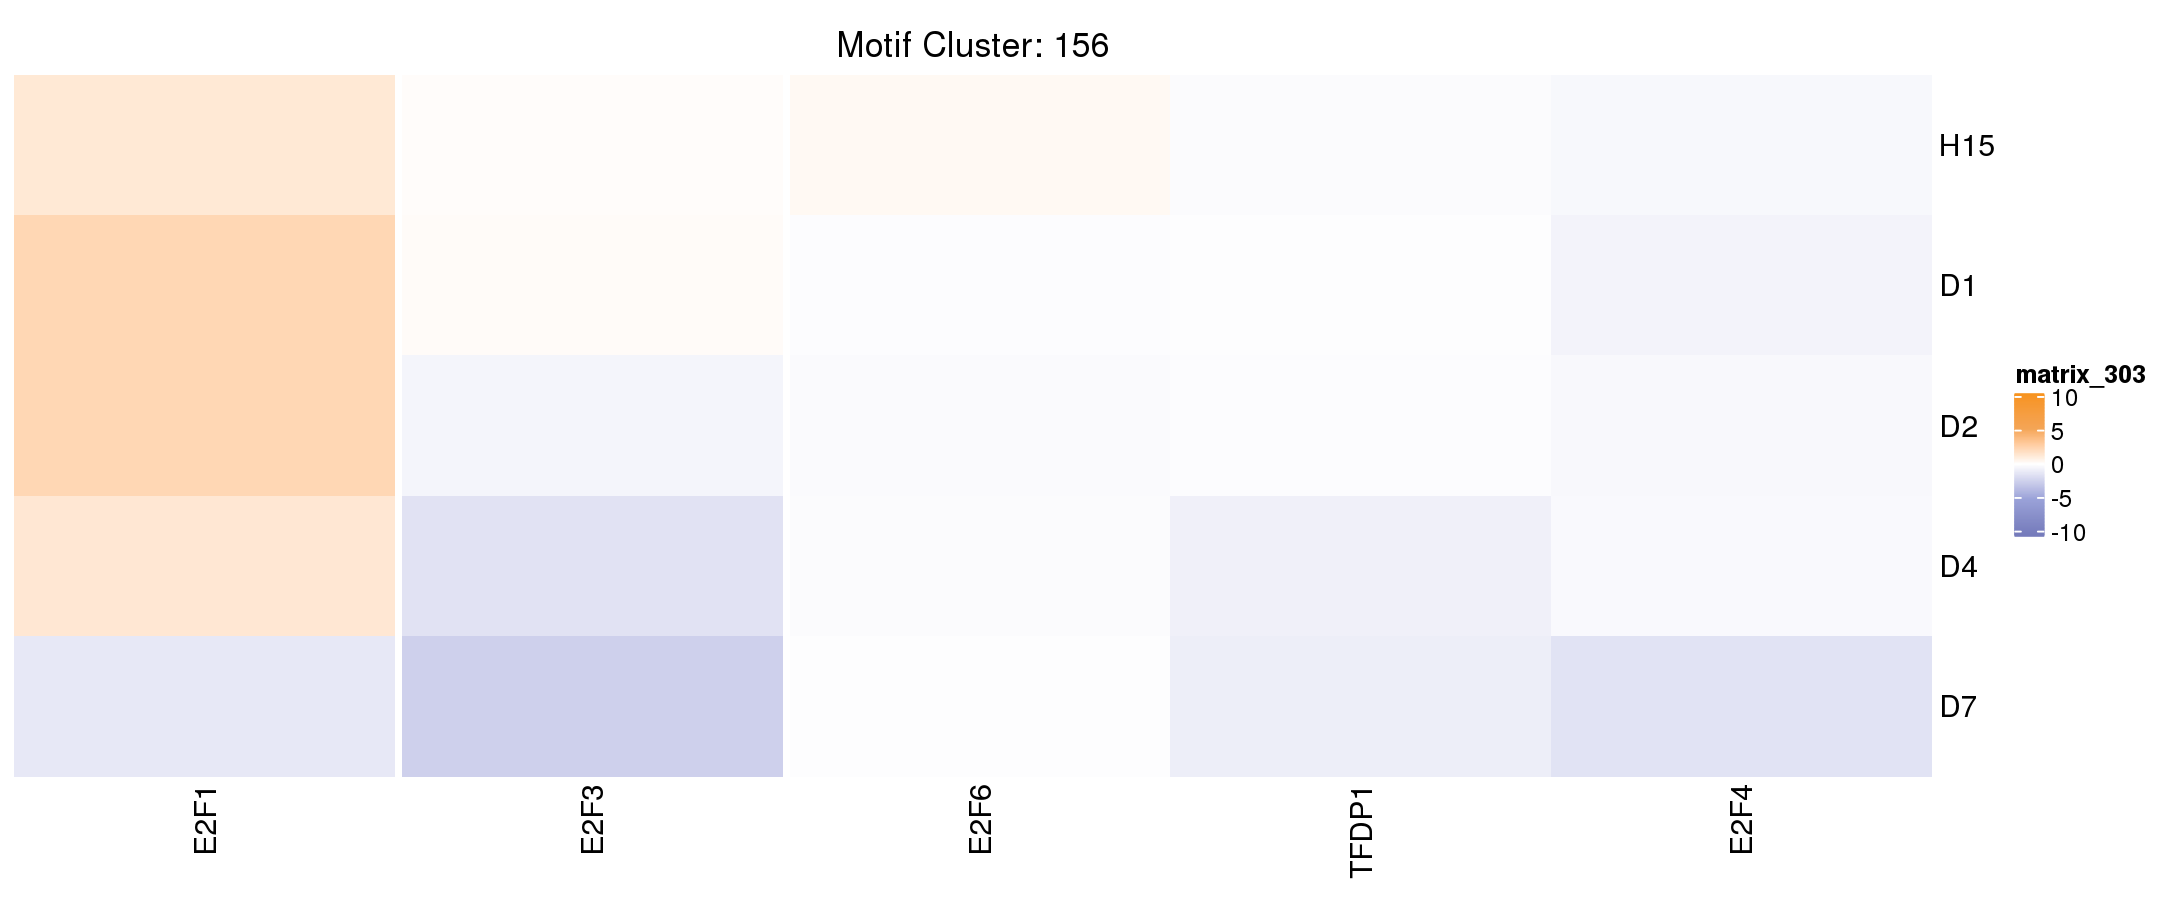

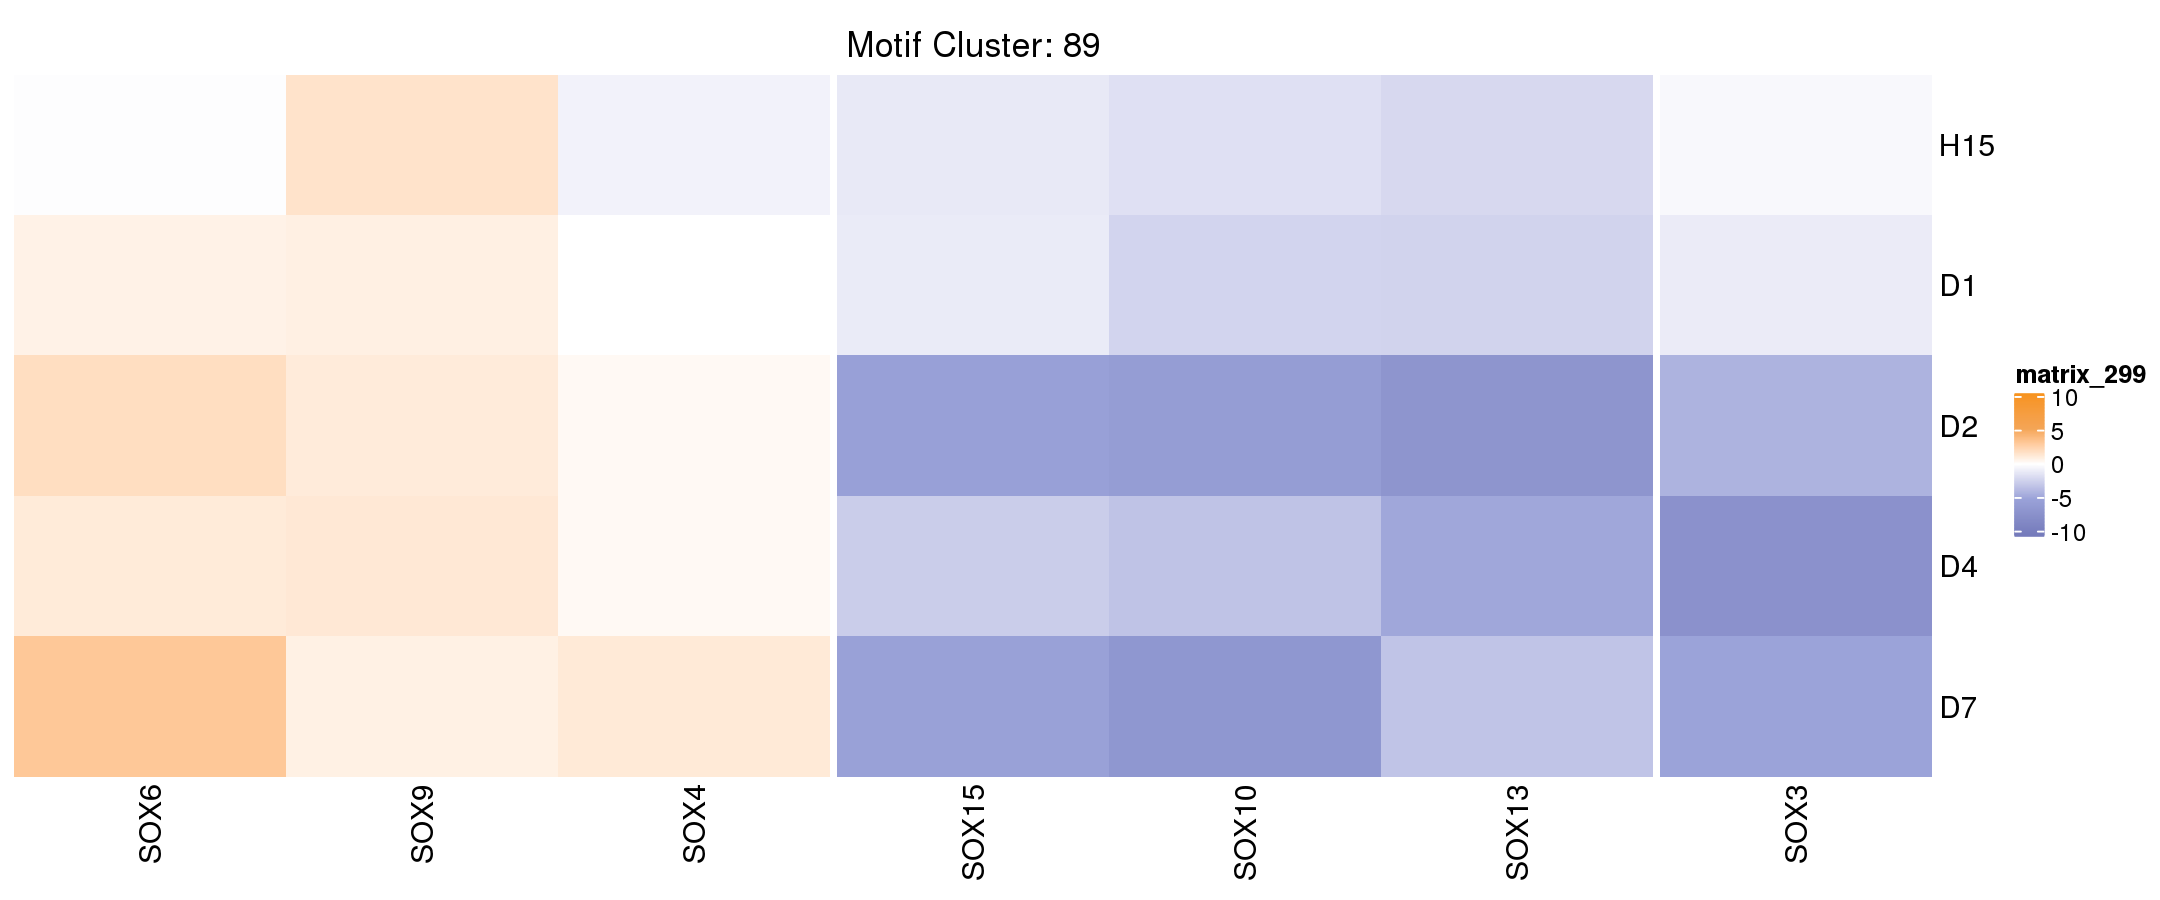

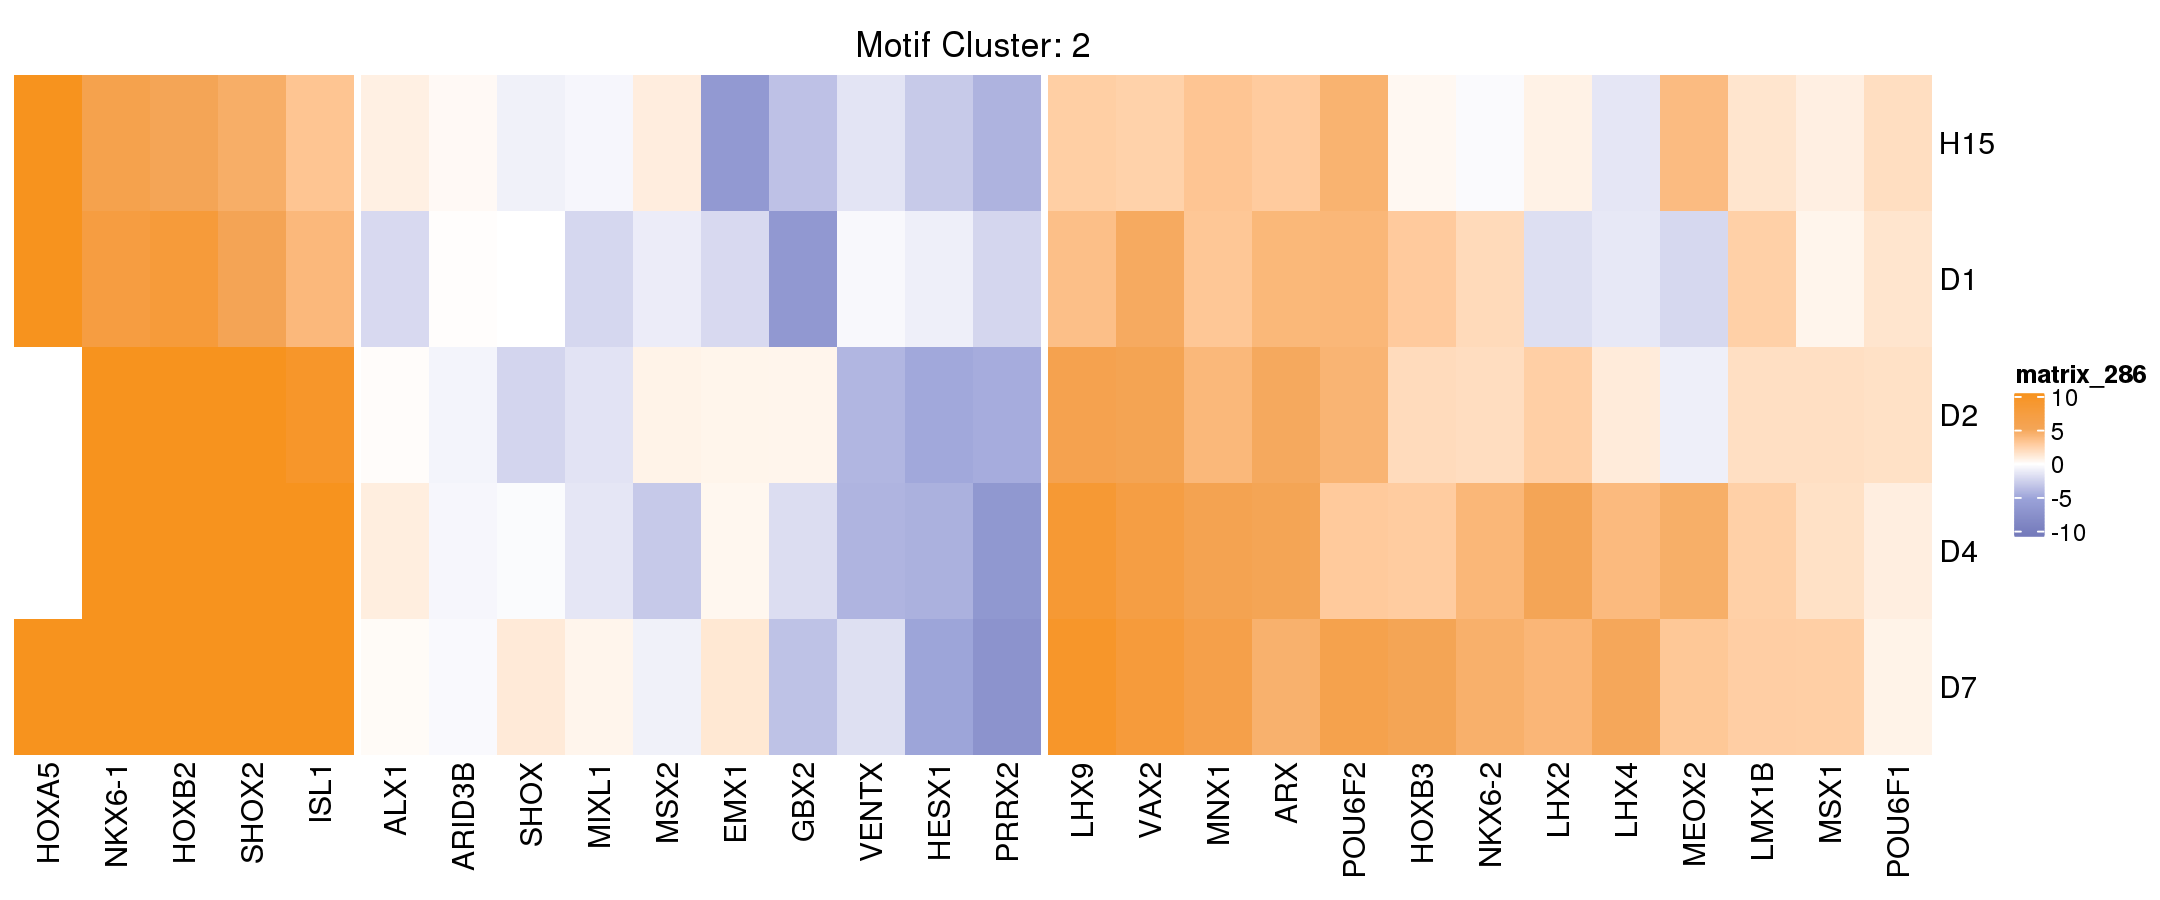

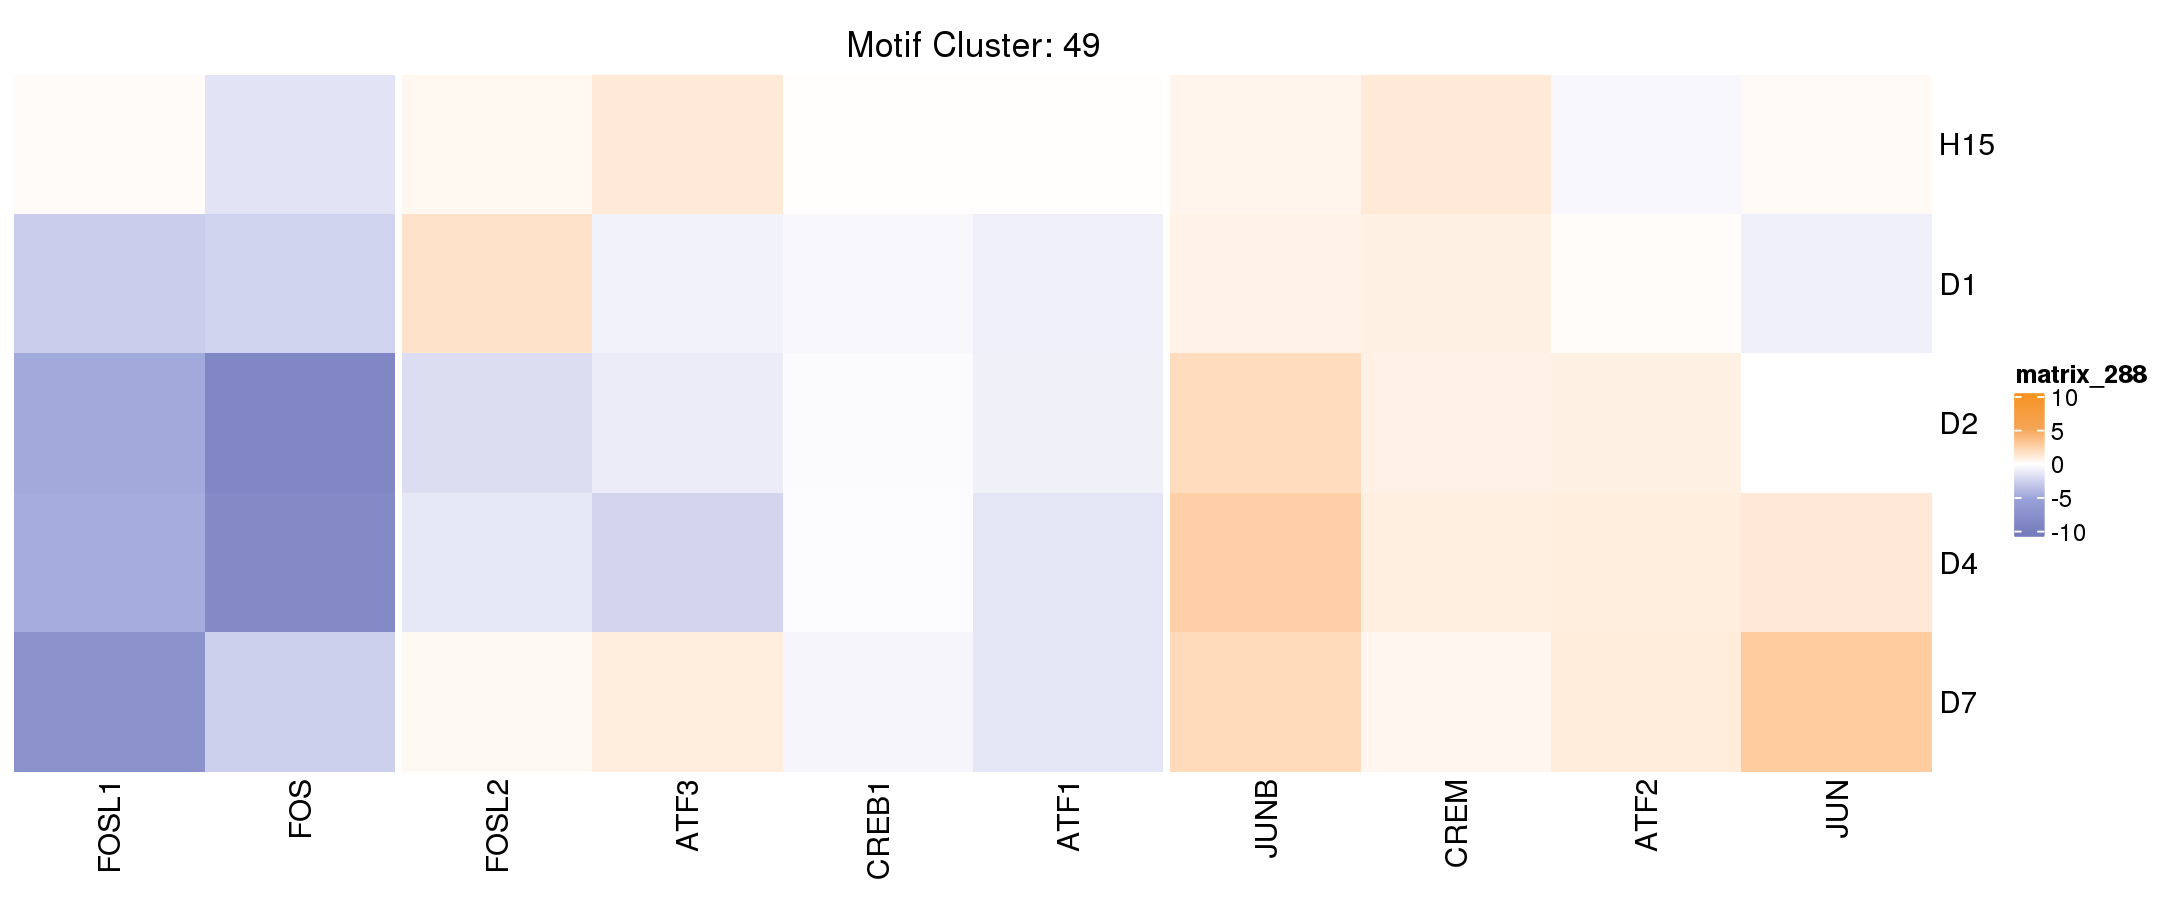

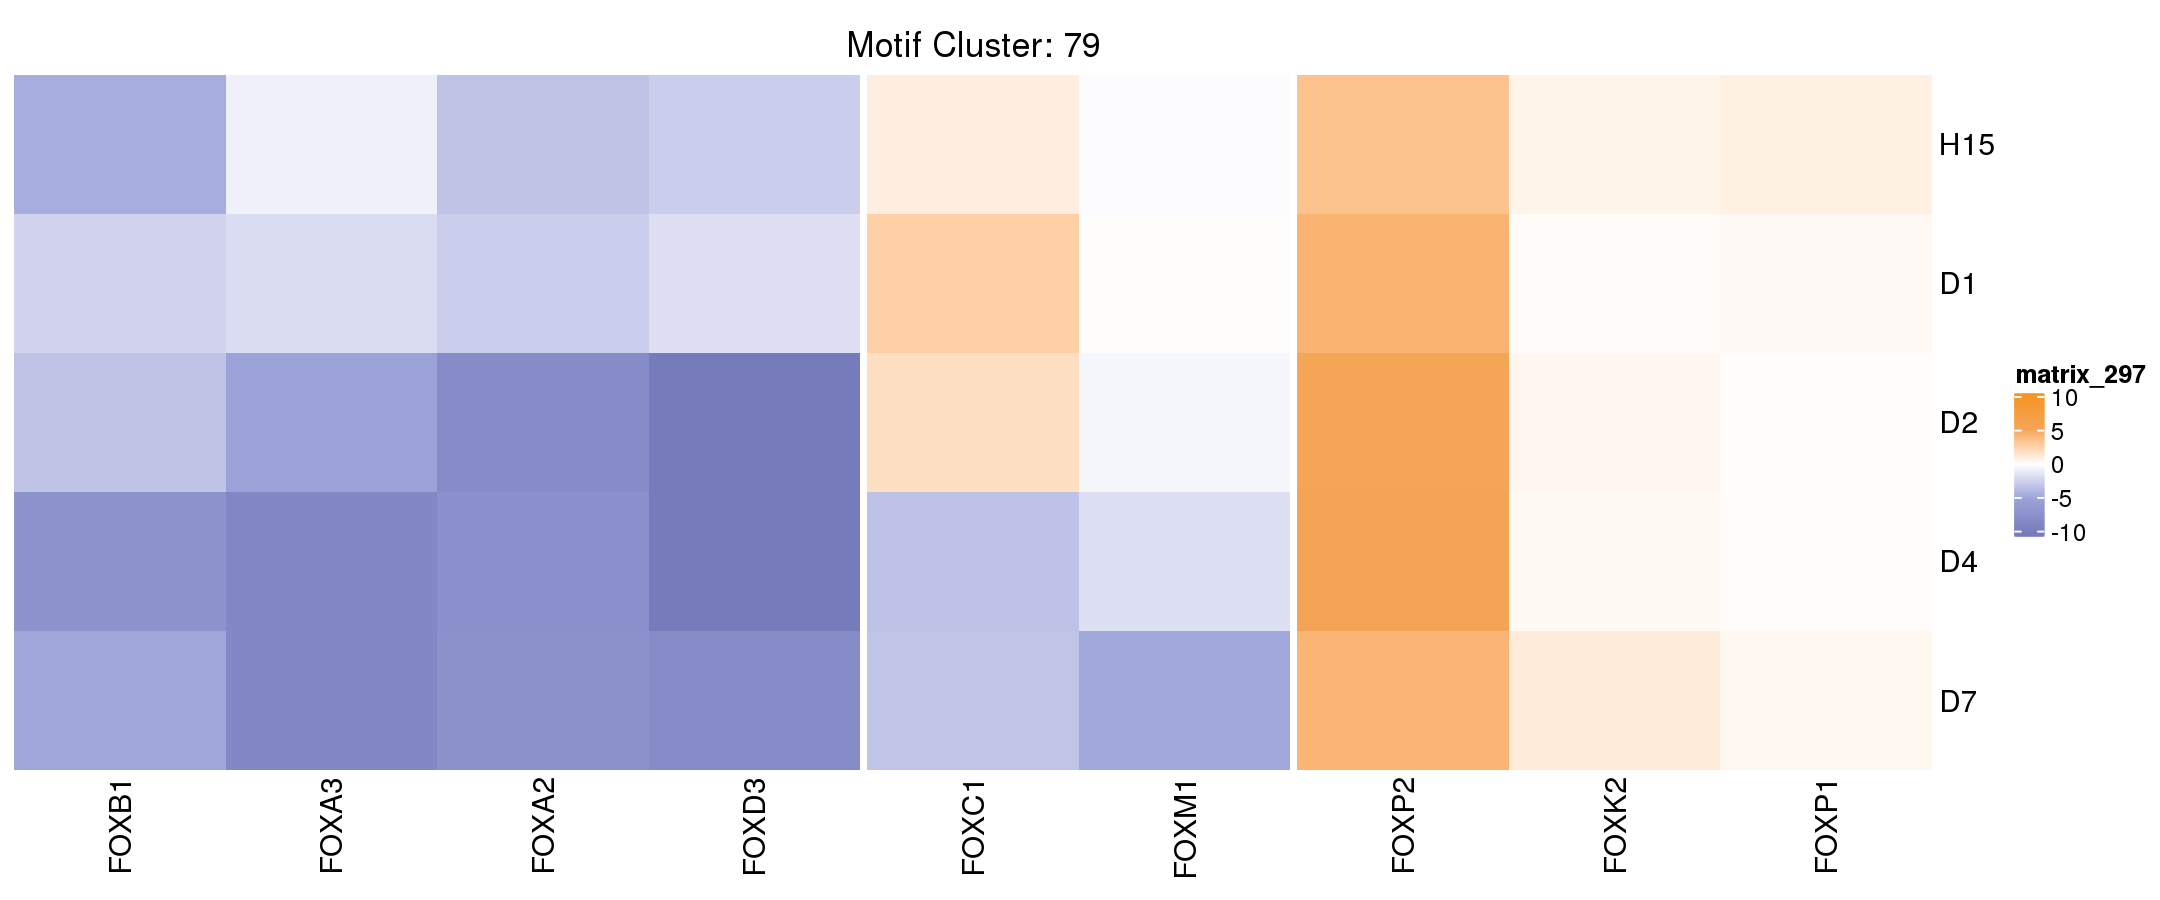

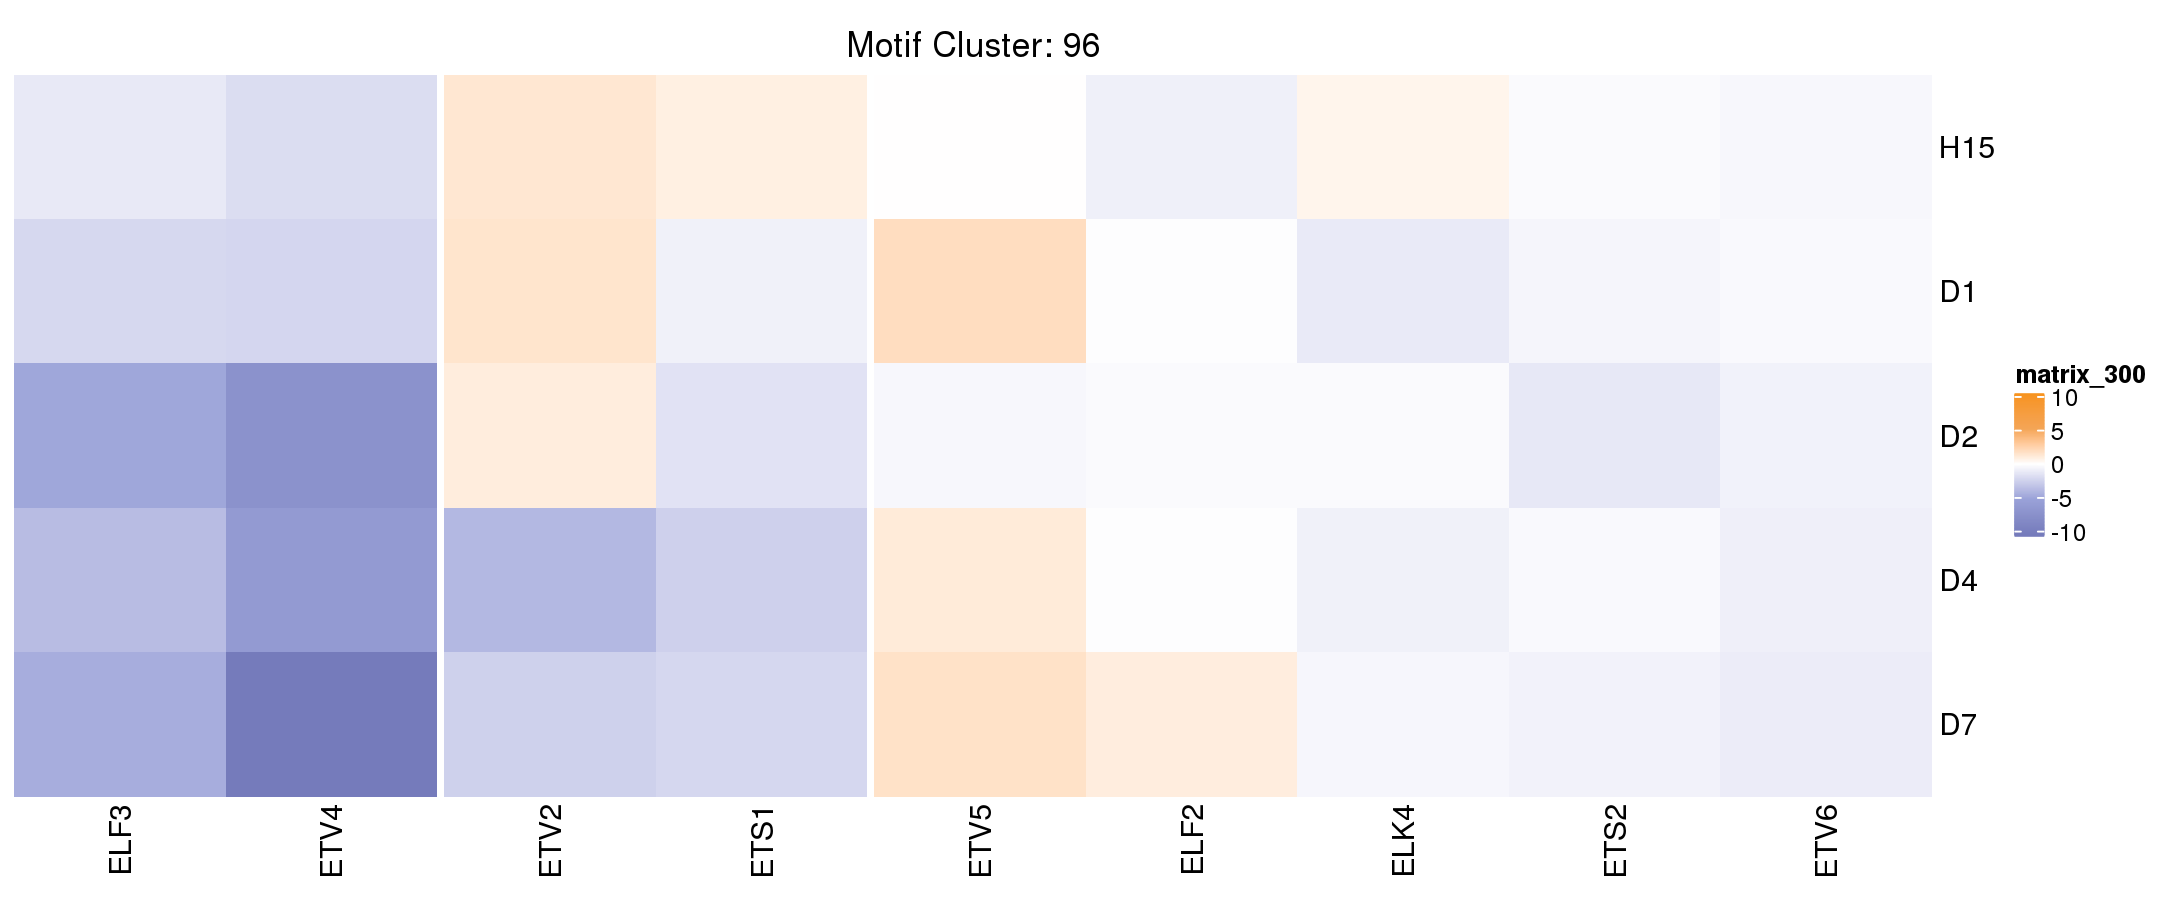

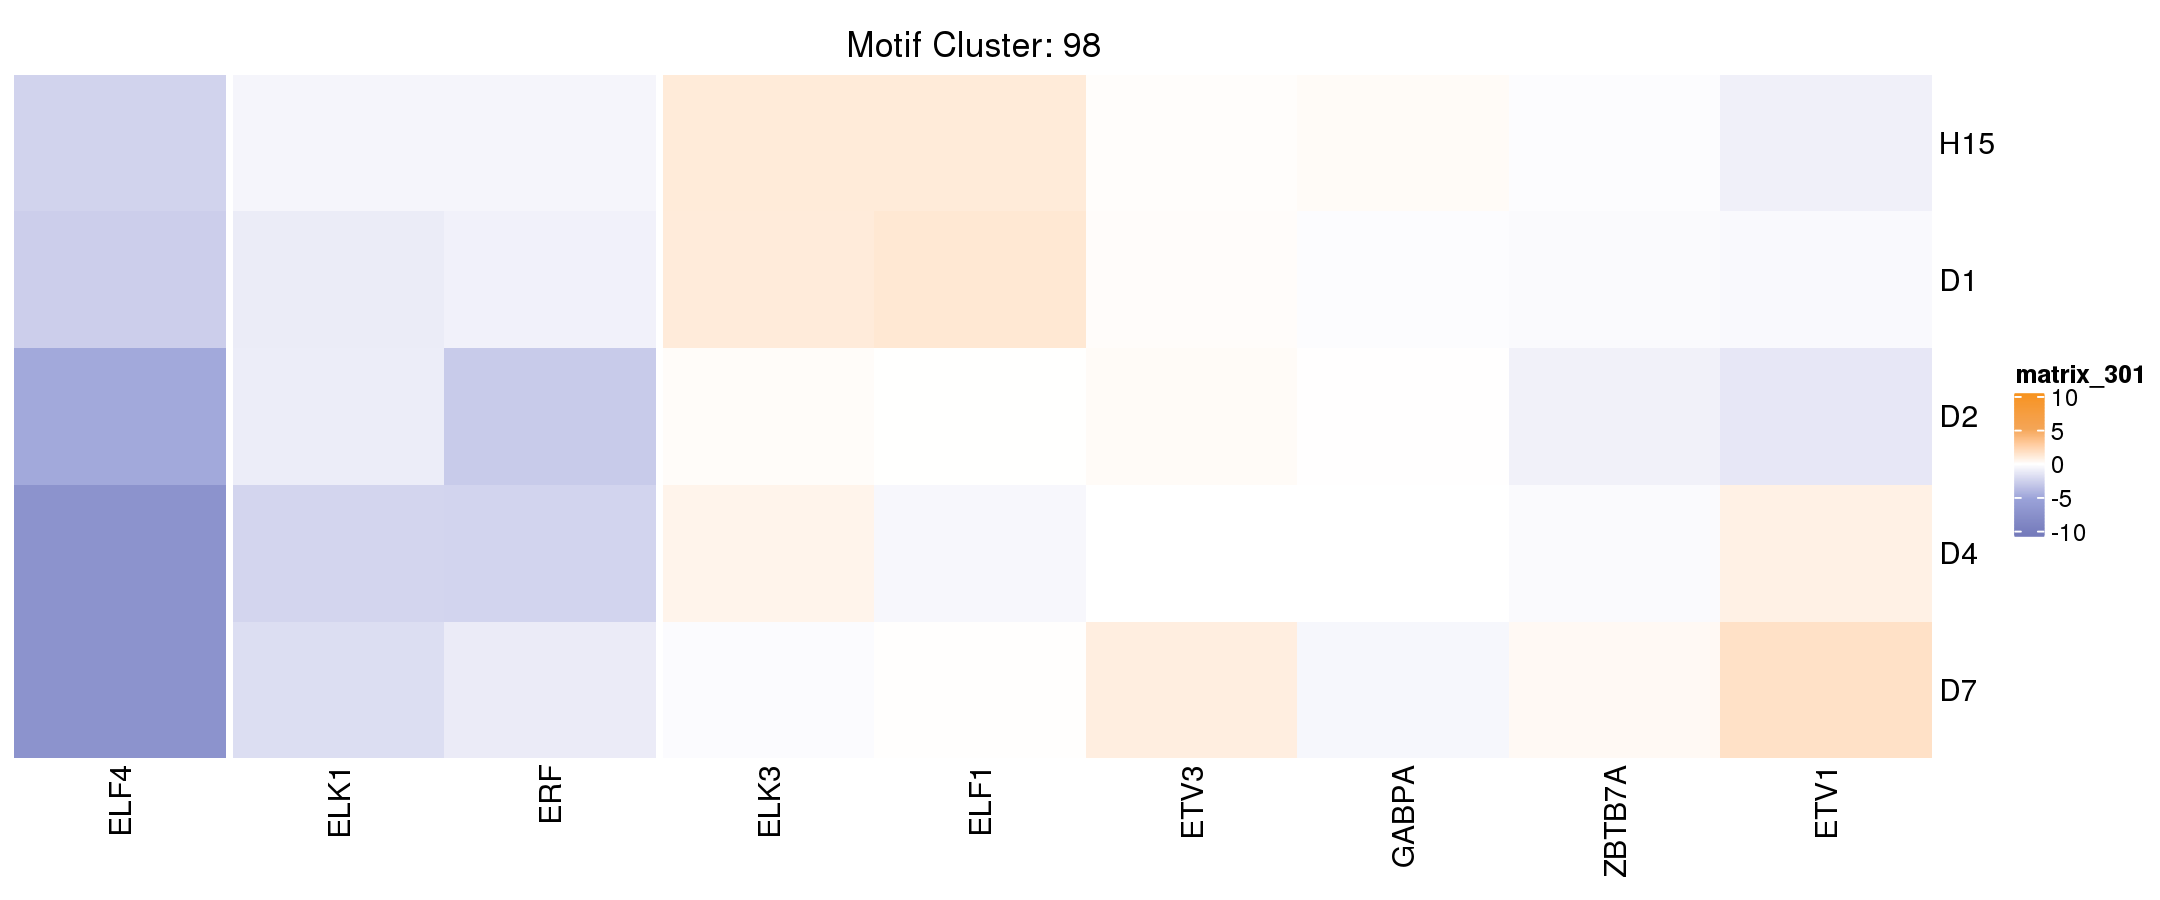

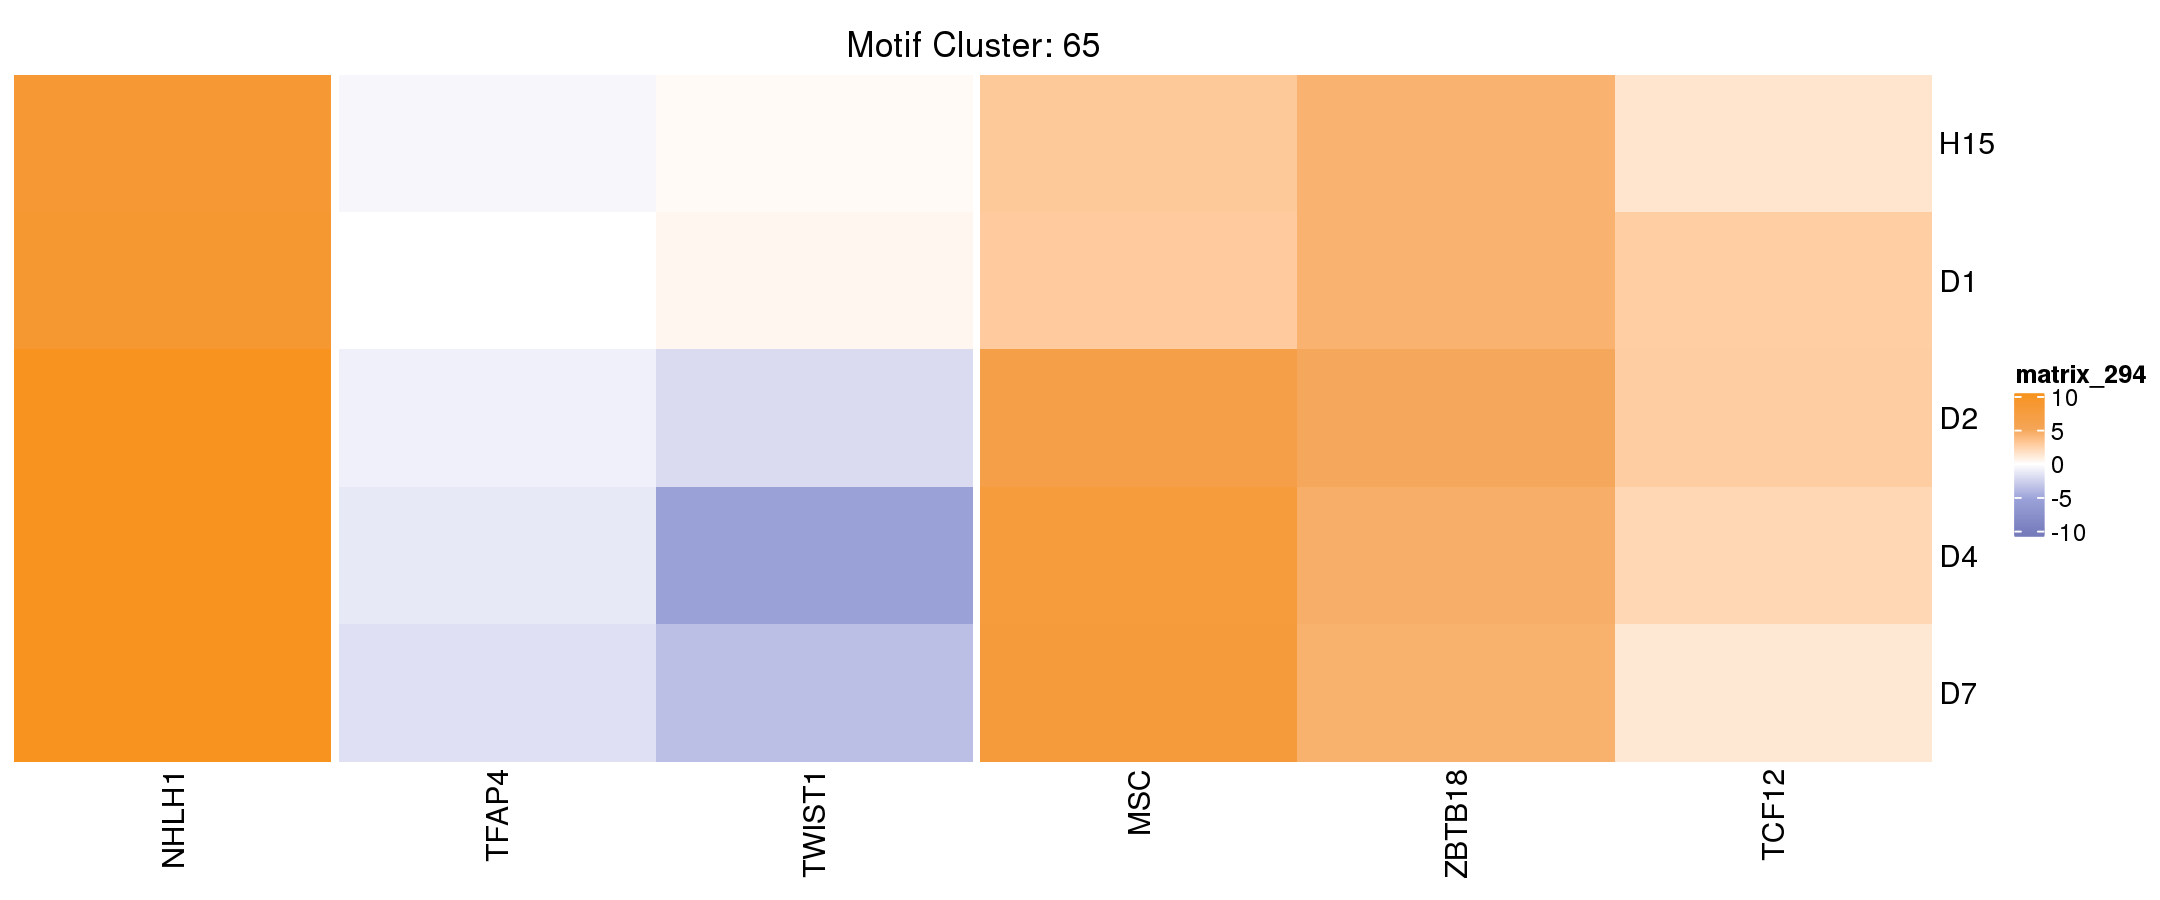

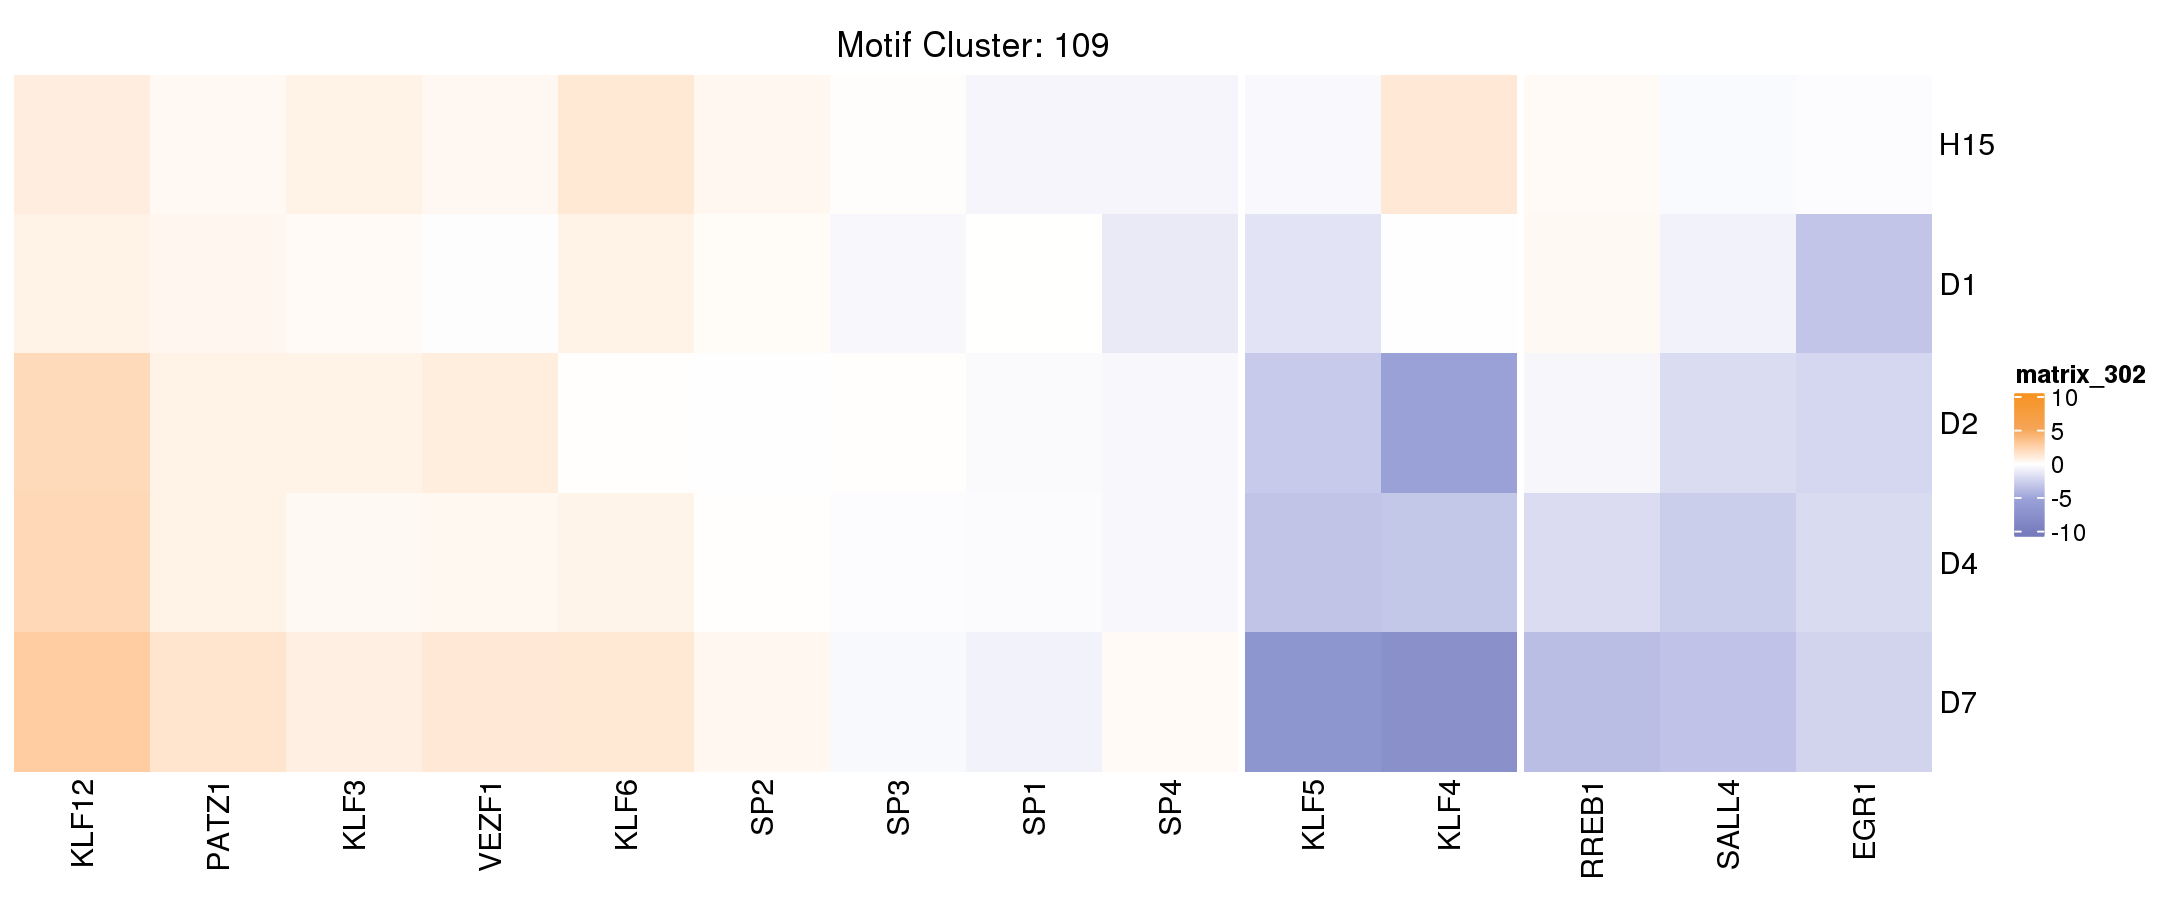

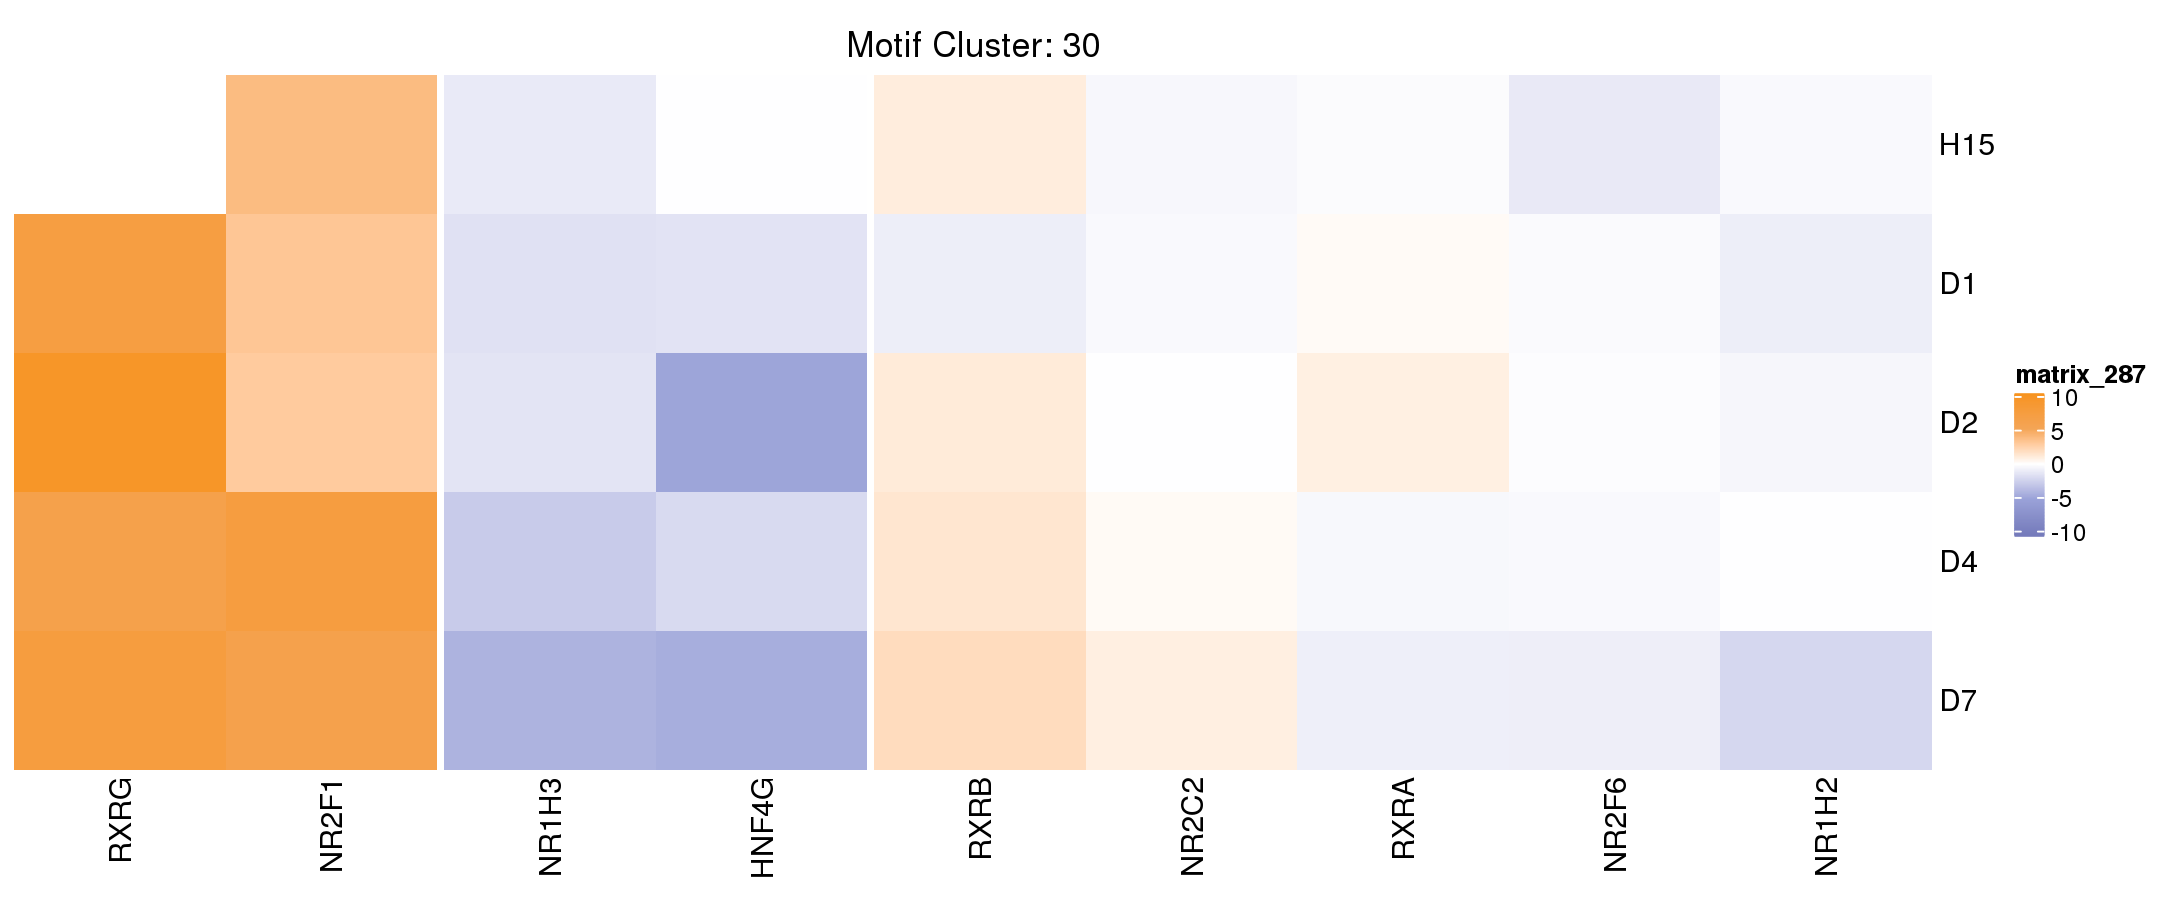

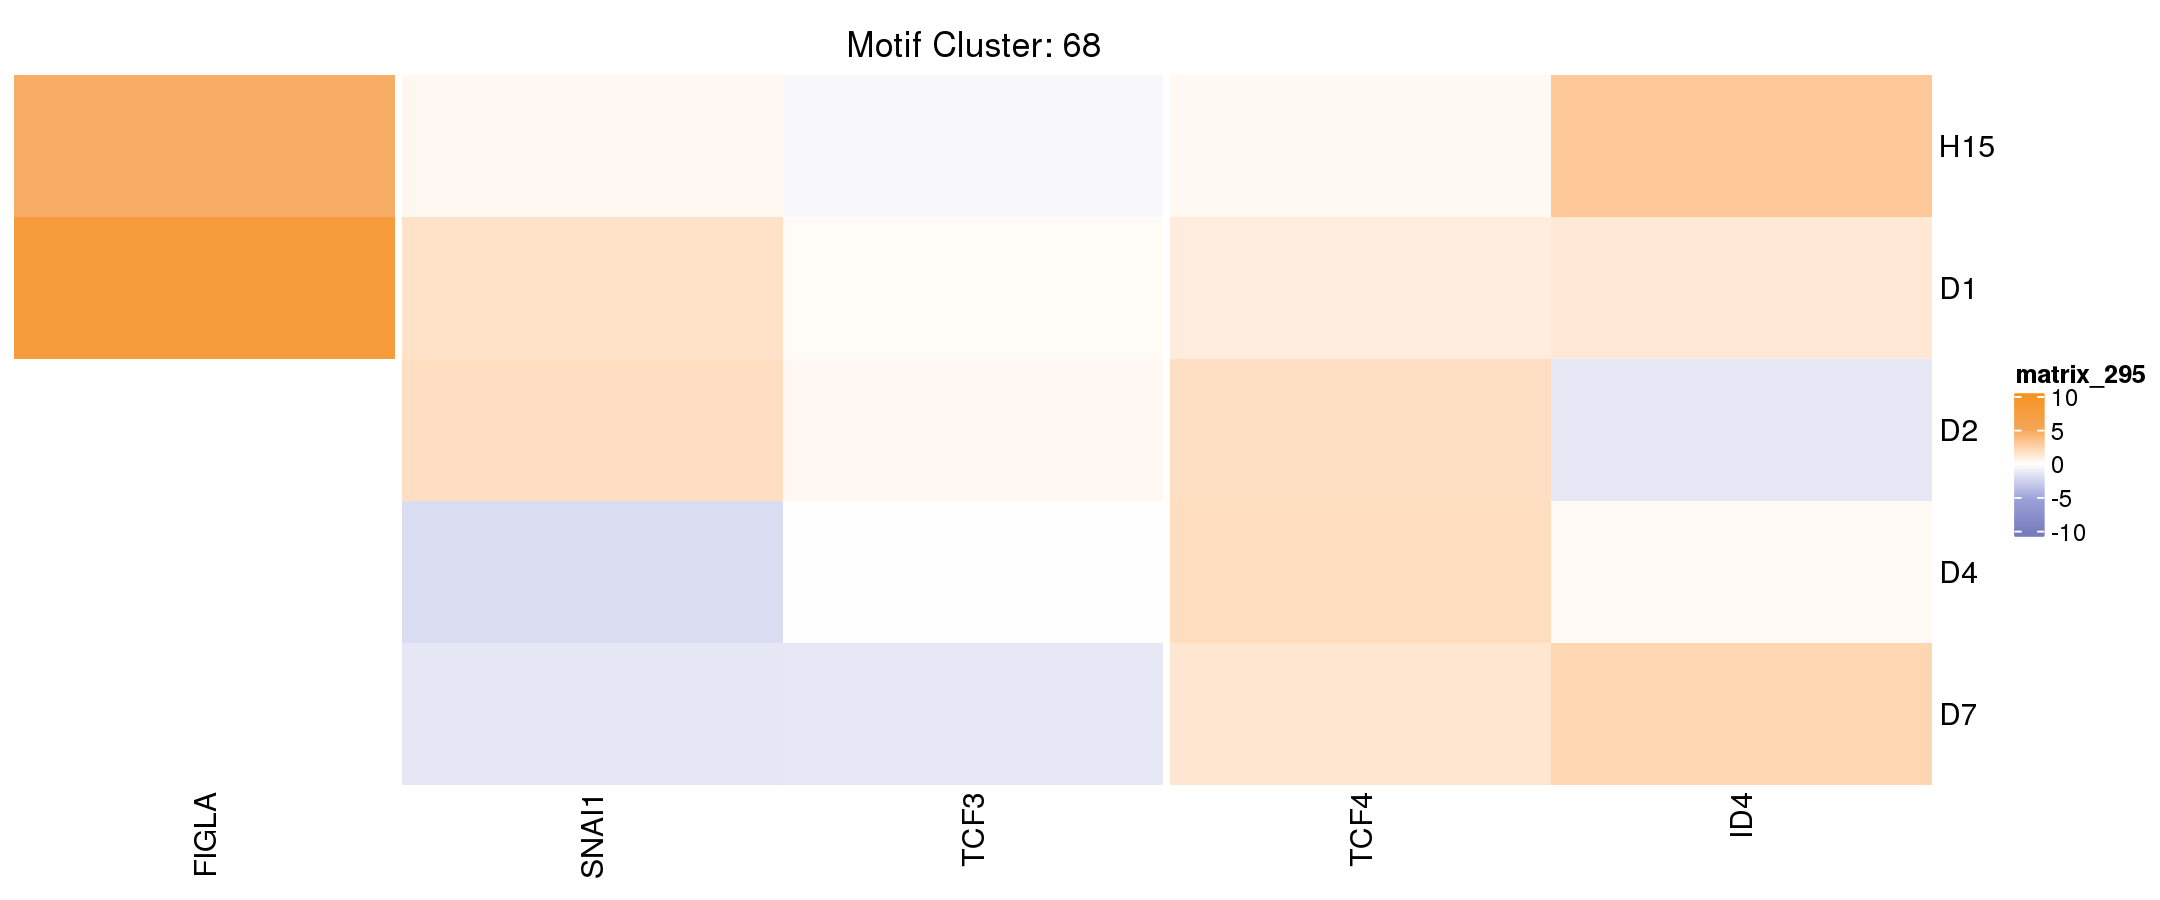

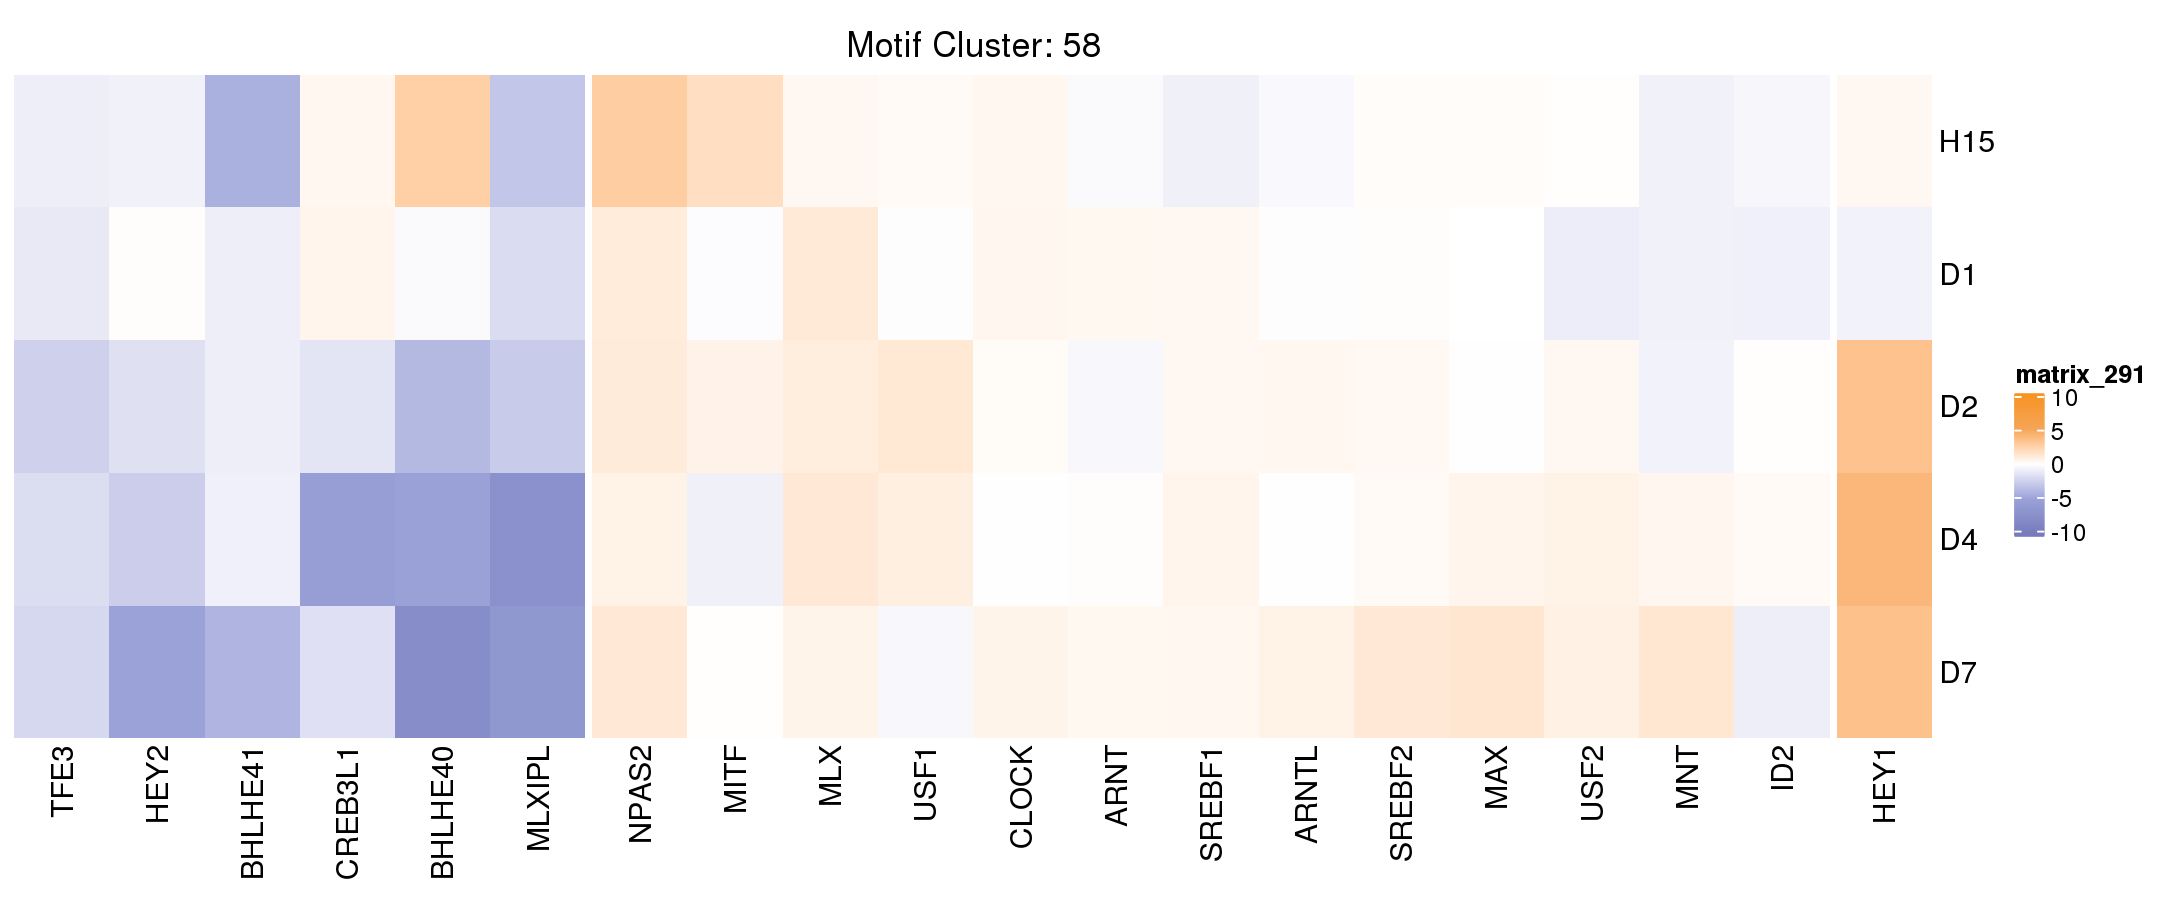

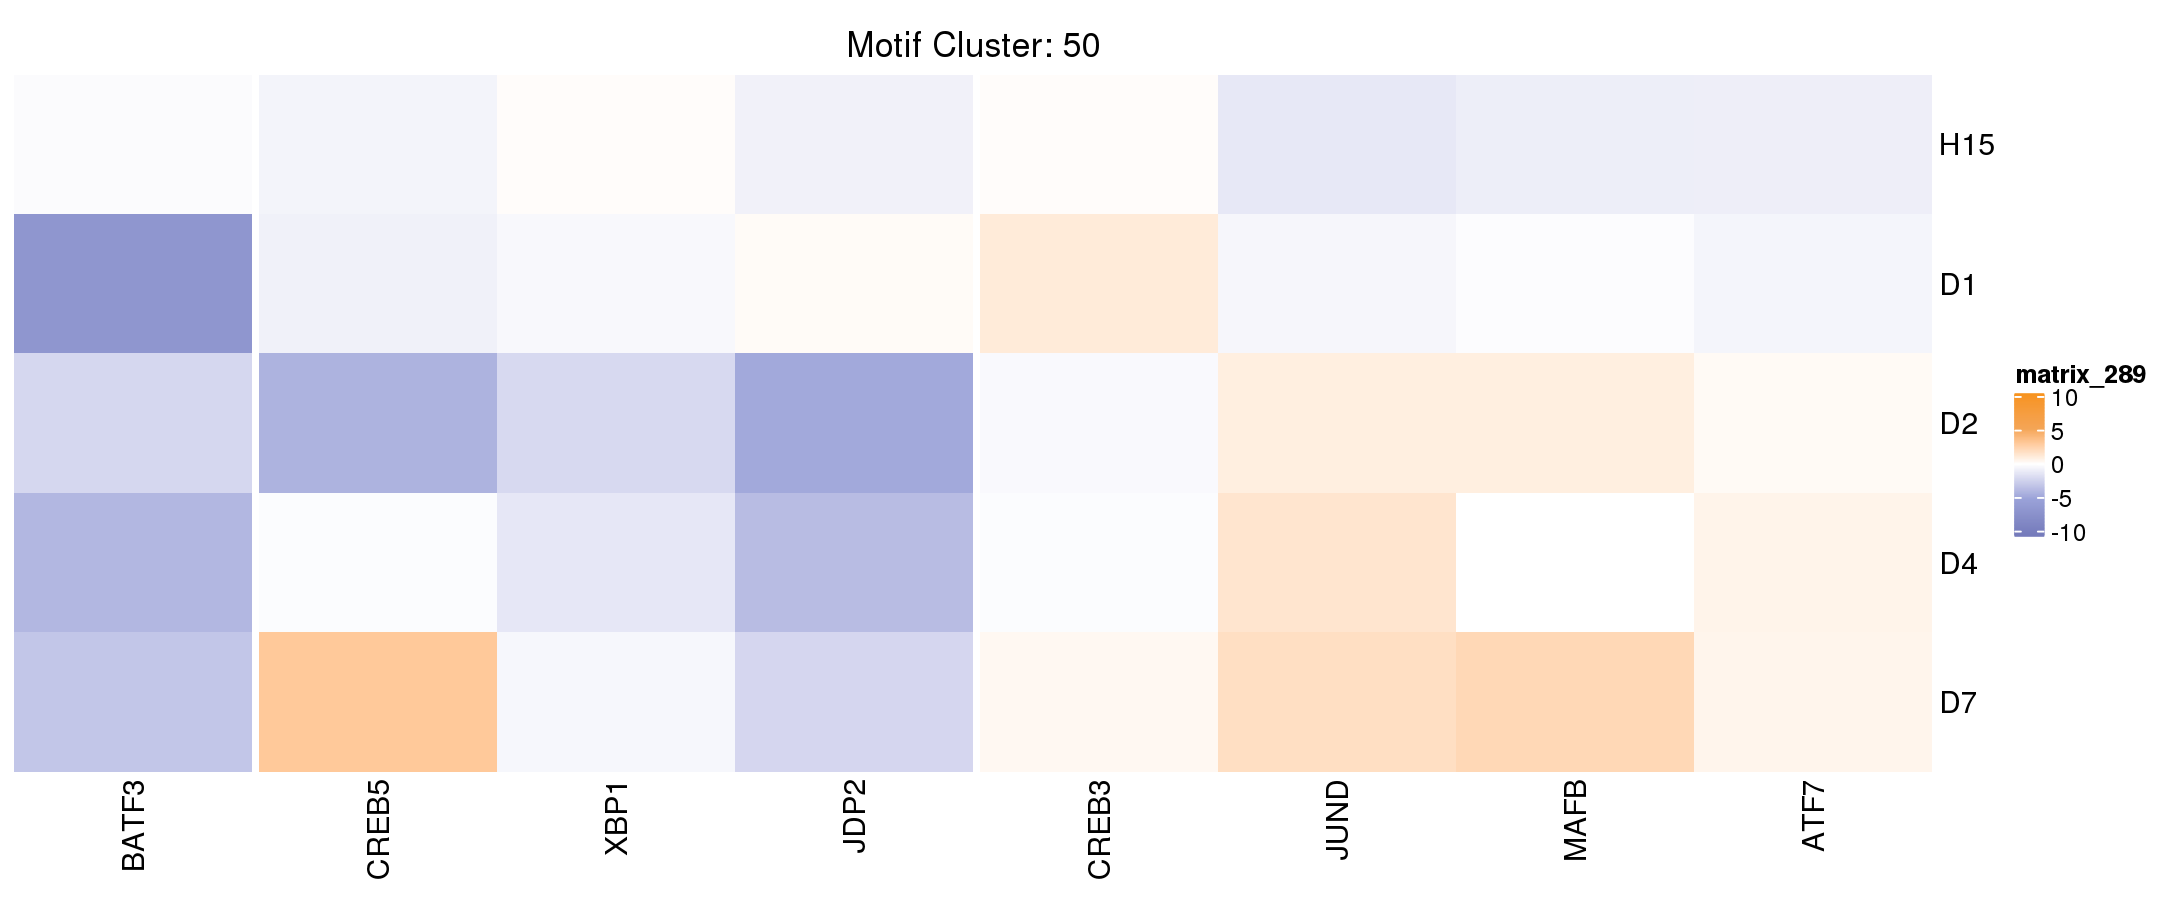

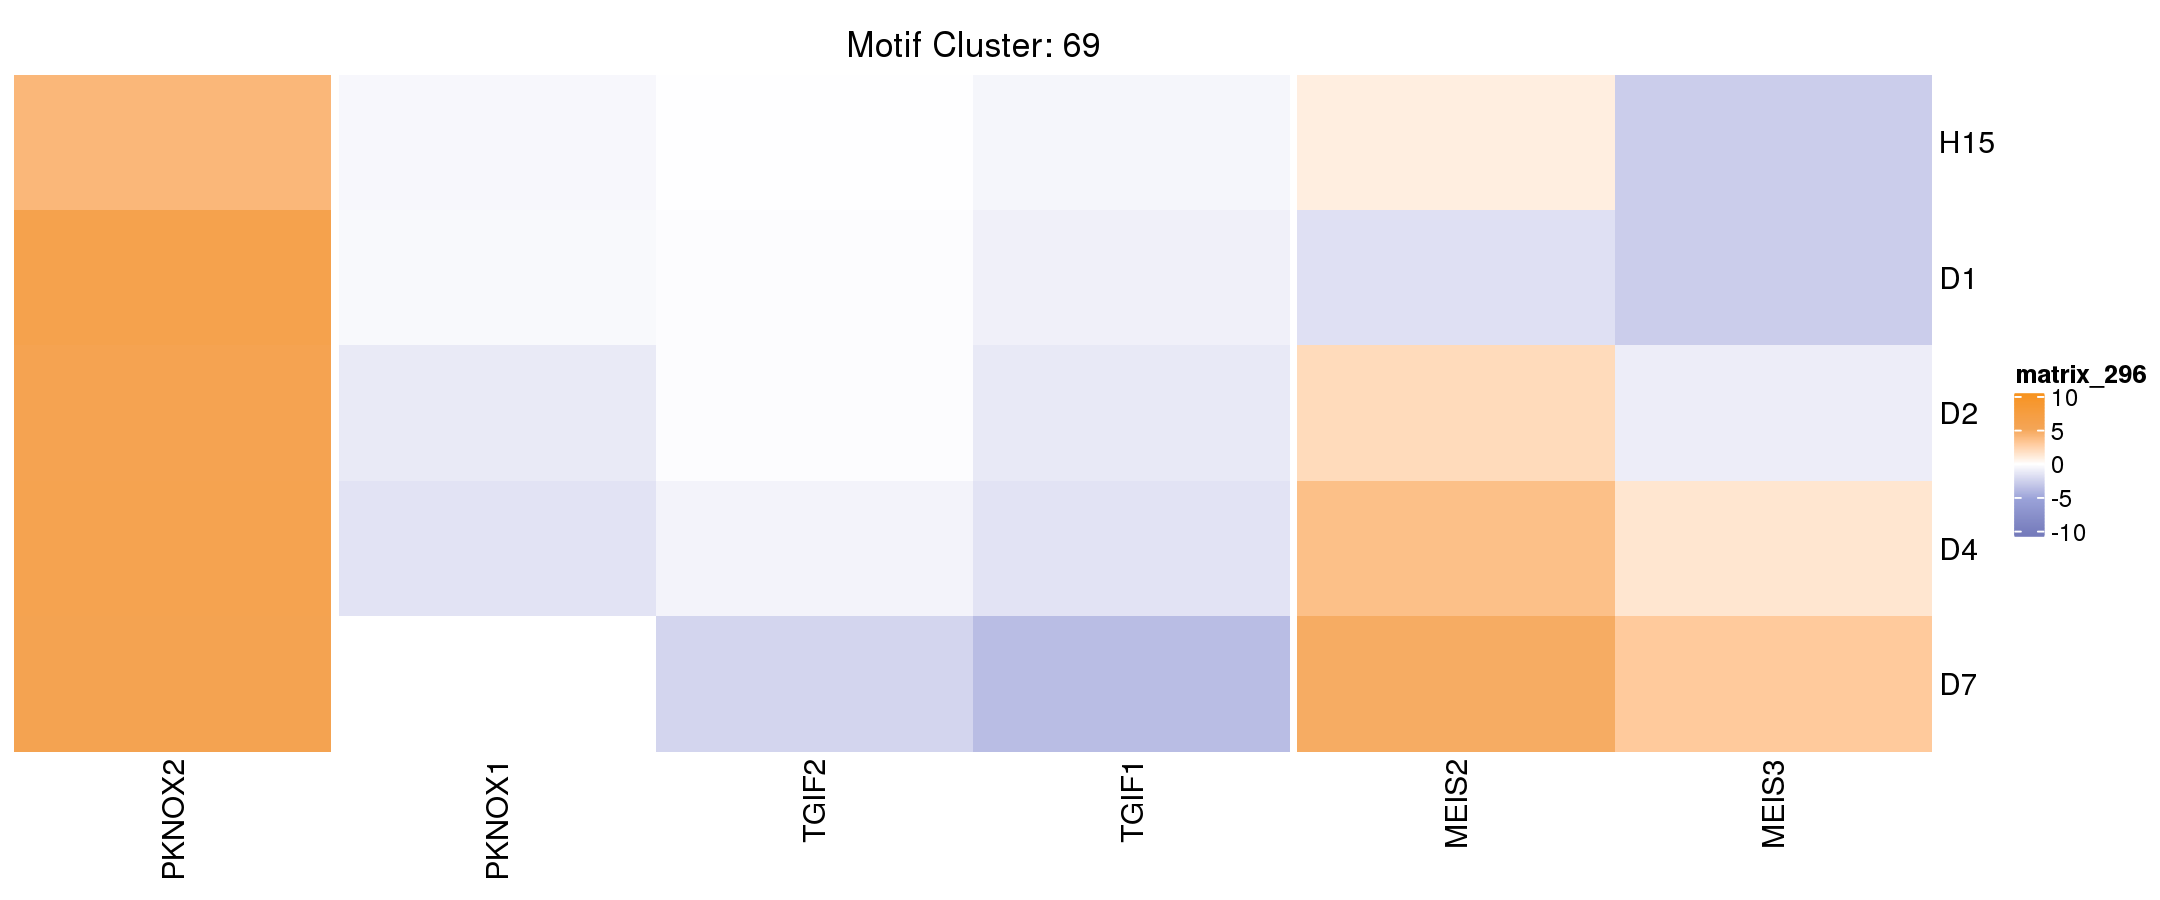

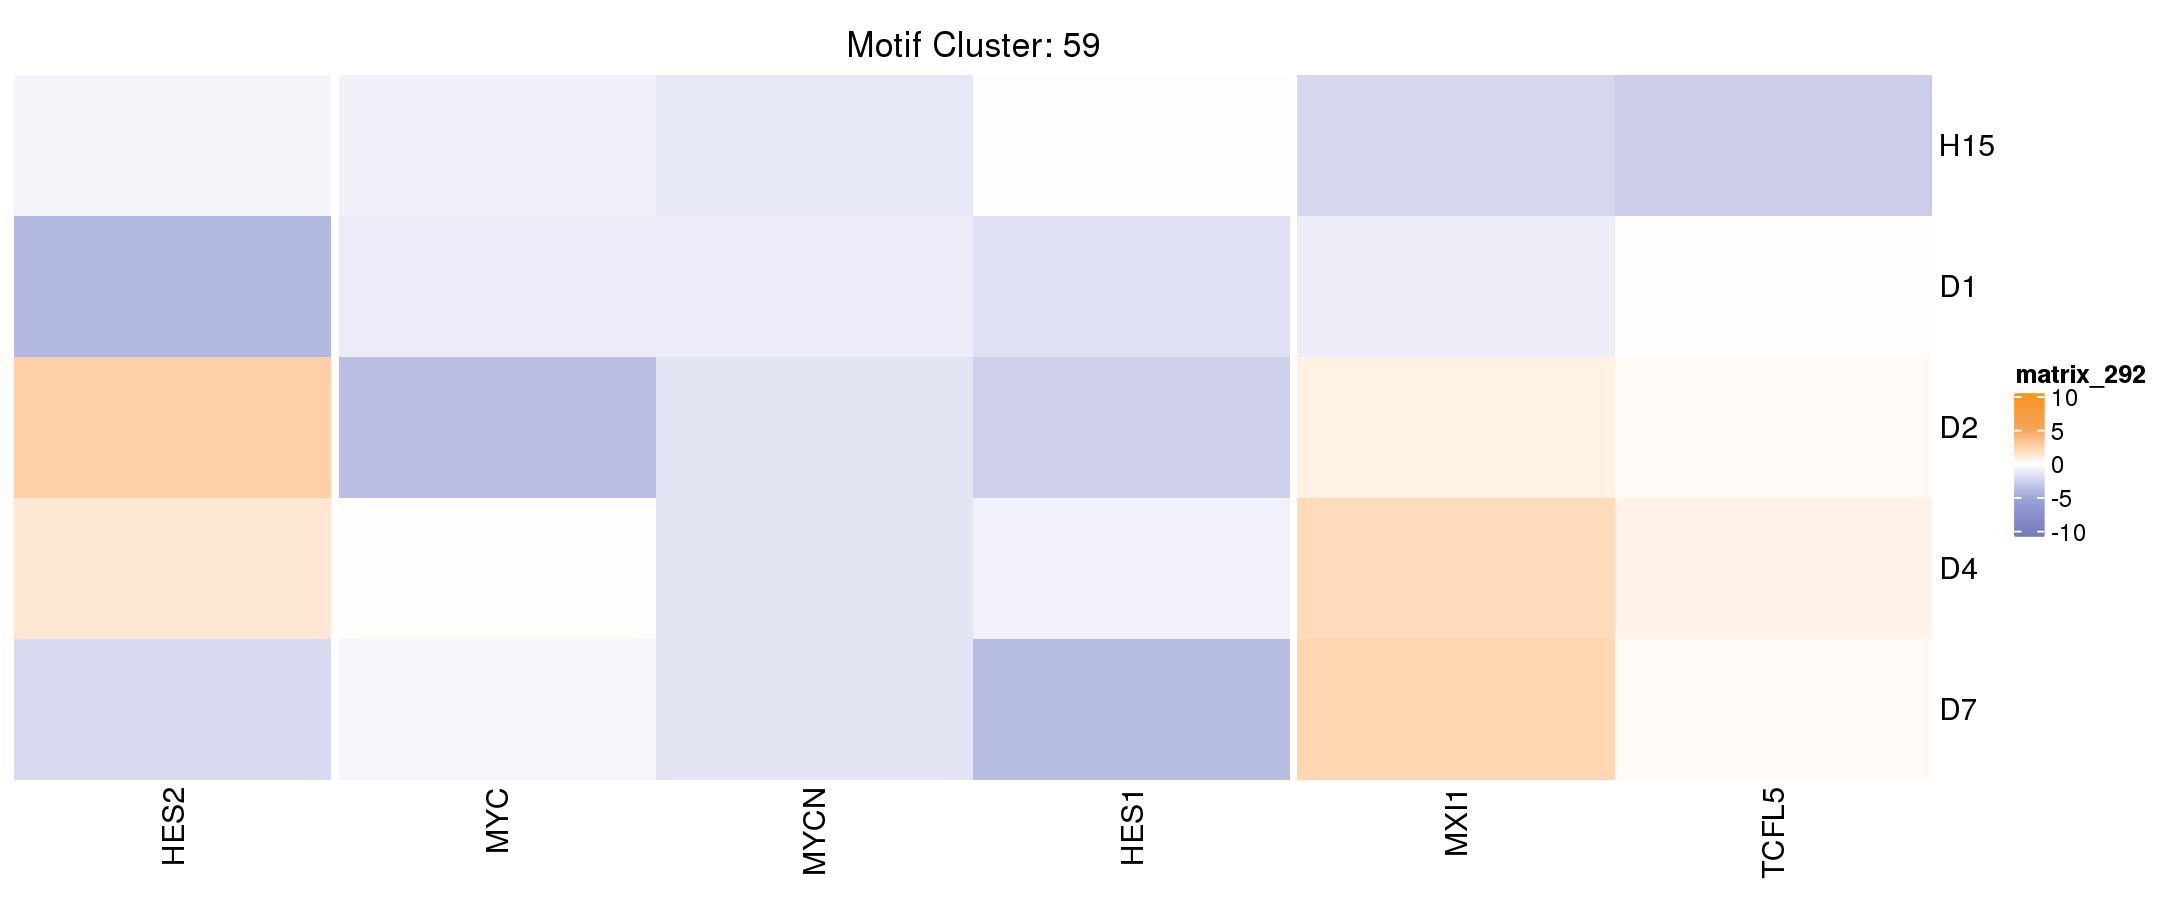

In [641]:
walk(motif.cluster.kept.ht[as.character(motif.cluster.kept.ht.order)], draw)


---
# GSEA with MsigDB


check out this page for gmt descriptions:

https://www.gsea-msigdb.org/gsea/msigdb/collections.jsp#C5

In [510]:
dir(".", ".gmt")

[1] "c2.all.v7.1.symbols.gmt" "c3.tft.v7.1.symbols.gmt"
[3] "c5.bp.v7.1.symbols.gmt"  "c5.cc.v7.1.symbols.gmt" 
[5] "c5.mf.v7.1.symbols.gmt"  "h.all.v7.1.symbols.gmt"

In [511]:
pathway.Go.bp <- gmtPathways(gmt.file = 'c5.bp.v7.1.symbols.gmt')

In [545]:
Go.bp <- fgsea(pathways = pathway.Go.bp, stats = sort(D7.by.cluster$C1), nperm = 1000, nproc = 4)

Warning message in fgsea(pathways = pathway.Go.bp, stats = sort(D7.by.cluster$C1), :
“There are ties in the preranked stats (2.03% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [546]:
Go.bp[, .(padj)] %>% summary

      padj       
 Min.   :0.7620  
 1st Qu.:0.9161  
 Median :0.9161  
 Mean   :0.9180  
 3rd Qu.:0.9224  
 Max.   :1.0000  

In [ ]:
Path

In [528]:
data(examplePathways)
data(exampleRanks)

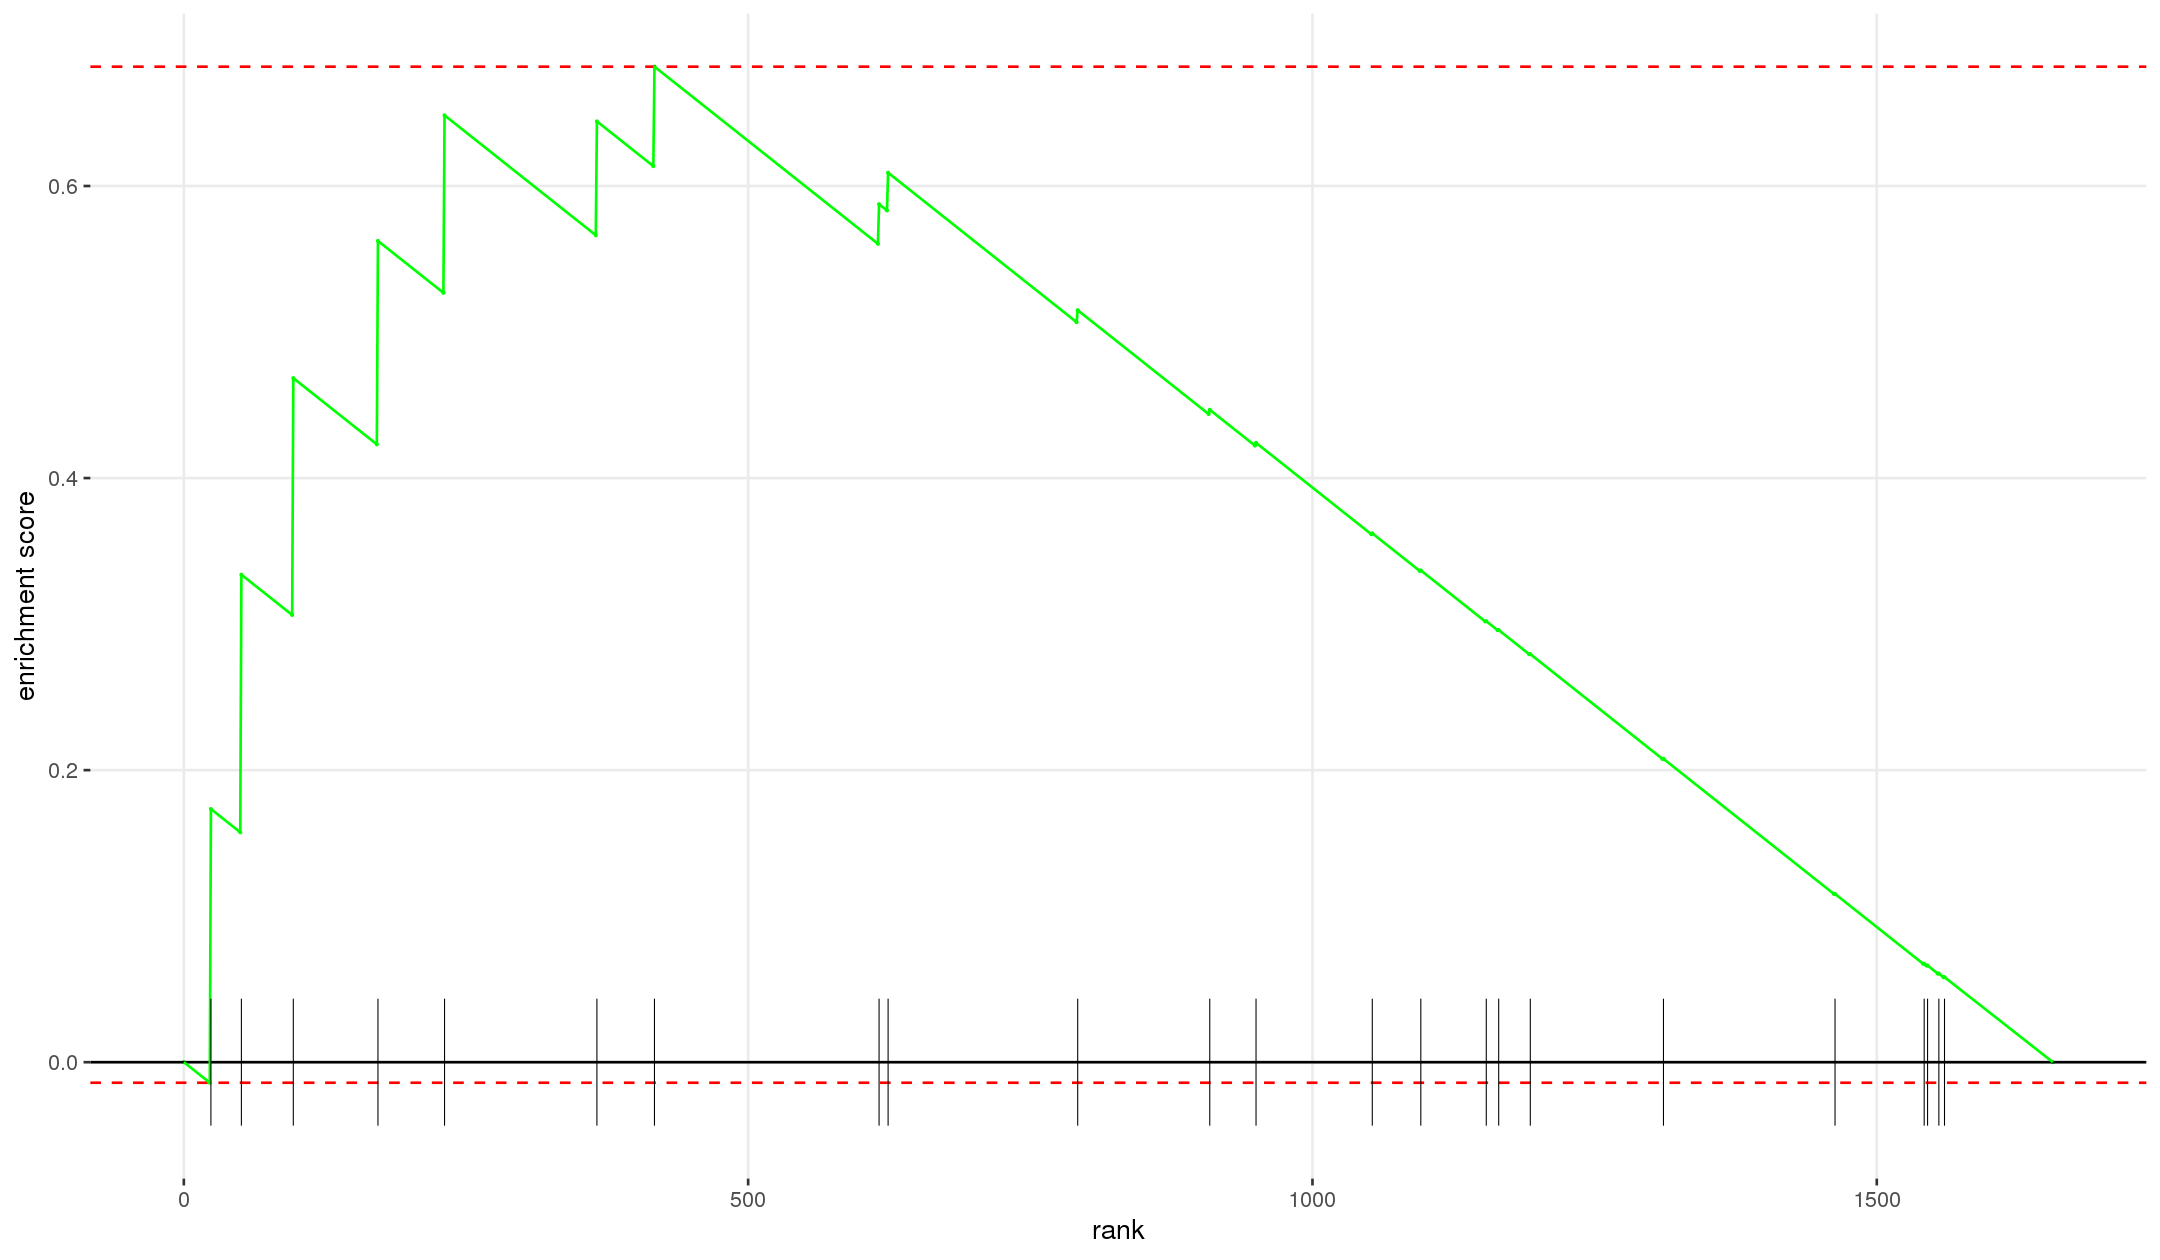

In [539]:
plotEnrichment(pathway = pathway.Go.bp[["GO_NEGATIVE_REGULATION_OF_EPITHELIAL_CELL_PROLIFERATION"]],
               stats = sort(flatten_dbl(D7.by.cluster)), 
                )